In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import tensorflow_probability as tfp
from collections import defaultdict

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [4]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [5]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def zcore_norm_2(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1, zero_time_start=True):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
        
    if zero_time_start:
        init_time_noise = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)           
    else:
        init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
        
    return init_token_noise, init_time_noise

In [8]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [9]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [1, 0, 0, 0],
                            1: [0, 1, 0, 0],
                            2: [0, 0, 1, 0],
                            3: [0, 0, 0, 1]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

def calculate_self_MAD_score(batch):
    self_mad_obj = MAD()
    self_mad_obj.fit(batch)
    return self_mad_obj.compare(batch)['mad']

In [10]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

## Create multitype SeqGan

### 2-LSTM impl.

In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G_mcc(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    time_mu_sigma = Dense(2,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    time_mu, time_sigma = time_mu_sigma[...,:1], tf.math.softplus(time_mu_sigma[...,1:])
    
#     time_mu, time_sigma = time_mu_sigma[...,:1], time_mu_sigma[...,1:]
    
#     time_mu = Dense(1,
#                    activation='linear',
#                    name='dense_time_mu',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
#     time_sigma = Dense(1,
#                activation='linear',
#                name='dense_time_sigma',
#                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)

    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_mu, time_sigma])
        
    return generator


def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator


# critic is a copy of D, except that stateful=True

def build_critic(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    critic_value = Dense(1,
             activation='sigmoid',
             name='critic_final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    critic = Model(
        inputs=[i_et, i_ts],
        outputs=critic_value)
    return critic

### time-lstm

In [12]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G_mcc(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True,
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dense_combined = Dense(hidden_dim, 
#                            activation='elu',
#                            name='dense_combination')(token_time_comb)
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
#     time_mu_sigma = Dense(2,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
#     time_mu, time_sigma = time_mu_sigma[...,:1], tf.math.softplus(time_mu_sigma[...,1:])
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_mu, time_sigma])
        
#     return generator


# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=False,
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)  
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator


# def build_critic(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True,
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)  
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     critic_value = Dense(1,
#              activation='sigmoid',
#              name='critic_final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=critic_value)
#     return discriminator

## Define rollout and sequence generation

In [13]:
def rollout_from_initial_mcc(G, batch_size, init_et, init_ts, L=T, temperature=1, use_tlstm=True):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    all_token_logits = tf.zeros_like(init_et)
    all_time_mu = tf.zeros_like(init_ts)
    all_time_sigma = tf.zeros_like(init_ts)
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    
    if use_tlstm:
        # Time-LSTM
        G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    else:
        # LSTM-token
        G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        # LSTM-time
        G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]

        token_logits, time_mu, time_sigma = G([curr_state_et, curr_state_ts])
        
        # non-differentiable sampling tokens
        sampled_et_ind = tf.random.categorical(token_logits / temperature, num_samples=1, dtype=tf.int32)
        sampled_et = tf.one_hot(sampled_et_ind, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
        
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        # non-differentiable sampling time deltas
        time_mu = tf.reshape(time_mu, [batch_size, 1, 1])
        time_sigma = tf.reshape(time_sigma, [batch_size, 1, 1])
        sampled_ts = tf.random.normal((batch_size, 1, 1), mean=time_mu, stddev=time_sigma, dtype=tf.float64)
        
        # reshape for concat
        token_logits = tf.reshape(token_logits, [batch_size, 1, EVENT_VOCAB_DIM])
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, sampled_ts], axis=1)
        
        all_token_logits = tf.concat([all_token_logits, token_logits], axis=1)
        all_time_mu = tf.concat([all_time_mu, time_mu], axis=1)
        all_time_sigma = tf.concat([all_time_sigma, time_sigma], axis=1)
        
    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :], all_token_logits[:,1:,:], all_time_mu[:,1:,:], all_time_sigma[:,1:,:]


def generate_sequences_mcc(N_gen, generator, batch_size, T, temperature=1, use_tlstm=True):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    all_token_logits = None
    all_time_mu = None
    all_time_sigma = None
    
    init_token_noise, init_time_zeros = generate_initial_noise(zero_time_start=True)
        
    while N < N_gen:
        batch_state_et, batch_state_ts, batch_token_logits, batch_time_mu, batch_time_sigma = rollout_from_initial_mcc(generator, batch_size, init_token_noise, init_time_zeros, T, temperature, use_tlstm)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
            all_token_logits = batch_token_logits
            all_time_mu = batch_time_mu
            all_time_sigma = batch_time_sigma            
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)
            all_token_logits = tf.concat([all_token_logits, batch_token_logits], axis=0)
            all_time_mu = tf.concat([all_time_mu, batch_time_mu], axis=0)
            all_time_sigma = tf.concat([all_time_sigma, batch_time_sigma], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]
    all_token_logits = all_token_logits[:N_gen, :, :]
    all_time_mu = all_time_mu[:N_gen, :, :]
    all_time_sigma = all_time_sigma[:N_gen, :, :]

    return all_type_seq, all_time_seq, all_token_logits, all_time_mu, all_time_sigma

In [14]:
def get_generation_metrics(G):
    _gen_seqs_et, _gen_seqs_ts, _, _, _ = generate_sequences_mcc(N_DATA, G, BATCH_SIZE, T)

    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

In [15]:
def track_training(step, G, save_path=None, verbose=True, plot=True, save_G=True, save_D=True):
    _gen_seqs_et, _gen_seqs_ts, _, _, _ = generate_sequences_mcc(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path and save_G:
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)
        
    if save_path and save_D:
        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

## Pre-Training using MLE

In [16]:
def pretrain_discriminator_and_critic(event_type_batch, time_delta_batch, label_batch, discriminator, critic, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape(persistent=True) as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )
        
        # train critic step by step
        critic_step_loss = []
        critic.reset_states()
        for i in range(T):
            curr_state_et = event_type_batch[:, i:i+1, :]
            curr_state_ts = time_delta_batch[:, i:i+1, :]
            
            q_value = critic([curr_state_et, curr_state_ts])
            critic_mxe_loss = tf.keras.losses.MSE(true_prob, q_value)
            critic_step_loss.append(tf.reduce_mean(critic_mxe_loss))

        critic_loss = tf.reduce_mean(critic_step_loss)

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('total critic loss:{}'.format(critic_loss))

    disc_grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    del tape
    
    return discriminator_loss, critic_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_gaussian_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_mu, time_sigma = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_dist = tfp.distributions.Normal(time_mu, time_sigma)            
            time_gaussian_log = time_dist.log_prob(target_ts)
            time_gaussian_loss = -tf.reduce_mean(time_gaussian_log)  # one step across the whole batch
            step_time_gaussian_loss_list.append(time_gaussian_loss)
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_gaussian_loss = tf.reduce_mean(step_time_gaussian_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_gaussian_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time gaussian loss:{}'.format(episode_time_gaussian_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss, episode_token_ce_loss, episode_time_gaussian_loss

## Pre-training

In [17]:
now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
pretrain_model_save_path = os.path.join(model_save_dir, 'pretrain', now_str)

pretrain_history = defaultdict(list)

print(pretrain_model_save_path)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44


### pre-train G

In [18]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 6
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [27]:
pretrained_generator = build_G_mcc(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

# init_G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-07-23-42/G_1/model_weights.tf'
# pretrained_generator.build(input_shape=((BATCH_SIZE, T, 1)))
# pretrained_generator.load_weights(init_G_save_path)

get_generation_metrics(pretrained_generator)

{'mad': 0.7331875,
 'fid': 2824.3471336608513,
 'oracle': 0.08675,
 'smad': 0.7331875}

In [28]:
step = 0
OPTIMIZER = Adam(lr=1e-4)

  0%|          | 0/93 [00:00<?, ?it/s]

Training Step: 0
event_types: [0, 1, 3, 2, 3, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 2, 3, 1, 1, 2]
mad_score: 0.7325875
fid_score: 2851.26648330865
rule_score: 0.094


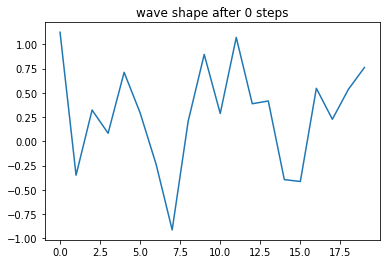

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_0/model_weights.tf
token ce loss:1.38208612887431
time gaussian loss:2.158927877676381
train loss:3.541014006550691


  1%|          | 1/93 [00:09<14:03,  9.16s/it]

Training Step: 1
event_types: [3, 2, 3, 2, 2, 0, 0, 3, 3, 0, 3, 3, 3, 2, 1, 3, 0, 1, 2, 3]
mad_score: 0.7328375
fid_score: 2620.9999837833984
rule_score: 0.08975


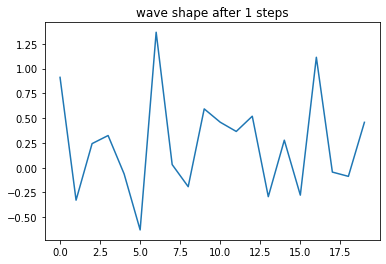

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_1/model_weights.tf
token ce loss:1.380641406493659
time gaussian loss:2.0462439777778694
train loss:3.4268853842715283


  2%|▏         | 2/93 [00:18<13:56,  9.19s/it]

Training Step: 2
event_types: [3, 1, 1, 3, 2, 1, 3, 3, 2, 2, 3, 2, 2, 2, 3, 1, 3, 0, 3, 1]
mad_score: 0.734625
fid_score: 2423.2947689215957
rule_score: 0.088


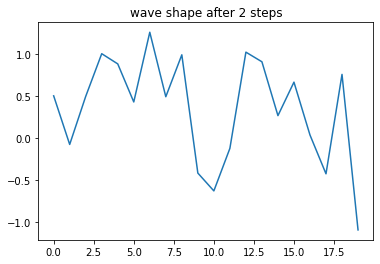

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_2/model_weights.tf
token ce loss:1.3818861976215622
time gaussian loss:2.0259318664877406
train loss:3.4078180641093025


  3%|▎         | 3/93 [00:27<13:43,  9.15s/it]

Training Step: 3
event_types: [0, 2, 0, 1, 0, 1, 3, 1, 2, 2, 0, 3, 2, 3, 3, 1, 3, 1, 2, 3]
mad_score: 0.734675
fid_score: 2226.562605552316
rule_score: 0.07725


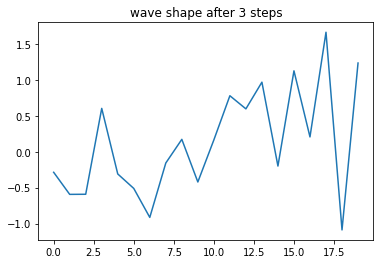

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_3/model_weights.tf
token ce loss:1.381504890245927
time gaussian loss:1.917165632767384
train loss:3.2986705230133113


  4%|▍         | 4/93 [00:36<13:31,  9.11s/it]

Training Step: 4
event_types: [3, 3, 2, 0, 1, 2, 2, 0, 0, 2, 3, 3, 0, 2, 3, 2, 0, 1, 1, 3]
mad_score: 0.7316625
fid_score: 2047.6390491563866
rule_score: 0.08075


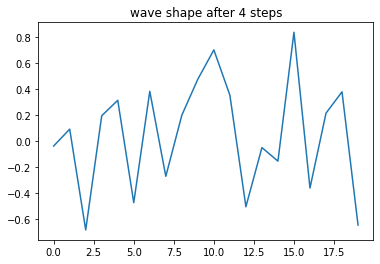

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_4/model_weights.tf
token ce loss:1.3825130201545737
time gaussian loss:1.900279286262422
train loss:3.2827923064169955


  5%|▌         | 5/93 [00:45<13:20,  9.10s/it]

Training Step: 5
event_types: [0, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 0, 3, 2, 2, 3, 2, 1, 0]
mad_score: 0.731075
fid_score: 1846.0615587288335
rule_score: 0.08925


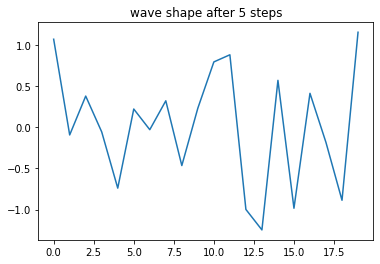

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_5/model_weights.tf
token ce loss:1.3788138625288717
time gaussian loss:1.8467824986298065
train loss:3.2255963611586784


  6%|▋         | 6/93 [00:54<13:09,  9.07s/it]

Training Step: 6
event_types: [2, 3, 1, 2, 1, 2, 3, 1, 1, 2, 0, 2, 3, 3, 2, 3, 2, 3, 1, 2]
mad_score: 0.7316875
fid_score: 1689.692317578006
rule_score: 0.07575


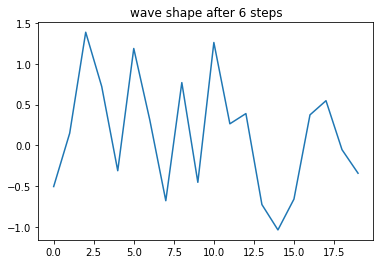

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_6/model_weights.tf
token ce loss:1.3789752416134862
time gaussian loss:1.7338446483475138
train loss:3.112819889961


  8%|▊         | 7/93 [01:03<13:01,  9.09s/it]

Training Step: 7
event_types: [3, 1, 3, 1, 0, 1, 0, 0, 1, 0, 1, 3, 2, 2, 3, 1, 1, 3, 2, 0]
mad_score: 0.73105
fid_score: 1580.5943182101496
rule_score: 0.07975


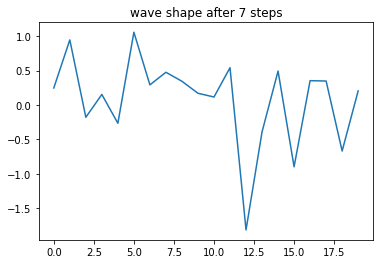

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_7/model_weights.tf
token ce loss:1.3796240106145752
time gaussian loss:1.725920418627225
train loss:3.1055444292418004


  9%|▊         | 8/93 [01:12<12:51,  9.08s/it]

Training Step: 8
event_types: [1, 1, 3, 1, 3, 2, 3, 0, 3, 1, 2, 3, 2, 3, 3, 2, 0, 3, 2, 0]
mad_score: 0.7277
fid_score: 1396.9786693431
rule_score: 0.0795


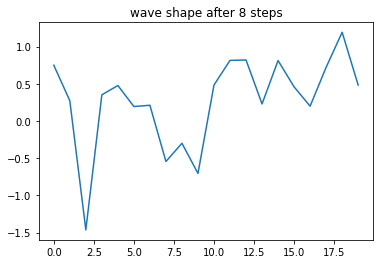

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_8/model_weights.tf
token ce loss:1.381860284450107
time gaussian loss:1.729054172331694
train loss:3.110914456781801


 10%|▉         | 9/93 [01:21<12:42,  9.08s/it]

Training Step: 9
event_types: [2, 3, 0, 3, 1, 0, 0, 1, 2, 1, 0, 3, 0, 3, 1, 1, 3, 2, 0, 2]
mad_score: 0.7312625
fid_score: 1303.1837949147846
rule_score: 0.0755


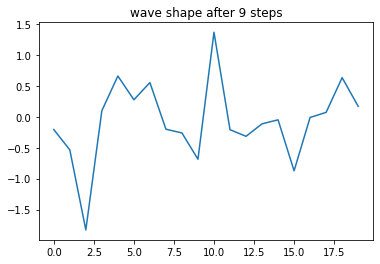

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_9/model_weights.tf
token ce loss:1.3800693500236765
time gaussian loss:1.6735340946104404
train loss:3.053603444634117


 11%|█         | 10/93 [01:30<12:32,  9.07s/it]

Training Step: 10
event_types: [3, 2, 0, 3, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3]
mad_score: 0.7317
fid_score: 1139.115515469525
rule_score: 0.06675


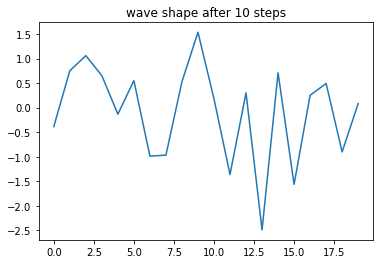

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_10/model_weights.tf
token ce loss:1.3765645817743513
time gaussian loss:1.617048023150623
train loss:2.9936126049249743


 12%|█▏        | 11/93 [01:39<12:23,  9.06s/it]

Training Step: 11
event_types: [1, 1, 2, 3, 3, 3, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 3, 3]
mad_score: 0.725725
fid_score: 1044.282342820771
rule_score: 0.0745


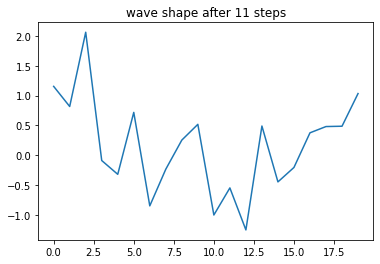

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_11/model_weights.tf
token ce loss:1.3764791127138287
time gaussian loss:1.5768523374359
train loss:2.9533314501497285


 13%|█▎        | 12/93 [01:49<12:18,  9.12s/it]

Training Step: 12
event_types: [0, 1, 1, 1, 3, 2, 1, 0, 3, 0, 2, 0, 2, 3, 1, 0, 2, 0, 0, 0]
mad_score: 0.7302
fid_score: 942.1889715067806
rule_score: 0.06975


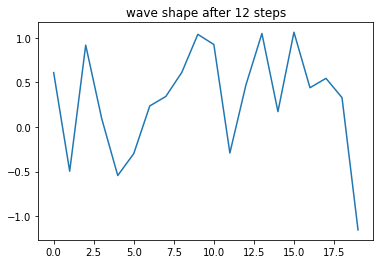

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_12/model_weights.tf
token ce loss:1.377624710990323
time gaussian loss:1.5787583123673057
train loss:2.9563830233576285


 14%|█▍        | 13/93 [01:58<12:13,  9.16s/it]

Training Step: 13
event_types: [1, 0, 0, 2, 0, 3, 3, 1, 3, 2, 0, 0, 2, 2, 0, 1, 1, 1, 3, 1]
mad_score: 0.7243
fid_score: 818.3526284776065
rule_score: 0.065


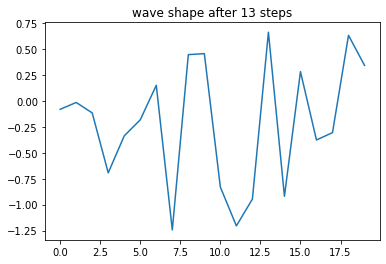

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_13/model_weights.tf
token ce loss:1.3734700525953003
time gaussian loss:1.549988679726222
train loss:2.923458732321522


 15%|█▌        | 14/93 [02:07<12:06,  9.20s/it]

Training Step: 14
event_types: [0, 0, 3, 3, 3, 0, 0, 2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 0, 1]
mad_score: 0.7238875
fid_score: 772.6525115559715
rule_score: 0.063


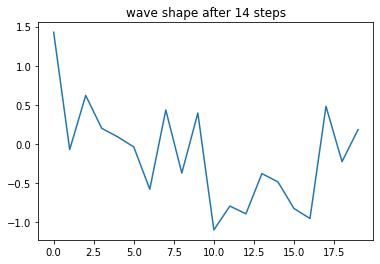

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_14/model_weights.tf
token ce loss:1.3759256998591332
time gaussian loss:1.54272150040932
train loss:2.9186472002684534


 16%|█▌        | 15/93 [02:16<11:57,  9.20s/it]

Training Step: 15
event_types: [1, 2, 3, 3, 3, 2, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3]
mad_score: 0.7217375
fid_score: 698.7127182041537
rule_score: 0.05875


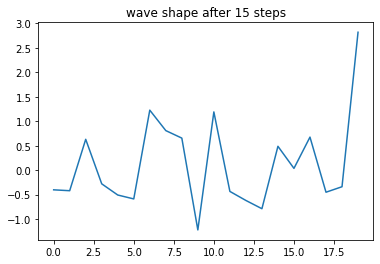

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_15/model_weights.tf
token ce loss:1.3713072315437735
time gaussian loss:1.514064041257173
train loss:2.8853712728009464


 17%|█▋        | 16/93 [02:26<11:55,  9.29s/it]

Training Step: 16
event_types: [0, 2, 1, 2, 1, 0, 3, 1, 3, 0, 3, 0, 1, 0, 3, 2, 3, 3, 3, 1]
mad_score: 0.719
fid_score: 645.0074150040936
rule_score: 0.067


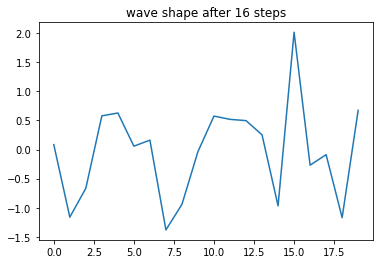

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_16/model_weights.tf
token ce loss:1.3682979431176079
time gaussian loss:1.514154209182348
train loss:2.882452152299956


 18%|█▊        | 17/93 [02:35<11:42,  9.24s/it]

Training Step: 17
event_types: [2, 0, 2, 3, 3, 3, 1, 0, 1, 3, 0, 1, 0, 3, 2, 2, 0, 3, 0, 3]
mad_score: 0.71495
fid_score: 605.6653951489675
rule_score: 0.071


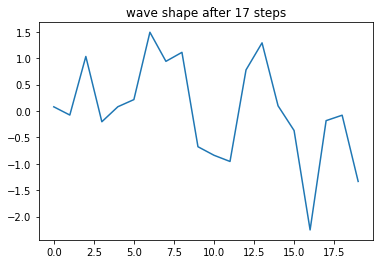

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_17/model_weights.tf
token ce loss:1.368597997618084
time gaussian loss:1.5077770067533915
train loss:2.8763750043714755


 19%|█▉        | 18/93 [02:44<11:28,  9.18s/it]

Training Step: 18
event_types: [2, 0, 3, 1, 2, 0, 3, 1, 3, 1, 3, 3, 1, 2, 2, 3, 2, 0, 0, 2]
mad_score: 0.715625
fid_score: 559.8054388893305
rule_score: 0.066


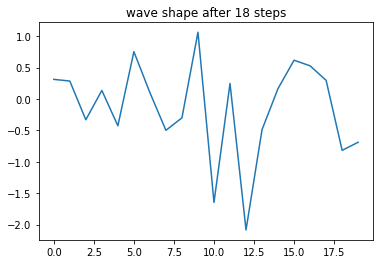

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_18/model_weights.tf
token ce loss:1.3701126821422207
time gaussian loss:1.5182042860519966
train loss:2.8883169681942173


 20%|██        | 19/93 [02:53<11:16,  9.14s/it]

Training Step: 19
event_types: [2, 2, 0, 1, 3, 0, 2, 0, 2, 2, 2, 1, 1, 1, 2, 1, 3, 2, 0, 1]
mad_score: 0.714625
fid_score: 505.61626302301374
rule_score: 0.05975


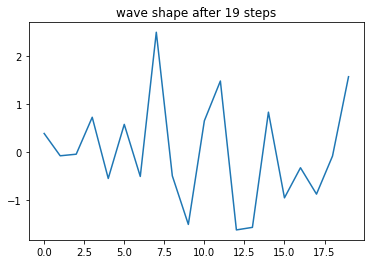

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_19/model_weights.tf
token ce loss:1.369750341445159
time gaussian loss:1.5014054589030312
train loss:2.8711558003481903


 22%|██▏       | 20/93 [03:02<11:04,  9.11s/it]

Training Step: 20
event_types: [0, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3, 2, 2, 3, 3, 2, 2, 3, 1, 2]
mad_score: 0.7124875
fid_score: 487.8920145954084
rule_score: 0.0655


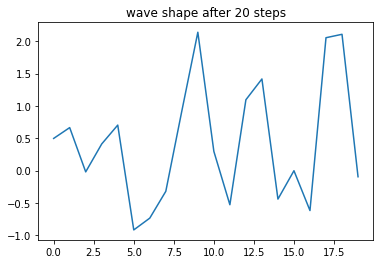

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_20/model_weights.tf
token ce loss:1.3655873347772627
time gaussian loss:1.51327725269572
train loss:2.878864587472983


 23%|██▎       | 21/93 [03:11<10:54,  9.10s/it]

Training Step: 21
event_types: [3, 1, 1, 3, 2, 0, 3, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 3, 2]
mad_score: 0.7124625
fid_score: 439.50405562455126
rule_score: 0.05975


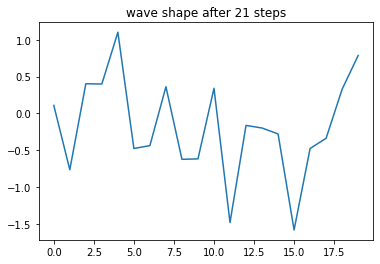

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_21/model_weights.tf
token ce loss:1.3657849361235
time gaussian loss:1.4796935173568615
train loss:2.8454784534803617


 24%|██▎       | 22/93 [03:20<10:46,  9.10s/it]

Training Step: 22
event_types: [2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 3, 3, 2, 0, 0, 2, 1, 3, 1, 1]
mad_score: 0.7116375
fid_score: 421.5727689937396
rule_score: 0.06325


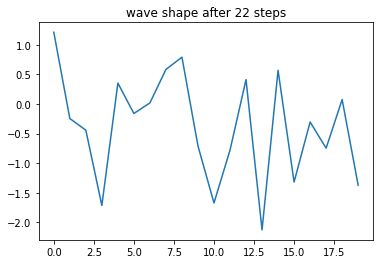

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_22/model_weights.tf
token ce loss:1.3662344002906104
time gaussian loss:1.5034437188275815
train loss:2.869678119118192


 25%|██▍       | 23/93 [03:29<10:36,  9.09s/it]

Training Step: 23
event_types: [1, 0, 2, 2, 3, 1, 1, 1, 1, 3, 1, 1, 0, 1, 2, 2, 0, 3, 1, 0]
mad_score: 0.708
fid_score: 406.7632908837021
rule_score: 0.061


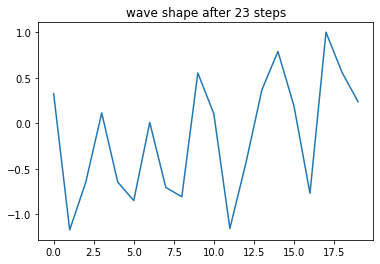

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_23/model_weights.tf
token ce loss:1.3597586061634535
time gaussian loss:1.4706992412285518
train loss:2.8304578473920055


 26%|██▌       | 24/93 [03:38<10:25,  9.07s/it]

Training Step: 24
event_types: [0, 2, 1, 3, 2, 3, 0, 2, 2, 3, 0, 3, 1, 1, 3, 1, 0, 1, 3, 2]
mad_score: 0.7018625
fid_score: 398.45465429884337
rule_score: 0.065


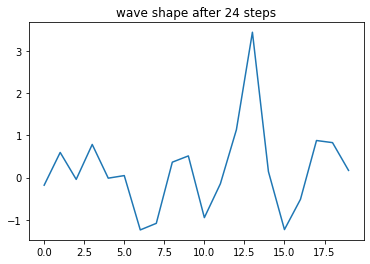

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_24/model_weights.tf
token ce loss:1.3618455040843167
time gaussian loss:1.451443676490711
train loss:2.813289180575028


 27%|██▋       | 25/93 [03:47<10:15,  9.05s/it]

Training Step: 25
event_types: [2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 3, 3, 2, 1, 2]
mad_score: 0.699375
fid_score: 373.1814699889606
rule_score: 0.06375


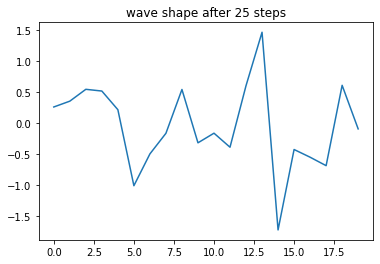

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_25/model_weights.tf
token ce loss:1.363817358424496
time gaussian loss:1.450426688961597
train loss:2.814244047386093


 28%|██▊       | 26/93 [03:56<10:05,  9.03s/it]

Training Step: 26
event_types: [1, 0, 2, 0, 1, 1, 0, 2, 2, 3, 0, 2, 3, 0, 1, 1, 3, 3, 0, 3]
mad_score: 0.6996125
fid_score: 369.67850083280604
rule_score: 0.068


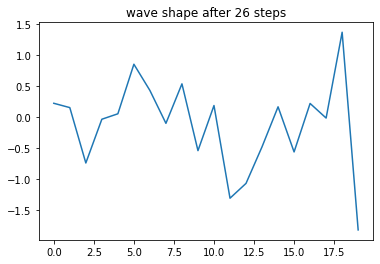

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_26/model_weights.tf
token ce loss:1.3574525483030027
time gaussian loss:1.4375651335287658
train loss:2.7950176818317685


 29%|██▉       | 27/93 [04:06<09:58,  9.07s/it]

Training Step: 27
event_types: [3, 0, 1, 2, 1, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 1, 0, 3, 3, 2]
mad_score: 0.6914875
fid_score: 362.6982097922934
rule_score: 0.0665


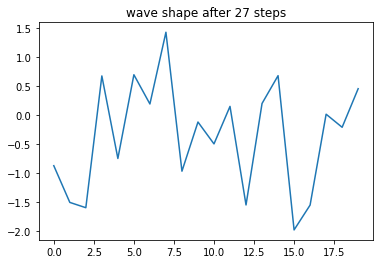

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_27/model_weights.tf
token ce loss:1.3556104303520793
time gaussian loss:1.4713101999203626
train loss:2.8269206302724417


 30%|███       | 28/93 [04:15<09:51,  9.11s/it]

Training Step: 28
event_types: [2, 3, 0, 1, 0, 2, 0, 0, 2, 3, 0, 3, 2, 3, 2, 1, 0, 2, 2, 2]
mad_score: 0.6925375
fid_score: 339.67799518400824
rule_score: 0.06225


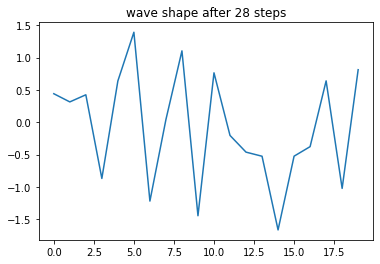

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_28/model_weights.tf
token ce loss:1.3535462508245344
time gaussian loss:1.4642707834266402
train loss:2.8178170342511746


 31%|███       | 29/93 [04:24<09:41,  9.09s/it]

Training Step: 29
event_types: [2, 0, 3, 0, 3, 2, 2, 0, 2, 1, 3, 3, 2, 2, 2, 2, 2, 0, 3, 3]
mad_score: 0.690475
fid_score: 356.29493333642756
rule_score: 0.0645


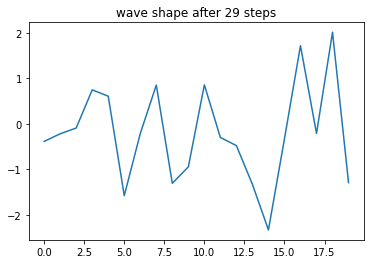

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_29/model_weights.tf
token ce loss:1.3543931961034346
time gaussian loss:1.4702822360987302
train loss:2.8246754322021648


 32%|███▏      | 30/93 [04:33<09:31,  9.07s/it]

Training Step: 30
event_types: [1, 1, 0, 1, 3, 1, 0, 1, 3, 3, 1, 0, 1, 0, 2, 3, 1, 3, 3, 2]
mad_score: 0.68825
fid_score: 338.06301547166834
rule_score: 0.06675


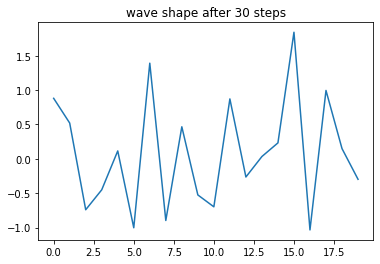

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_30/model_weights.tf
token ce loss:1.3541313358293465
time gaussian loss:1.457562359417085
train loss:2.8116936952464315


 33%|███▎      | 31/93 [04:43<09:37,  9.32s/it]

Training Step: 31
event_types: [3, 2, 3, 3, 1, 3, 3, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 3, 1, 3]
mad_score: 0.6855
fid_score: 349.0755867106838
rule_score: 0.07025


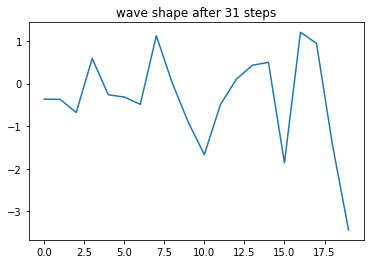

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_31/model_weights.tf
token ce loss:1.3512661303492588
time gaussian loss:1.4688722528324523
train loss:2.8201383831817113


 34%|███▍      | 32/93 [04:52<09:24,  9.26s/it]

Training Step: 32
event_types: [2, 3, 3, 0, 3, 2, 2, 2, 2, 2, 2, 3, 0, 0, 2, 3, 3, 1, 1, 1]
mad_score: 0.6831625
fid_score: 344.87155956256885
rule_score: 0.06675


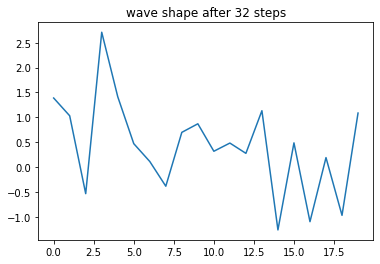

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_32/model_weights.tf
token ce loss:1.3530088056969993
time gaussian loss:1.4676242082687154
train loss:2.8206330139657148


 35%|███▌      | 33/93 [05:01<09:11,  9.19s/it]

Training Step: 33
event_types: [2, 3, 2, 1, 3, 0, 2, 0, 2, 2, 1, 0, 1, 3, 2, 0, 2, 2, 2, 1]
mad_score: 0.6786625
fid_score: 345.46664470171083
rule_score: 0.0685


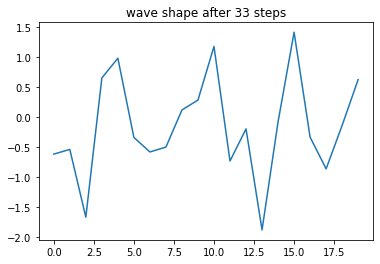

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_33/model_weights.tf
token ce loss:1.3467628170421733
time gaussian loss:1.456274755187552
train loss:2.803037572229725


 37%|███▋      | 34/93 [05:10<08:59,  9.14s/it]

Training Step: 34
event_types: [0, 1, 3, 1, 2, 2, 3, 3, 3, 0, 2, 3, 2, 3, 0, 3, 0, 2, 3, 3]
mad_score: 0.676875
fid_score: 336.4355753281742
rule_score: 0.0695


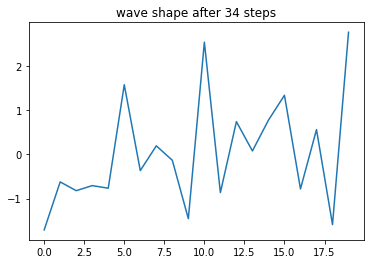

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_34/model_weights.tf
token ce loss:1.3543468149563196
time gaussian loss:1.4424719220164306
train loss:2.7968187369727504


 38%|███▊      | 35/93 [05:19<08:47,  9.09s/it]

Training Step: 35
event_types: [1, 2, 1, 0, 2, 2, 0, 3, 0, 1, 2, 1, 3, 2, 3, 0, 2, 0, 1, 2]
mad_score: 0.6746
fid_score: 350.18504040916764
rule_score: 0.07175


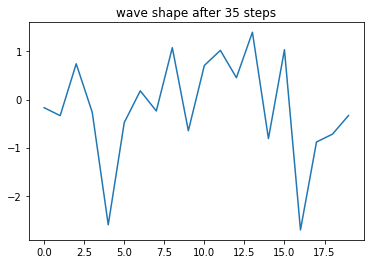

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_35/model_weights.tf
token ce loss:1.3483162700567817
time gaussian loss:1.4522253821222764
train loss:2.8005416521790583


 39%|███▊      | 36/93 [05:28<08:36,  9.06s/it]

Training Step: 36
event_types: [3, 2, 3, 0, 0, 1, 1, 1, 0, 3, 0, 1, 0, 0, 3, 2, 2, 3, 3, 2]
mad_score: 0.6721375
fid_score: 356.27409885221647
rule_score: 0.065


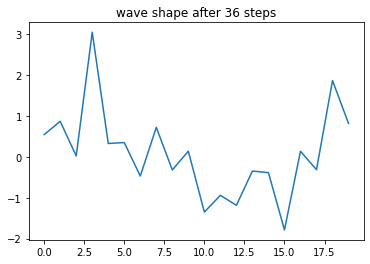

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_36/model_weights.tf
token ce loss:1.3448287192244184
time gaussian loss:1.4563926270011953
train loss:2.8012213462256135


 40%|███▉      | 37/93 [05:37<08:27,  9.07s/it]

Training Step: 37
event_types: [1, 2, 1, 1, 1, 3, 1, 0, 1, 1, 2, 3, 2, 1, 2, 3, 0, 2, 0, 1]
mad_score: 0.6696375
fid_score: 354.1024949239975
rule_score: 0.07375


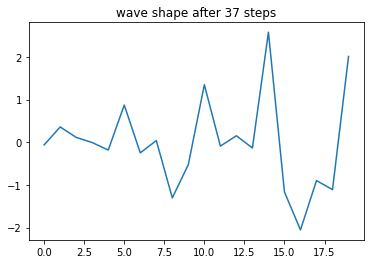

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_37/model_weights.tf
token ce loss:1.34950669825069
time gaussian loss:1.441377131970841
train loss:2.790883830221531


 41%|████      | 38/93 [05:46<08:17,  9.04s/it]

Training Step: 38
event_types: [2, 1, 3, 0, 2, 1, 3, 3, 0, 2, 2, 2, 2, 1, 0, 2, 3, 2, 3, 3]
mad_score: 0.6647625
fid_score: 329.20000360787066
rule_score: 0.08125


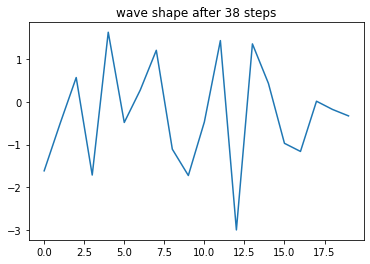

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_38/model_weights.tf
token ce loss:1.3496388751840145
time gaussian loss:1.4351893856100713
train loss:2.784828260794086


 42%|████▏     | 39/93 [05:55<08:07,  9.03s/it]

Training Step: 39
event_types: [2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 3, 2, 2, 1, 2, 2, 3, 1]
mad_score: 0.6660375
fid_score: 341.58527841348035
rule_score: 0.0675


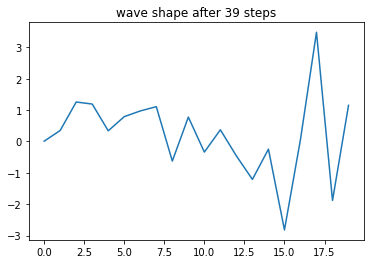

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_39/model_weights.tf
token ce loss:1.3459656514547613
time gaussian loss:1.4652190847932727
train loss:2.811184736248034


 43%|████▎     | 40/93 [06:04<07:58,  9.03s/it]

Training Step: 40
event_types: [1, 2, 2, 2, 1, 0, 2, 2, 3, 2, 1, 1, 3, 1, 2, 2, 2, 0, 2, 2]
mad_score: 0.6610875
fid_score: 349.02818136950793
rule_score: 0.07425


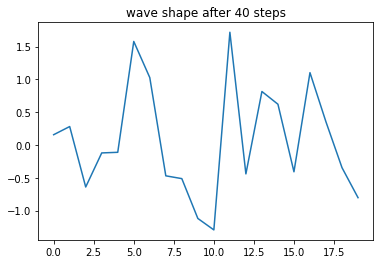

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_40/model_weights.tf
token ce loss:1.346673428492172
time gaussian loss:1.4432027396387668
train loss:2.789876168130939


 44%|████▍     | 41/93 [06:13<07:49,  9.03s/it]

Training Step: 41
event_types: [0, 1, 1, 1, 0, 3, 1, 1, 2, 1, 0, 0, 1, 2, 2, 2, 1, 1, 2, 3]
mad_score: 0.6574375
fid_score: 338.9216507598376
rule_score: 0.073


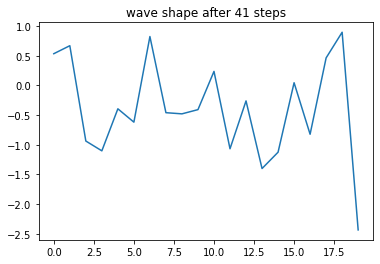

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_41/model_weights.tf
token ce loss:1.3472833356021496
time gaussian loss:1.4512349911101816
train loss:2.7985183267123315


 45%|████▌     | 42/93 [06:22<07:41,  9.05s/it]

Training Step: 42
event_types: [0, 0, 2, 0, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 1]
mad_score: 0.6558625
fid_score: 349.0504348650346
rule_score: 0.0755


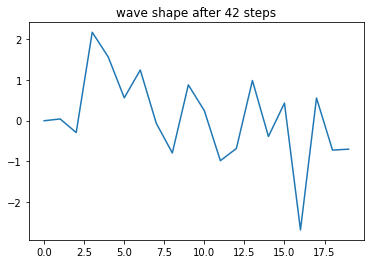

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_42/model_weights.tf
token ce loss:1.34890584622265
time gaussian loss:1.4766774149763047
train loss:2.825583261198955


 46%|████▌     | 43/93 [06:31<07:32,  9.05s/it]

Training Step: 43
event_types: [0, 3, 2, 1, 0, 1, 1, 2, 1, 3, 2, 0, 1, 0, 0, 0, 3, 0, 0, 1]
mad_score: 0.65605
fid_score: 341.081287845761
rule_score: 0.078


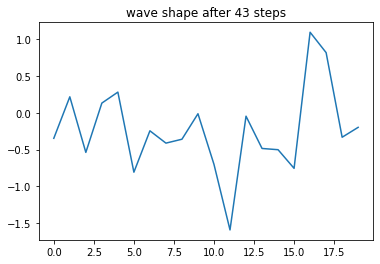

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_43/model_weights.tf
token ce loss:1.3430031147764057
time gaussian loss:1.4552482549513812
train loss:2.7982513697277867


 47%|████▋     | 44/93 [06:40<07:23,  9.06s/it]

Training Step: 44
event_types: [2, 3, 0, 3, 2, 1, 0, 2, 1, 3, 2, 2, 0, 1, 0, 1, 3, 3, 2, 3]
mad_score: 0.6583375
fid_score: 335.8145176996591
rule_score: 0.076


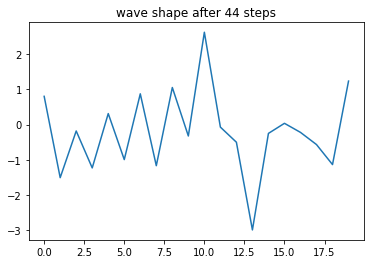

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_44/model_weights.tf
token ce loss:1.3413243348153803
time gaussian loss:1.4362696753870954
train loss:2.777594010202476


 48%|████▊     | 45/93 [06:49<07:14,  9.04s/it]

Training Step: 45
event_types: [3, 2, 2, 3, 3, 3, 3, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1]
mad_score: 0.6500375
fid_score: 329.6255003608036
rule_score: 0.07875


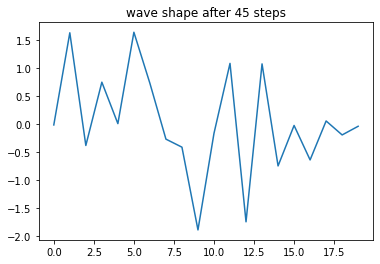

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_45/model_weights.tf
token ce loss:1.34233346926615
time gaussian loss:1.4611084840238284
train loss:2.8034419532899784


 49%|████▉     | 46/93 [06:58<07:06,  9.08s/it]

Training Step: 46
event_types: [3, 3, 1, 3, 1, 2, 1, 1, 1, 2, 2, 0, 2, 3, 1, 1, 0, 2, 2, 1]
mad_score: 0.650375
fid_score: 327.11208888700963
rule_score: 0.07825


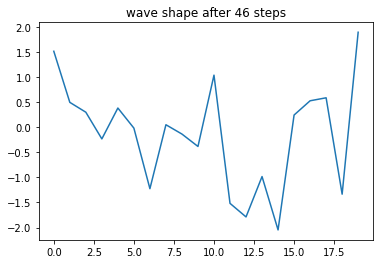

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_46/model_weights.tf
token ce loss:1.3398100635215586
time gaussian loss:1.4561276362894569
train loss:2.7959376998110157


 51%|█████     | 47/93 [07:08<06:59,  9.12s/it]

Training Step: 47
event_types: [0, 1, 2, 1, 0, 3, 3, 0, 0, 2, 3, 2, 1, 2, 1, 3, 1, 2, 2, 0]
mad_score: 0.6495625
fid_score: 339.7257212604885
rule_score: 0.07625


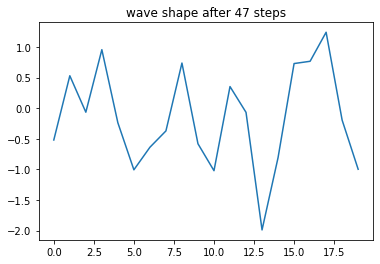

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_47/model_weights.tf
token ce loss:1.3419300154948886
time gaussian loss:1.4457756136848368
train loss:2.787705629179725


 52%|█████▏    | 48/93 [07:17<06:50,  9.12s/it]

Training Step: 48
event_types: [0, 1, 3, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 3, 0, 3, 2]
mad_score: 0.6498
fid_score: 335.0206399218891
rule_score: 0.07575


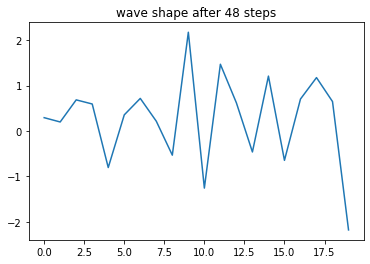

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_48/model_weights.tf
token ce loss:1.3432641292743495
time gaussian loss:1.4370889113409016
train loss:2.780353040615251


 53%|█████▎    | 49/93 [07:26<06:39,  9.09s/it]

Training Step: 49
event_types: [2, 0, 2, 1, 3, 2, 2, 2, 1, 2, 3, 1, 3, 1, 2, 1, 2, 1, 2, 1]
mad_score: 0.647125
fid_score: 314.7052621961412
rule_score: 0.086


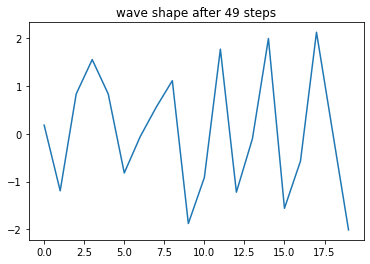

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_49/model_weights.tf
token ce loss:1.3423454975301186
time gaussian loss:1.4402454723585478
train loss:2.782590969888666


 54%|█████▍    | 50/93 [07:35<06:29,  9.06s/it]

Training Step: 50
event_types: [1, 3, 1, 1, 2, 1, 1, 0, 2, 3, 2, 1, 3, 2, 0, 0, 1, 2, 2, 2]
mad_score: 0.646875
fid_score: 307.30140229398125
rule_score: 0.08275


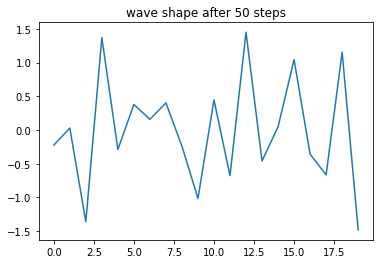

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_50/model_weights.tf
token ce loss:1.3443149287383829
time gaussian loss:1.433054003996708
train loss:2.777368932735091


 55%|█████▍    | 51/93 [07:44<06:19,  9.04s/it]

Training Step: 51
event_types: [1, 1, 2, 0, 2, 3, 1, 2, 2, 3, 1, 2, 3, 2, 1, 2, 2, 3, 1, 2]
mad_score: 0.6451875
fid_score: 324.1117204437382
rule_score: 0.0765


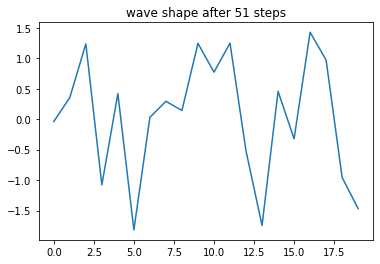

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_51/model_weights.tf
token ce loss:1.3430784569715253
time gaussian loss:1.4310688081637322
train loss:2.7741472651352574


 56%|█████▌    | 52/93 [07:53<06:11,  9.06s/it]

Training Step: 52
event_types: [1, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 3, 1, 3, 3]
mad_score: 0.646625
fid_score: 309.873141458353
rule_score: 0.09025


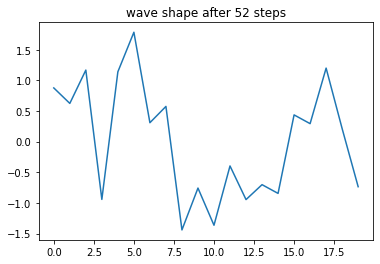

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_52/model_weights.tf
token ce loss:1.343356655149141
time gaussian loss:1.4474607230602519
train loss:2.790817378209393


 57%|█████▋    | 53/93 [08:02<06:03,  9.09s/it]

Training Step: 53
event_types: [0, 0, 2, 2, 2, 3, 1, 2, 3, 0, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2]
mad_score: 0.6434875
fid_score: 293.96847804898374
rule_score: 0.0735


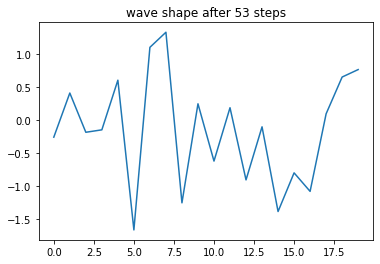

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_53/model_weights.tf
token ce loss:1.3409550834946653
time gaussian loss:1.4477165814114776
train loss:2.788671664906143


 58%|█████▊    | 54/93 [08:11<05:54,  9.09s/it]

Training Step: 54
event_types: [1, 3, 2, 1, 3, 2, 1, 0, 2, 0, 1, 2, 3, 2, 2, 3, 3, 2, 0, 1]
mad_score: 0.6411125
fid_score: 280.2890195869225
rule_score: 0.0855


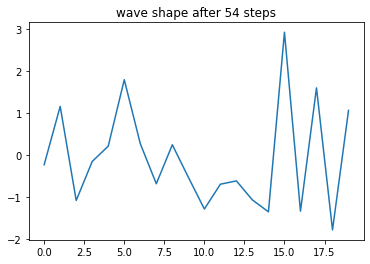

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_54/model_weights.tf
token ce loss:1.3482862798893294
time gaussian loss:1.456228005806103
train loss:2.8045142856954324


 59%|█████▉    | 55/93 [08:20<05:44,  9.07s/it]

Training Step: 55
event_types: [3, 1, 0, 2, 3, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 3, 1]
mad_score: 0.6435625
fid_score: 275.5427595009387
rule_score: 0.0785


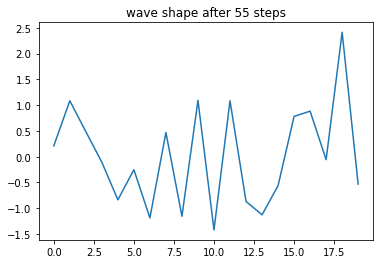

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_55/model_weights.tf
token ce loss:1.3412326672720152
time gaussian loss:1.441445227154861
train loss:2.782677894426876


 60%|██████    | 56/93 [08:32<06:06,  9.91s/it]

Training Step: 56
event_types: [3, 0, 2, 1, 2, 2, 2, 2, 2, 1, 3, 2, 0, 0, 1, 3, 2, 1, 0, 0]
mad_score: 0.6423375
fid_score: 284.079135128688
rule_score: 0.0845


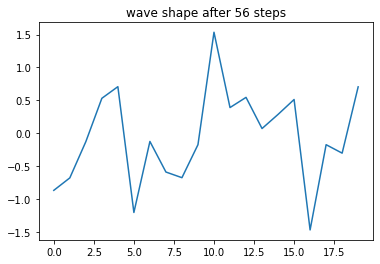

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_56/model_weights.tf
token ce loss:1.3375354467442733
time gaussian loss:1.4417184919265371
train loss:2.77925393867081


 61%|██████▏   | 57/93 [08:42<06:01, 10.03s/it]

Training Step: 57
event_types: [0, 3, 2, 3, 3, 2, 0, 1, 2, 0, 2, 2, 0, 2, 3, 2, 2, 3, 2, 2]
mad_score: 0.642825
fid_score: 268.1113034704619
rule_score: 0.0815


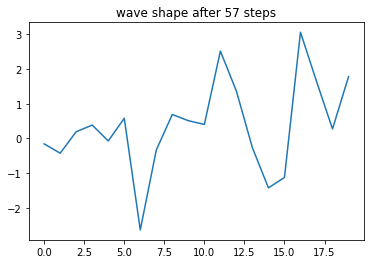

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_57/model_weights.tf
token ce loss:1.3460691885664737
time gaussian loss:1.448392784591191
train loss:2.7944619731576648


 62%|██████▏   | 58/93 [08:51<05:40,  9.73s/it]

Training Step: 58
event_types: [2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2, 2, 3, 2, 1, 3, 0, 2, 2, 1]
mad_score: 0.6424375
fid_score: 272.7860063811588
rule_score: 0.0865


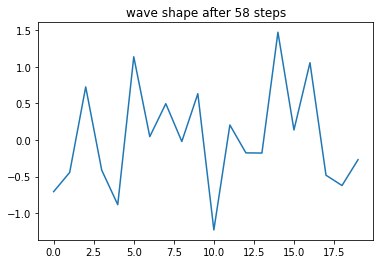

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_58/model_weights.tf
token ce loss:1.3365042946696852
time gaussian loss:1.437762014580611
train loss:2.7742663092502964


 63%|██████▎   | 59/93 [09:00<05:24,  9.53s/it]

Training Step: 59
event_types: [3, 2, 3, 2, 0, 2, 3, 2, 0, 1, 1, 1, 2, 1, 0, 0, 3, 3, 3, 0]
mad_score: 0.6450875
fid_score: 274.68730619626075
rule_score: 0.0825


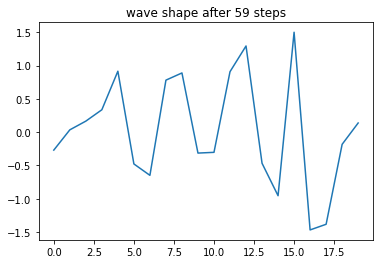

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_59/model_weights.tf
token ce loss:1.3384075619564206
time gaussian loss:1.4374802997764053
train loss:2.775887861732826


 65%|██████▍   | 60/93 [09:09<05:09,  9.37s/it]

Training Step: 60
event_types: [3, 0, 3, 2, 3, 1, 2, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 3, 1, 2]
mad_score: 0.642575
fid_score: 257.7885526649887
rule_score: 0.08675


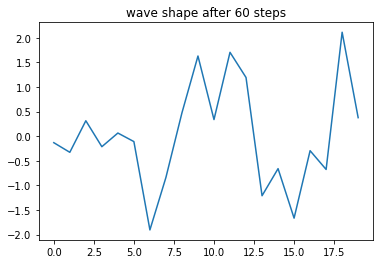

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_60/model_weights.tf
token ce loss:1.3344890470839676
time gaussian loss:1.4483975081127205
train loss:2.782886555196688


 66%|██████▌   | 61/93 [09:18<04:56,  9.26s/it]

Training Step: 61
event_types: [0, 0, 3, 3, 3, 1, 3, 3, 2, 2, 2, 3, 2, 2, 0, 1, 1, 2, 3, 2]
mad_score: 0.6425625
fid_score: 260.99740127491367
rule_score: 0.0805


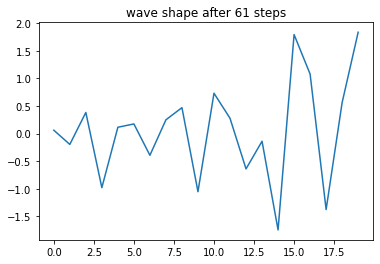

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_61/model_weights.tf
token ce loss:1.3361775415218928
time gaussian loss:1.4225171807197206
train loss:2.7586947222416134


 67%|██████▋   | 62/93 [09:28<04:45,  9.20s/it]

Training Step: 62
event_types: [2, 2, 2, 1, 0, 2, 2, 1, 2, 3, 2, 3, 0, 2, 3, 2, 2, 1, 1, 2]
mad_score: 0.6446375
fid_score: 248.33278092209048
rule_score: 0.09175


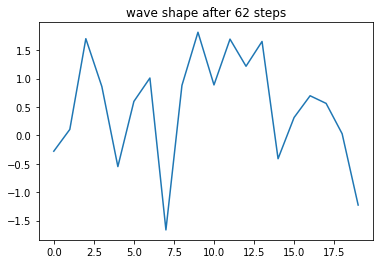

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_62/model_weights.tf
token ce loss:1.3363615431775933
time gaussian loss:1.4354914113368749
train loss:2.7718529545144683


 68%|██████▊   | 63/93 [09:39<05:00, 10.02s/it]

Training Step: 63
event_types: [1, 3, 0, 3, 3, 2, 1, 1, 2, 0, 0, 1, 3, 1, 2, 0, 0, 3, 2, 2]
mad_score: 0.6423375
fid_score: 229.91694010193203
rule_score: 0.084


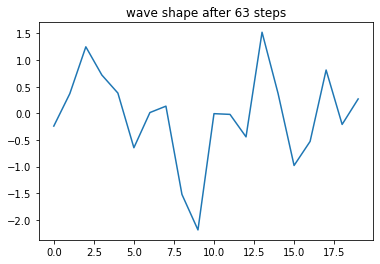

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_63/model_weights.tf
token ce loss:1.3372117439183733
time gaussian loss:1.4403423701436526
train loss:2.777554114062026


 69%|██████▉   | 64/93 [09:49<04:43,  9.77s/it]

Training Step: 64
event_types: [3, 2, 0, 1, 1, 3, 2, 2, 3, 1, 0, 3, 2, 2, 0, 0, 3, 3, 2, 0]
mad_score: 0.6416
fid_score: 251.60258849667213
rule_score: 0.08025


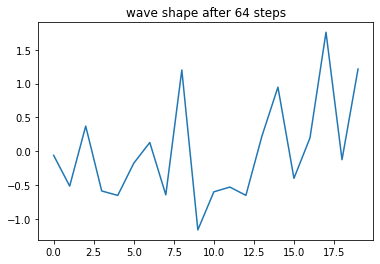

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_64/model_weights.tf
token ce loss:1.3395473328984355
time gaussian loss:1.4414788727417407
train loss:2.781026205640176


 70%|██████▉   | 65/93 [09:58<04:27,  9.55s/it]

Training Step: 65
event_types: [2, 3, 0, 1, 0, 0, 0, 3, 0, 3, 0, 0, 2, 3, 1, 2, 3, 1, 2, 3]
mad_score: 0.641075
fid_score: 236.9562666984757
rule_score: 0.086


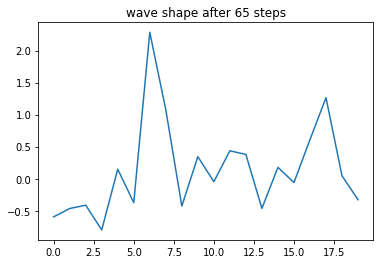

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_65/model_weights.tf
token ce loss:1.336869741308529
time gaussian loss:1.434697210414584
train loss:2.771566951723113


 71%|███████   | 66/93 [10:07<04:13,  9.39s/it]

Training Step: 66
event_types: [2, 1, 0, 1, 3, 1, 0, 2, 3, 2, 1, 1, 0, 2, 1, 2, 1, 3, 2, 0]
mad_score: 0.64475
fid_score: 229.31294812368793
rule_score: 0.08425


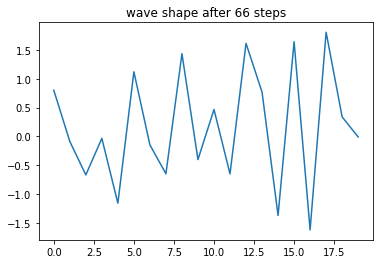

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_66/model_weights.tf
token ce loss:1.3382023502452982
time gaussian loss:1.4278427381822052
train loss:2.7660450884275036


 72%|███████▏  | 67/93 [10:16<04:01,  9.31s/it]

Training Step: 67
event_types: [1, 2, 0, 0, 0, 1, 3, 1, 0, 3, 2, 2, 3, 2, 2, 1, 0, 0, 1, 0]
mad_score: 0.6428625
fid_score: 226.71250249509862
rule_score: 0.09475


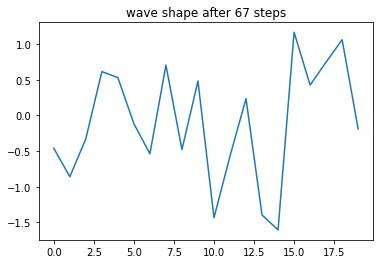

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_67/model_weights.tf
token ce loss:1.3349800892168668
time gaussian loss:1.4286120201699852
train loss:2.763592109386852


 73%|███████▎  | 68/93 [10:25<03:50,  9.23s/it]

Training Step: 68
event_types: [2, 2, 3, 2, 2, 0, 1, 3, 1, 0, 2, 2, 0, 2, 3, 1, 3, 1, 2, 3]
mad_score: 0.644775
fid_score: 218.090974977449
rule_score: 0.084


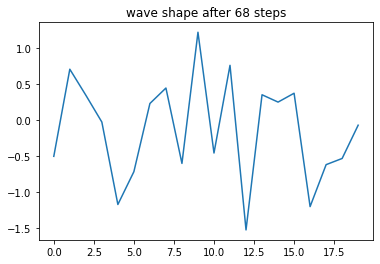

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_68/model_weights.tf
token ce loss:1.3354645695427187
time gaussian loss:1.4078176521095074
train loss:2.743282221652226


 74%|███████▍  | 69/93 [10:34<03:40,  9.18s/it]

Training Step: 69
event_types: [1, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 3, 1, 1, 2, 3, 1, 2, 1, 2]
mad_score: 0.6412625
fid_score: 228.3784682185666
rule_score: 0.0895


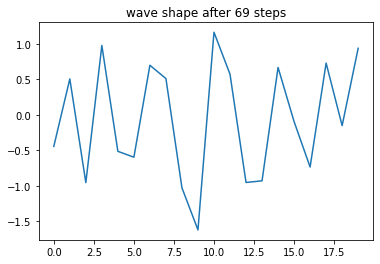

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_69/model_weights.tf
token ce loss:1.3400598841167952
time gaussian loss:1.4351257787987581
train loss:2.775185662915553


 75%|███████▌  | 70/93 [10:43<03:29,  9.11s/it]

Training Step: 70
event_types: [2, 2, 2, 0, 1, 0, 3, 0, 2, 3, 2, 1, 3, 1, 2, 2, 1, 1, 2, 2]
mad_score: 0.6428875
fid_score: 202.61865820490254
rule_score: 0.09


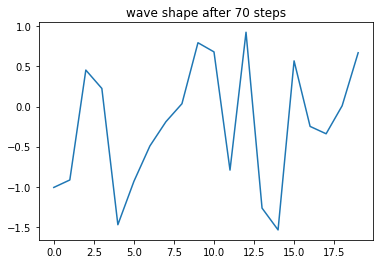

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_70/model_weights.tf
token ce loss:1.3385596446031212
time gaussian loss:1.4304449384770603
train loss:2.7690045830801813


 76%|███████▋  | 71/93 [10:52<03:19,  9.08s/it]

Training Step: 71
event_types: [0, 3, 3, 3, 2, 1, 3, 3, 3, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2]
mad_score: 0.638125
fid_score: 209.09072067092944
rule_score: 0.0925


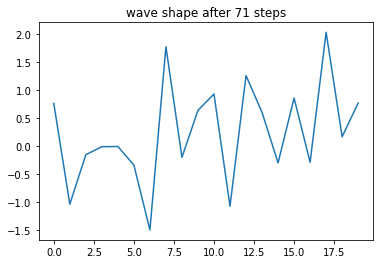

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_71/model_weights.tf
token ce loss:1.3381808518552505
time gaussian loss:1.4420938048075016
train loss:2.780274656662752


 77%|███████▋  | 72/93 [11:01<03:10,  9.09s/it]

Training Step: 72
event_types: [1, 0, 1, 0, 3, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 3, 2, 3, 1, 2]
mad_score: 0.6428375
fid_score: 200.9044170636816
rule_score: 0.097


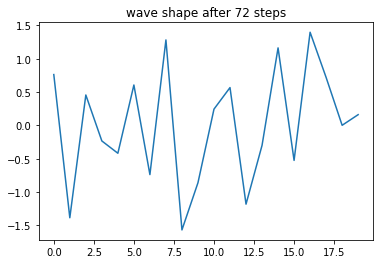

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_72/model_weights.tf
token ce loss:1.3345777648508215
time gaussian loss:1.4222881637198959
train loss:2.7568659285707175


 78%|███████▊  | 73/93 [11:10<03:01,  9.07s/it]

Training Step: 73
event_types: [2, 2, 0, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 3, 3, 2, 2, 2, 2, 3]
mad_score: 0.6395625
fid_score: 203.7085785902587
rule_score: 0.09375


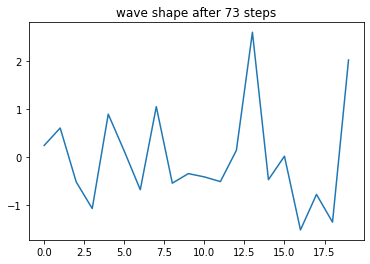

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_73/model_weights.tf
token ce loss:1.3376671427822047
time gaussian loss:1.4219754448837378
train loss:2.7596425876659425


 80%|███████▉  | 74/93 [11:19<02:51,  9.05s/it]

Training Step: 74
event_types: [2, 3, 2, 2, 3, 1, 2, 1, 1, 2, 2, 0, 2, 3, 0, 2, 3, 0, 3, 1]
mad_score: 0.6439125
fid_score: 215.69886595840495
rule_score: 0.08375


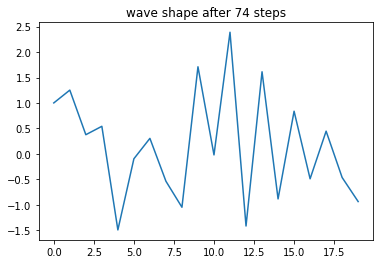

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_74/model_weights.tf
token ce loss:1.3367230151128529
time gaussian loss:1.4216998084061885
train loss:2.7584228235190413


 81%|████████  | 75/93 [11:28<02:42,  9.04s/it]

Training Step: 75
event_types: [1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 3, 0, 2, 2, 2, 1, 1, 3, 2]
mad_score: 0.6403
fid_score: 204.99183697373883
rule_score: 0.09575


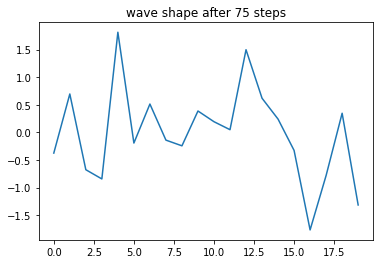

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_75/model_weights.tf
token ce loss:1.3324055057426079
time gaussian loss:1.4213853933809752
train loss:2.753790899123583


 82%|████████▏ | 76/93 [11:37<02:33,  9.04s/it]

Training Step: 76
event_types: [3, 1, 1, 3, 2, 1, 2, 1, 0, 3, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2]
mad_score: 0.6417625
fid_score: 195.54523781148725
rule_score: 0.09225


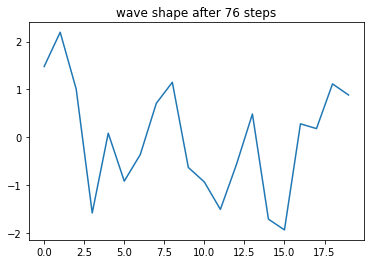

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_76/model_weights.tf
token ce loss:1.3340109041749375
time gaussian loss:1.4356961089010882
train loss:2.769707013076026


 83%|████████▎ | 77/93 [11:46<02:24,  9.05s/it]

Training Step: 77
event_types: [1, 0, 1, 0, 1, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2]
mad_score: 0.6432625
fid_score: 206.77888280949568
rule_score: 0.1015


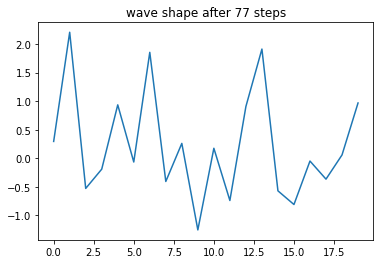

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_77/model_weights.tf
token ce loss:1.3361114593112575
time gaussian loss:1.4321572674709175
train loss:2.768268726782175


 84%|████████▍ | 78/93 [11:55<02:15,  9.04s/it]

Training Step: 78
event_types: [2, 2, 2, 0, 1, 3, 2, 2, 3, 1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2]
mad_score: 0.6413375
fid_score: 187.55236730380005
rule_score: 0.094


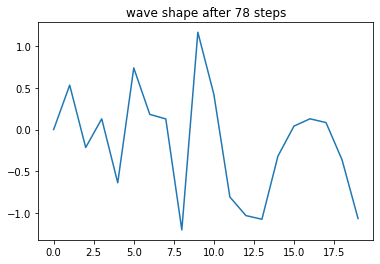

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_78/model_weights.tf
token ce loss:1.3340673383149237
time gaussian loss:1.4130525746019102
train loss:2.747119912916834


 85%|████████▍ | 79/93 [12:04<02:06,  9.03s/it]

Training Step: 79
event_types: [0, 1, 1, 3, 2, 2, 2, 0, 2, 0, 3, 3, 3, 2, 1, 2, 2, 2, 0, 1]
mad_score: 0.6439875
fid_score: 188.51830903439634
rule_score: 0.0885


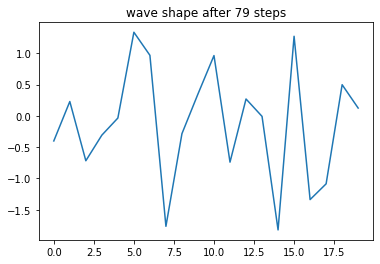

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_79/model_weights.tf
token ce loss:1.3317469562373976
time gaussian loss:1.41754030002741
train loss:2.7492872562648074


 86%|████████▌ | 80/93 [12:13<01:58,  9.09s/it]

Training Step: 80
event_types: [0, 3, 2, 3, 2, 3, 3, 3, 3, 1, 2, 1, 1, 2, 0, 2, 3, 2, 2, 2]
mad_score: 0.6470375
fid_score: 206.4895527340908
rule_score: 0.0945


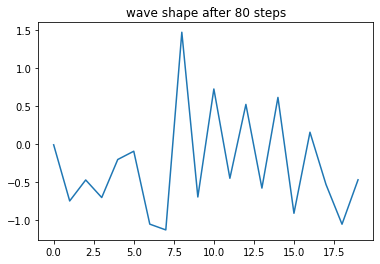

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_80/model_weights.tf
token ce loss:1.3310828261078267
time gaussian loss:1.4121219750772382
train loss:2.743204801185065


 87%|████████▋ | 81/93 [12:22<01:48,  9.07s/it]

Training Step: 81
event_types: [0, 3, 2, 3, 2, 3, 2, 0, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 0, 3]
mad_score: 0.6426125
fid_score: 209.2533952762888
rule_score: 0.09525


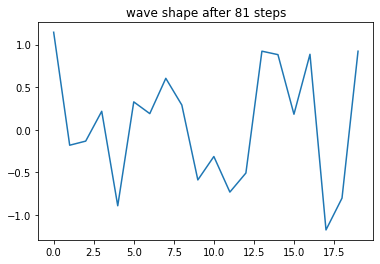

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_81/model_weights.tf
token ce loss:1.3359596286756656
time gaussian loss:1.4377680105523614
train loss:2.773727639228027


 88%|████████▊ | 82/93 [12:32<01:39,  9.09s/it]

Training Step: 82
event_types: [0, 2, 0, 2, 0, 2, 2, 3, 1, 3, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2]
mad_score: 0.6457
fid_score: 210.20379647316088
rule_score: 0.09475


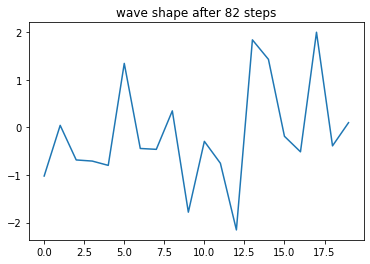

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_82/model_weights.tf
token ce loss:1.3326252482620484
time gaussian loss:1.4200026749214139
train loss:2.7526279231834625


 89%|████████▉ | 83/93 [12:41<01:30,  9.08s/it]

Training Step: 83
event_types: [3, 3, 2, 2, 1, 0, 2, 0, 2, 0, 1, 0, 2, 2, 3, 2, 3, 3, 2, 3]
mad_score: 0.646075
fid_score: 189.40049409659738
rule_score: 0.08975


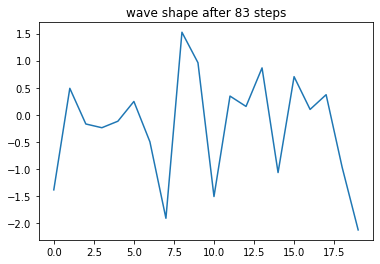

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_83/model_weights.tf
token ce loss:1.33447744493754
time gaussian loss:1.4318922317408977
train loss:2.766369676678438


 90%|█████████ | 84/93 [12:52<01:28,  9.82s/it]

Training Step: 84
event_types: [0, 0, 3, 3, 2, 2, 1, 3, 2, 2, 0, 2, 1, 2, 2, 3, 1, 1, 1, 0]
mad_score: 0.647525
fid_score: 201.6753020121955
rule_score: 0.094


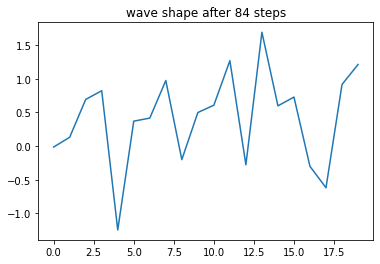

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_84/model_weights.tf
token ce loss:1.33170917419815
time gaussian loss:1.421511693481144
train loss:2.753220867679294


 91%|█████████▏| 85/93 [13:05<01:24, 10.62s/it]

Training Step: 85
event_types: [2, 0, 2, 1, 3, 1, 2, 3, 1, 1, 2, 2, 2, 3, 3, 1, 3, 2, 2, 1]
mad_score: 0.64635
fid_score: 201.59418014753493
rule_score: 0.08975


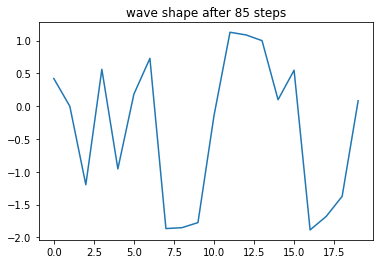

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_85/model_weights.tf
token ce loss:1.3280736715040733
time gaussian loss:1.4286638633018611
train loss:2.7567375348059344


 92%|█████████▏| 86/93 [13:17<01:18, 11.17s/it]

Training Step: 86
event_types: [1, 2, 2, 2, 0, 3, 3, 0, 2, 3, 2, 1, 1, 2, 0, 2, 1, 1, 0, 1]
mad_score: 0.6460125
fid_score: 209.57724817513366
rule_score: 0.09825


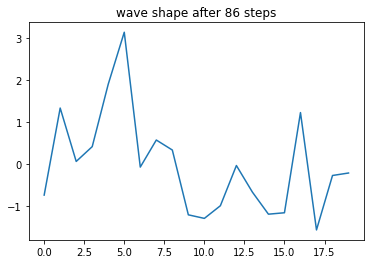

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_86/model_weights.tf
token ce loss:1.3360284968055245
time gaussian loss:1.4326135142592453
train loss:2.76864201106477


 94%|█████████▎| 87/93 [13:30<01:09, 11.55s/it]

Training Step: 87
event_types: [2, 3, 0, 0, 1, 0, 3, 2, 0, 2, 2, 1, 0, 3, 3, 0, 0, 2, 2, 1]
mad_score: 0.6487125
fid_score: 195.0571636345353
rule_score: 0.098


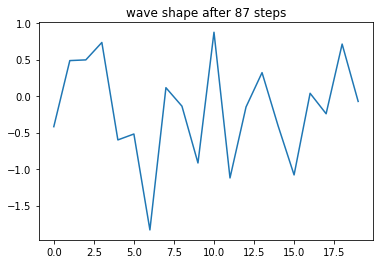

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_87/model_weights.tf
token ce loss:1.3293991965108822
time gaussian loss:1.4136189705706605
train loss:2.7430181670815426


 95%|█████████▍| 88/93 [13:42<00:59, 11.84s/it]

Training Step: 88
event_types: [1, 2, 0, 0, 1, 2, 1, 1, 0, 2, 3, 1, 0, 2, 2, 1, 0, 3, 2, 1]
mad_score: 0.644025
fid_score: 192.8152560812762
rule_score: 0.08725


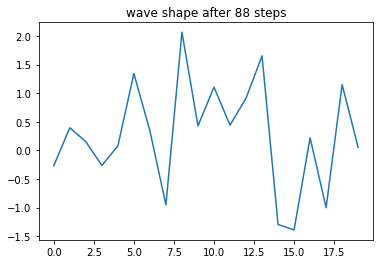

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_88/model_weights.tf
token ce loss:1.3305586708388506
time gaussian loss:1.417164753323538
train loss:2.7477234241623885


 96%|█████████▌| 89/93 [13:55<00:48, 12.03s/it]

Training Step: 89
event_types: [2, 2, 0, 3, 2, 0, 3, 2, 3, 2, 1, 3, 1, 2, 1, 3, 2, 0, 2, 0]
mad_score: 0.6448125
fid_score: 183.3757363861852
rule_score: 0.09475


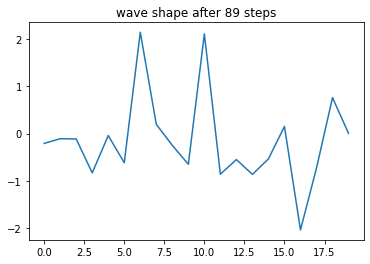

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_89/model_weights.tf
token ce loss:1.3350102526516843
time gaussian loss:1.4129575574601942
train loss:2.7479678101118785


 97%|█████████▋| 90/93 [14:07<00:36, 12.18s/it]

Training Step: 90
event_types: [0, 1, 1, 0, 1, 3, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 3]
mad_score: 0.6493875
fid_score: 197.91649930223414
rule_score: 0.091


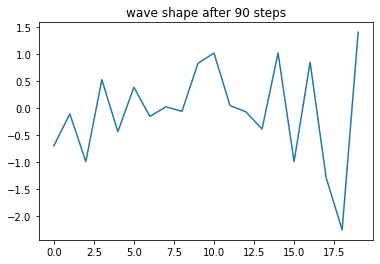

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_90/model_weights.tf
token ce loss:1.3298139699504155
time gaussian loss:1.4092933357843231
train loss:2.7391073057347386


 98%|█████████▊| 91/93 [14:16<00:22, 11.25s/it]

Training Step: 91
event_types: [1, 3, 3, 1, 0, 1, 2, 2, 1, 0, 2, 2, 3, 3, 1, 3, 0, 2, 2, 3]
mad_score: 0.641925
fid_score: 180.122575303264
rule_score: 0.09575


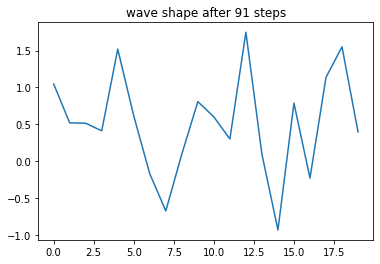

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_91/model_weights.tf
token ce loss:1.3344219049215356
time gaussian loss:1.4404106268941763
train loss:2.774832531815712


 99%|█████████▉| 92/93 [14:25<00:10, 10.60s/it]

Training Step: 92
event_types: [0, 2, 0, 2, 3, 0, 1, 1, 2, 3, 2, 0, 2, 1, 2, 3, 3, 2, 0, 2]
mad_score: 0.6478875
fid_score: 186.88508979963382
rule_score: 0.09075


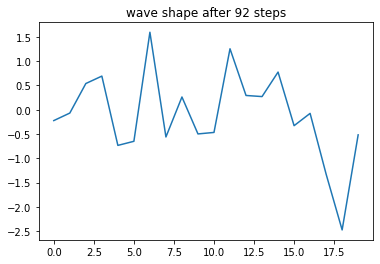

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_92/model_weights.tf
token ce loss:1.3292601702854283
time gaussian loss:1.426512884885951
train loss:2.755773055171379


100%|██████████| 93/93 [14:34<00:00,  9.41s/it]


In [29]:
for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)    
    
    _mad_score, _fid_score, _rule_score = track_training(step, pretrained_generator, pretrain_model_save_path, verbose=True, plot=True, save_D=False)
    pretrain_history['mad'].append(_mad_score)
    pretrain_history['fid'].append(_fid_score)
    pretrain_history['oracle'].append(_rule_score)
    
    gen_loss, token_loss, time_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_history['gen_loss'].append(gen_loss.numpy())
    pretrain_history['token_loss'].append(token_loss.numpy())
    pretrain_history['time_loss'].append(time_loss.numpy())
    
    step += 1

### show and save G pretrain stats

In [30]:
df_pretrain_stats = pd.DataFrame(pretrain_history)
df_pretrain_stats.index = pd.Index(range(step))
df_pretrain_stats

mad          fid   oracle  gen_loss  token_loss  time_loss
0   0.732587  2851.266483  0.09400  3.541014    1.382086   2.158928
1   0.732838  2620.999984  0.08975  3.426885    1.380641   2.046244
2   0.734625  2423.294769  0.08800  3.407818    1.381886   2.025932
3   0.734675  2226.562606  0.07725  3.298671    1.381505   1.917166
4   0.731662  2047.639049  0.08075  3.282792    1.382513   1.900279
..       ...          ...      ...       ...         ...        ...
88  0.644025   192.815256  0.08725  2.747723    1.330559   1.417165
89  0.644813   183.375736  0.09475  2.747968    1.335010   1.412958
90  0.649388   197.916499  0.09100  2.739107    1.329814   1.409293
91  0.641925   180.122575  0.09575  2.774833    1.334422   1.440411
92  0.647887   186.885090  0.09075  2.755773    1.329260   1.426513

[93 rows x 6 columns]

In [31]:
df_pretrain_stats.to_csv(os.path.join(pretrain_model_save_path, 'pretrain_stats.csv'), header=True, index=True)

### pre-train D and C

In [33]:
# take G pretrained for a few steps as the source of sequences
pretrained_generator_cutoff = build_G_mcc(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

curoff_G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_92/model_weights.tf'
pretrained_generator_cutoff.build(input_shape=((BATCH_SIZE, T, 1)))
pretrained_generator_cutoff.load_weights(curoff_G_save_path)

get_generation_metrics(pretrained_generator_cutoff)

{'mad': 0.6454625,
 'fid': 180.5050578482746,
 'oracle': 0.09475,
 'smad': 0.6454625}

In [34]:
N_fake_D = N_real_D = N_total_G 

# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs, all_token_logits, all_time_mu, all_time_sigma = generate_sequences_mcc(N_fake_D, pretrained_generator_cutoff, 
                                                                                                                          BATCH_SIZE, T, 
                                                                                                                          temperature=1, use_tlstm=True)

# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [35]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [36]:
pretrain_disc_loss_history = []
pretrain_critic_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)


pretrained_critic = build_critic(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [37]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_loss, critic_loss = pretrain_discriminator_and_critic(event_type_batch, time_delta_batch, labels, pretrained_discriminator, pretrained_critic, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_loss_history.append(disc_loss.numpy())
    pretrain_critic_loss_history.append(critic_loss.numpy())

  0%|          | 0/31 [00:00<?, ?it/s]

Training Step: 1
total discriminator loss:0.6966524357134137
total critic loss:0.0016221669695427369


  3%|▎         | 1/31 [00:01<00:51,  1.73s/it]

Training Step: 2
total discriminator loss:0.6915874740688804
total critic loss:0.005324334078489185


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

Training Step: 3
total discriminator loss:0.6791420693702616
total critic loss:0.001403628282604642


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

Training Step: 4
total discriminator loss:0.6690189962806098
total critic loss:0.005578542909339697


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

Training Step: 5
total discriminator loss:0.6596113576890865
total critic loss:0.010499724856541845


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

Training Step: 6
total discriminator loss:0.6464853197843652
total critic loss:0.009815392188419748


 19%|█▉        | 6/31 [00:09<00:37,  1.50s/it]

Training Step: 7
total discriminator loss:0.6283946480394683
total critic loss:0.009336125749431465


 23%|██▎       | 7/31 [00:10<00:34,  1.44s/it]

Training Step: 8
total discriminator loss:0.6050190952955288
total critic loss:0.009759450811981516


 26%|██▌       | 8/31 [00:12<00:33,  1.45s/it]

Training Step: 9
total discriminator loss:0.5753678961781536
total critic loss:0.018625043937164115


 29%|██▉       | 9/31 [00:13<00:32,  1.48s/it]

Training Step: 10
total discriminator loss:0.5389880990162241
total critic loss:0.028000552187678683


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

Training Step: 11
total discriminator loss:0.49477424414536775
total critic loss:0.047824214726203046


 35%|███▌      | 11/31 [00:16<00:30,  1.53s/it]

Training Step: 12
total discriminator loss:0.4582635436928161
total critic loss:0.07102723220736806


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

Training Step: 13
total discriminator loss:0.44548362657114227
total critic loss:0.09821686788522088


 42%|████▏     | 13/31 [00:19<00:27,  1.55s/it]

Training Step: 14
total discriminator loss:0.4759304500839125
total critic loss:0.09842862616833878


 45%|████▌     | 14/31 [00:21<00:26,  1.53s/it]

Training Step: 15
total discriminator loss:0.3861537920183531
total critic loss:0.11479796349983143


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

Training Step: 16
total discriminator loss:0.4031679998573644
total critic loss:0.11080958766750462


 52%|█████▏    | 16/31 [00:24<00:21,  1.42s/it]

Training Step: 17
total discriminator loss:0.3740893940293956
total critic loss:0.11570326927846228


 55%|█████▍    | 17/31 [00:25<00:20,  1.47s/it]

Training Step: 18
total discriminator loss:0.3470317469880151
total critic loss:0.11634344724198542


 58%|█████▊    | 18/31 [00:27<00:19,  1.50s/it]

Training Step: 19
total discriminator loss:0.2555192248978454
total critic loss:0.11205636894975726


 61%|██████▏   | 19/31 [00:28<00:18,  1.52s/it]

Training Step: 20
total discriminator loss:0.22520015552490472
total critic loss:0.12498361635137704


 65%|██████▍   | 20/31 [00:30<00:17,  1.57s/it]

Training Step: 21
total discriminator loss:0.2026226430146673
total critic loss:0.13965514275991922


 68%|██████▊   | 21/31 [00:32<00:15,  1.56s/it]

Training Step: 22
total discriminator loss:0.17059898232142745
total critic loss:0.136454038175654


 71%|███████   | 22/31 [00:33<00:14,  1.56s/it]

Training Step: 23
total discriminator loss:0.18186096524309098
total critic loss:0.17260556071172922


 74%|███████▍  | 23/31 [00:34<00:12,  1.51s/it]

Training Step: 24
total discriminator loss:0.15848673125508814
total critic loss:0.17046817381403798


 77%|███████▋  | 24/31 [00:36<00:10,  1.47s/it]

Training Step: 25
total discriminator loss:0.11269737072303619
total critic loss:0.19127022702382696


 81%|████████  | 25/31 [00:37<00:08,  1.43s/it]

Training Step: 26
total discriminator loss:0.11168526039765489
total critic loss:0.20297630503097172


 84%|████████▍ | 26/31 [00:39<00:07,  1.48s/it]

Training Step: 27
total discriminator loss:0.0783605299964271
total critic loss:0.19088786593755938


 87%|████████▋ | 27/31 [00:40<00:06,  1.50s/it]

Training Step: 28
total discriminator loss:0.043247376957492895
total critic loss:0.2055888215679688


 90%|█████████ | 28/31 [00:42<00:04,  1.53s/it]

Training Step: 29
total discriminator loss:0.06123482541868064
total critic loss:0.20786879504227543


 94%|█████████▎| 29/31 [00:43<00:03,  1.54s/it]

Training Step: 30
total discriminator loss:0.09720517690385673
total critic loss:0.19360276126115877


 97%|█████████▋| 30/31 [00:45<00:01,  1.54s/it]

Training Step: 31
total discriminator loss:0.17685855972527292
total critic loss:0.18835223045687466


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


In [38]:
pretrained_D_save_path = os.path.join(pretrain_model_save_path, 'D', 'model_weights.tf')
pretrained_discriminator.save_weights(pretrained_D_save_path)
print('Pretrained D saved to:', pretrained_D_save_path)

pretrained_C_save_path = os.path.join(pretrain_model_save_path, 'C', 'model_weights.tf')
pretrained_critic.save_weights(pretrained_C_save_path)
print('Pretrained C saved to:', pretrained_C_save_path)

Pretrained D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/D/model_weights.tf
Pretrained C saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/C/model_weights.tf


## Monte-Carlo with Critic  Traning

In [39]:
def train_generator_mcc(generator, discriminator, critic, batch_size, T, 
                        beta_token=1, beta_time=1, verbose=False, optimizer=Adam(lr=0.001),
                        use_advantage=False, temperature=1, use_tlstm=True):
    
    # clear critic states for a new batch
    critic.reset_states()
    
    with tf.GradientTape(persistent=True) as tape:     
                        
        gen_step_loss = []
        critic_step_loss = []

        G_sample_et, G_sample_ts, G_token_logits, G_time_mu, G_time_sigma = generate_sequences_mcc(batch_size, generator, batch_size, T, temperature, use_tlstm)
        
        true_return = discriminator([G_sample_et, G_sample_ts])
        
        # Monte-Carlo with Critic
        for i in range(T):  
            curr_state_et = G_sample_et[:, i:i+1, :]
            curr_state_ts = G_sample_ts[:, i:i+1, :]
            token_logits = G_token_logits[:, i, :]
            time_mu = G_time_mu[:, i, :]
            time_sigma = G_time_sigma[:, i, :]
            
            q_value = critic([curr_state_et, curr_state_ts])
            advantage = true_return - q_value
        
            # averge loss over batch at each rollout step: -E[log_prob * A]
            
            # Token
            p_token_all = tf.nn.softmax(token_logits)
            assert(p_token_all.shape == (batch_size, EVENT_VOCAB_DIM))
            
            chosen_ind = tf.argmax(curr_state_et, axis=2)
            assert(chosen_ind.shape == (batch_size, 1))
                                   
            p_token_chosen = tf.gather_nd(p_token_all, chosen_ind, batch_dims=1) # gather in vocab dim
            p_token_chosen = tf.reshape(p_token_chosen, (batch_size, 1))
            assert(p_token_chosen.shape == (batch_size, 1))
                                   
            token_entropy = -p_token_chosen * tf.math.log(p_token_chosen)
            assert(token_entropy.shape == (batch_size, 1))
            
            if use_advantage:
                token_policy_gradient_loss = -tf.reduce_mean(tf.math.log(p_token_chosen) * (advantage + beta_token * token_entropy))
            else:
                token_policy_gradient_loss = -tf.reduce_mean(tf.math.log(p_token_chosen) * (q_value + beta_token * token_entropy))
            
            # Time
            time_dist = tfp.distributions.Normal(time_mu, time_sigma)
            time_gaussian_log = time_dist.log_prob(tf.reshape(curr_state_ts, (batch_size, 1)))
            assert(time_gaussian_log.shape == (batch_size, 1))
            
            time_entropy = 0.5 * tf.math.log(2*np.pi*np.e*tf.math.square(time_sigma))
            assert(time_entropy.shape == (batch_size, 1))
            
            if use_advantage:
                time_policy_gradient_loss = -tf.reduce_mean(time_gaussian_log * (advantage + beta_time * time_entropy))
            else:
                time_policy_gradient_loss = -tf.reduce_mean(time_gaussian_log * (q_value + beta_time * time_entropy))
            
            gen_step_loss.append(token_policy_gradient_loss + time_policy_gradient_loss)
                        
            critic_mse_loss = tf.reduce_mean(tf.keras.losses.MSE(true_return, q_value))
            critic_step_loss.append(critic_mse_loss)
            
        generator_loss = tf.reduce_mean(gen_step_loss)
        critic_loss = tf.reduce_mean(critic_step_loss)
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('last advantage:{}'.format(advantage[0,:]))
        print('last log token-prob:{}'.format(tf.math.log(p_token_chosen[0,:])))
        print('last time gaussian:{}'.format(time_gaussian_log[0,:]))
        print('last token entropy:{}'.format(token_entropy[0,:]))
        print('last time entropy:{}'.format(time_entropy[0,:]))
        print('critic loss:{}'.format(critic_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    # update critic
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return generator_loss, critic_loss


def train_discriminator_mcc(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))
    fake_labels = tf.zeros((batch_size//2, 1))
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts, _, _, _ = generate_sequences_mcc(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [40]:
G = build_G_mcc(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(curoff_G_save_path)
print('Loaded G from:', curoff_G_save_path)

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(pretrained_D_save_path)
print('Loaded D from:', pretrained_D_save_path)

critic = build_critic(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

critic.build(input_shape=((BATCH_SIZE, T, 1)))
critic.load_weights(pretrained_C_save_path)
print('Loaded C from:', pretrained_C_save_path)

Loaded G from: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_92/model_weights.tf
Loaded D from: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/D/model_weights.tf
Loaded C from: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/C/model_weights.tf


In [41]:
train_history = defaultdict(list)

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
train_model_save_path = os.path.join(model_save_dir, 'train', now_str)
print(train_model_save_path)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47


In [42]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

In [43]:
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)
print(_TOTAL_STEPS)

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

beta_token = 1
beta_time = 10

1562


  0%|          | 0/1562 [00:00<?, ?it/s]

Training Step: 0
event_types: [2, 1, 2, 1, 3, 3, 2, 0, 2, 0, 0, 0, 1, 1, 2, 3, 2, 2, 1, 1]
mad_score: 0.6456875
fid_score: 188.5873461989204
rule_score: 0.091


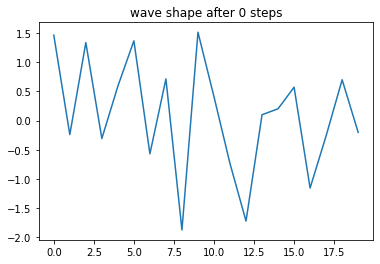

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_0/model_weights.tf
generator loss:19.498273420655156
last advantage:[-0.36137803]
last log token-prob:[-1.08834155]
last time gaussian:[-0.82965004]
last token entropy:[0.36652574]
last time entropy:[1.30789028]
critic loss:0.24279266020763268
-----------------------
total discriminator loss:0.541457055094617
average true return:0.4774600892402055
-----------------------


  0%|          | 1/1562 [00:16<6:58:14, 16.08s/it]

Training Step: 1
generator loss:18.80209865419612
last advantage:[-0.25431199]
last log token-prob:[-1.64938095]
last time gaussian:[-0.95723344]
last token entropy:[0.31695961]
last time entropy:[1.43563153]
critic loss:0.23485481392328297
-----------------------
total discriminator loss:0.5256475584959504
average true return:0.4771302393960517
-----------------------


  0%|          | 2/1562 [00:19<3:51:45,  8.91s/it]

Training Step: 2
generator loss:18.42048456111588
last advantage:[-0.47553762]
last log token-prob:[-1.47508717]
last time gaussian:[-0.84682088]
last token entropy:[0.33743915]
last time entropy:[1.34217441]
critic loss:0.22430070603659238
-----------------------
total discriminator loss:0.4683508582550415
average true return:0.48892840900766
-----------------------


  0%|          | 3/1562 [00:23<2:50:52,  6.58s/it]

Training Step: 3
generator loss:17.49560010558286
last advantage:[-0.42162644]
last log token-prob:[-1.5936489]
last time gaussian:[-2.85264293]
last token entropy:[0.32380215]
last time entropy:[1.43210712]
critic loss:0.19972417023229025
-----------------------
total discriminator loss:0.42135899228232
average true return:0.5035440819308569
-----------------------


  0%|          | 4/1562 [00:27<2:25:26,  5.60s/it]

Training Step: 4
generator loss:16.906753028880452
last advantage:[-0.48407561]
last log token-prob:[-1.17602601]
last time gaussian:[-1.49457222]
last token entropy:[0.36280672]
last time entropy:[1.44565639]
critic loss:0.2080126968512827
-----------------------
total discriminator loss:0.4548476530390274
average true return:0.4711425061955239
-----------------------


  0%|          | 5/1562 [00:31<2:11:02,  5.05s/it]

Training Step: 5
event_types: [0, 0, 1, 0, 2, 0, 0, 3, 1, 2, 0, 3, 3, 2, 3, 0, 3, 1, 1, 1]
mad_score: 0.646075
fid_score: 425.2242953158792
rule_score: 0.10775


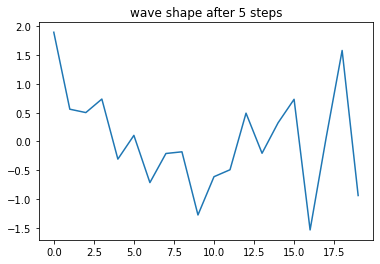

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_5/model_weights.tf
generator loss:16.638634945995555
last advantage:[-0.29022076]
last log token-prob:[-1.30422494]
last time gaussian:[-1.22216985]
last token entropy:[0.35394421]
last time entropy:[1.39618191]
critic loss:0.19158523365170751
-----------------------
total discriminator loss:0.4225340256941572
average true return:0.47807907083755463
-----------------------


  0%|          | 6/1562 [00:47<3:41:55,  8.56s/it]

Training Step: 6
generator loss:15.739662036528637
last advantage:[-0.22624505]
last log token-prob:[-1.48163483]
last time gaussian:[-0.97954842]
last token entropy:[0.33672499]
last time entropy:[1.35135845]
critic loss:0.19716840004024366
-----------------------
total discriminator loss:0.4432773544013849
average true return:0.4651006878161575
-----------------------


  0%|          | 7/1562 [00:51<3:04:22,  7.11s/it]

Training Step: 7
generator loss:15.099770838519603
last advantage:[-0.19044906]
last log token-prob:[-0.82090943]
last time gaussian:[-0.58223126]
last token entropy:[0.36122584]
last time entropy:[1.0365858]
critic loss:0.16896805321306876
-----------------------
total discriminator loss:2.9711992259091673
average true return:0.46848455829267077
-----------------------


  1%|          | 8/1562 [00:55<2:39:29,  6.16s/it]

Training Step: 8
generator loss:14.09874233049482
last advantage:[-0.1478285]
last log token-prob:[-1.73764117]
last time gaussian:[-0.48777839]
last token entropy:[0.30571175]
last time entropy:[0.98163942]
critic loss:0.15675259879048714
-----------------------
total discriminator loss:0.4448140498854825
average true return:0.44707322968289676
-----------------------


  1%|          | 9/1562 [00:59<2:19:06,  5.37s/it]

Training Step: 9
generator loss:14.013761398370075
last advantage:[-0.2420421]
last log token-prob:[-1.29675957]
last time gaussian:[-0.86971423]
last token entropy:[0.35455526]
last time entropy:[1.24270142]
critic loss:0.1428337916341318
-----------------------
total discriminator loss:0.42139154307044335
average true return:0.46947814166069546
-----------------------


  1%|          | 10/1562 [01:03<2:08:15,  4.96s/it]

Training Step: 10
event_types: [2, 1, 3, 2, 2, 0, 1, 2, 1, 0, 2, 0, 3, 0, 3, 2, 0, 2, 3, 2]
mad_score: 0.6427625
fid_score: 937.777147386071
rule_score: 0.12875


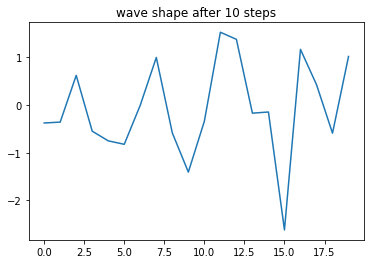

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_10/model_weights.tf
generator loss:13.09589528203308
last advantage:[-0.27966134]
last log token-prob:[-0.83481519]
last time gaussian:[-0.38659096]
last token entropy:[0.36227195]
last time entropy:[0.76586277]
critic loss:0.13585530429414455
-----------------------
total discriminator loss:0.4375592763283681
average true return:0.4338634393988545
-----------------------


  1%|          | 11/1562 [01:18<3:33:32,  8.26s/it]

Training Step: 11
generator loss:12.56756594729462
last advantage:[-0.39778759]
last log token-prob:[-1.66538013]
last time gaussian:[-0.41642221]
last token entropy:[0.31495462]
last time entropy:[0.91078493]
critic loss:0.1245107525364763
-----------------------


  1%|          | 12/1562 [01:22<2:59:21,  6.94s/it]

total discriminator loss:0.5110907012722596
average true return:0.4628415589765129
-----------------------
Training Step: 12
generator loss:11.800964571351424
last advantage:[-0.55134533]
last log token-prob:[-1.67224458]
last time gaussian:[-0.56206832]
last token entropy:[0.31408934]
last time entropy:[1.03187504]
critic loss:0.10951106535026645
-----------------------
total discriminator loss:0.4170087468413012
average true return:0.4502525067920401
-----------------------


  1%|          | 13/1562 [01:26<2:33:42,  5.95s/it]

Training Step: 13
generator loss:11.169683470622033
last advantage:[-0.25829778]
last log token-prob:[-1.56957893]
last time gaussian:[-0.68634757]
last token entropy:[0.32668086]
last time entropy:[1.14142355]
critic loss:0.10177253373033546
-----------------------
total discriminator loss:0.4546851591008378
average true return:0.4551961672956475
-----------------------


  1%|          | 14/1562 [01:30<2:19:07,  5.39s/it]

Training Step: 14
generator loss:10.584607921503668
last advantage:[-0.15269134]
last log token-prob:[-1.85971313]
last time gaussian:[-0.29126301]
last token entropy:[0.2895895]
last time entropy:[0.78905352]
critic loss:0.09426272149708734
-----------------------
total discriminator loss:0.40153627425117994
average true return:0.4580098353622296
-----------------------


  1%|          | 15/1562 [01:34<2:09:00,  5.00s/it]

Training Step: 15
event_types: [1, 1, 3, 3, 0, 1, 1, 0, 2, 2, 1, 2, 3, 0, 1, 2, 1, 0, 0, 1]
mad_score: 0.6427125
fid_score: 1724.7442418261155
rule_score: 0.16125


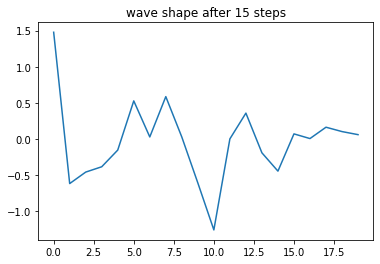

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_15/model_weights.tf
generator loss:10.013147099696555
last advantage:[-0.32447707]
last log token-prob:[-1.33612026]
last time gaussian:[-0.62869217]
last token entropy:[0.35121729]
last time entropy:[1.02570769]
critic loss:0.09335648362937281
-----------------------


  1%|          | 16/1562 [01:50<3:28:10,  8.08s/it]

total discriminator loss:0.4329019008470676
average true return:0.4872422865774937
-----------------------
Training Step: 16
generator loss:9.420229576815895
last advantage:[-0.04723567]
last log token-prob:[-1.32413194]
last time gaussian:[-1.28928769]
last token entropy:[0.35226384]
last time entropy:[1.07437486]
critic loss:0.08652401699945153
-----------------------
total discriminator loss:0.4169267122821001
average true return:0.47832525064163034
-----------------------


  1%|          | 17/1562 [01:54<2:57:17,  6.89s/it]

Training Step: 17
generator loss:8.779987312481072
last advantage:[-0.19645106]
last log token-prob:[-1.08063442]
last time gaussian:[-0.67499547]
last token entropy:[0.36674587]
last time entropy:[0.72084467]
critic loss:0.08841592039588056
-----------------------
total discriminator loss:0.44047861888358586
average true return:0.46812216011785024
-----------------------


  1%|          | 18/1562 [01:58<2:36:00,  6.06s/it]

Training Step: 18
generator loss:8.239411436591519
last advantage:[-0.14560072]
last log token-prob:[-1.56777403]
last time gaussian:[-1.00434013]
last token entropy:[0.32689468]
last time entropy:[0.61622969]
critic loss:0.07821938872314275
-----------------------


  1%|          | 19/1562 [02:02<2:18:37,  5.39s/it]

total discriminator loss:0.4261170354962641
average true return:0.49850950734325716
-----------------------
Training Step: 19
generator loss:7.816736763281208
last advantage:[-0.17603613]
last log token-prob:[-1.57369678]
last time gaussian:[-0.12762415]
last token entropy:[0.32619194]
last time entropy:[0.61307977]
critic loss:0.06731678534915328
-----------------------
total discriminator loss:0.39288295346539226
average true return:0.48362413458881265
-----------------------


  1%|▏         | 20/1562 [02:06<2:07:28,  4.96s/it]

Training Step: 20
event_types: [1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 0, 3, 2, 1, 2, 3, 3]
mad_score: 0.63915
fid_score: 2709.3059135053772
rule_score: 0.19


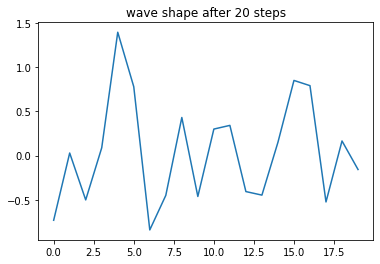

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_20/model_weights.tf
generator loss:7.0151364545643755
last advantage:[-0.11308667]
last log token-prob:[-1.85830871]
last time gaussian:[-2.98513242]
last token entropy:[0.28977749]
last time entropy:[0.60319058]
critic loss:0.06936547296890842
-----------------------
total discriminator loss:0.43371443892984135
average true return:0.5124956659913114
-----------------------


  1%|▏         | 21/1562 [02:21<3:29:40,  8.16s/it]

Training Step: 21
generator loss:6.705597259000742
last advantage:[0.14178505]
last log token-prob:[-1.74646012]
last time gaussian:[-0.86724255]
last token entropy:[0.30456548]
last time entropy:[0.61821323]
critic loss:0.0624734891615192
-----------------------


  1%|▏         | 22/1562 [02:25<2:57:12,  6.90s/it]

total discriminator loss:0.4634604491354043
average true return:0.5017801328702122
-----------------------
Training Step: 22
generator loss:6.119641155128124
last advantage:[-0.07714024]
last log token-prob:[-1.46047431]
last time gaussian:[0.02205566]
last token entropy:[0.33901428]
last time entropy:[0.4773757]
critic loss:0.06280089125454931
-----------------------
total discriminator loss:0.38658351109484235
average true return:0.4988906966454774
-----------------------


  1%|▏         | 23/1562 [02:29<2:32:24,  5.94s/it]

Training Step: 23
generator loss:5.605306916795615
last advantage:[-0.06019149]
last log token-prob:[-0.94576805]
last time gaussian:[0.25055118]
last token entropy:[0.36731849]
last time entropy:[0.18494226]
critic loss:0.05925918919867573
-----------------------
total discriminator loss:0.45225214487987814
average true return:0.5182282815571354
-----------------------


  2%|▏         | 24/1562 [02:33<2:18:30,  5.40s/it]

Training Step: 24
generator loss:5.328174045383652
last advantage:[-0.01988953]
last log token-prob:[-1.41044077]
last time gaussian:[-0.49816807]
last token entropy:[0.34419789]
last time entropy:[0.47115066]
critic loss:0.05377039122778391
-----------------------
total discriminator loss:0.4414776768368339
average true return:0.513766766670152
-----------------------


  2%|▏         | 25/1562 [02:37<2:08:32,  5.02s/it]

Training Step: 25
event_types: [3, 3, 2, 2, 1, 2, 3, 1, 2, 2, 1, 3, 2, 1, 0, 3, 1, 0, 2, 2]
mad_score: 0.635125
fid_score: 3720.5951809074772
rule_score: 0.2415


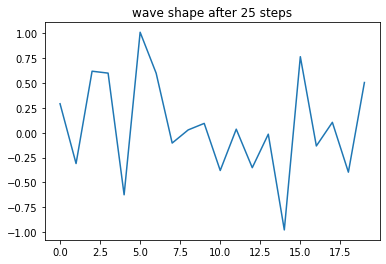

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_25/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_25/model_weights.tf
generator loss:4.789085151111783
last advantage:[-0.16225284]
last log token-prob:[-1.49814442]
last time gaussian:[-0.06633901]
last token entropy:[0.33490207]
last time entropy:[0.53776947]
critic loss:0.058254904863095244
-----------------------
total discriminator loss:0.4148744745033771
average true return:0.5077081735587281
-----------------------


  2%|▏         | 26/1562 [02:53<3:28:30,  8.14s/it]

Training Step: 26
generator loss:4.566342880220979
last advantage:[0.12876226]
last log token-prob:[-1.79144572]
last time gaussian:[-0.36403871]
last token entropy:[0.29866798]
last time entropy:[0.54846083]
critic loss:0.053923857756881674
-----------------------
total discriminator loss:0.4198170010917457
average true return:0.5271844424762486
-----------------------


  2%|▏         | 27/1562 [02:57<2:57:43,  6.95s/it]

Training Step: 27
generator loss:4.240746955309288
last advantage:[-0.06859358]
last log token-prob:[-1.21460426]
last time gaussian:[-0.19737514]
last token entropy:[0.36052789]
last time entropy:[0.18750183]
critic loss:0.055952362127900376
-----------------------
total discriminator loss:0.4269680892865997
average true return:0.5371105642777856
-----------------------


  2%|▏         | 28/1562 [03:01<2:36:00,  6.10s/it]

Training Step: 28
generator loss:3.9044072661488345
last advantage:[-0.06578517]
last log token-prob:[-1.41202279]
last time gaussian:[-0.06864913]
last token entropy:[0.34403926]
last time entropy:[0.4058494]
critic loss:0.05477706217198921
-----------------------


  2%|▏         | 29/1562 [03:05<2:17:54,  5.40s/it]

total discriminator loss:0.4565273890768799
average true return:0.5288685559794879
-----------------------
Training Step: 29
generator loss:3.5071102077678775
last advantage:[-0.06262075]
last log token-prob:[-1.80671031]
last time gaussian:[0.08865599]
last token entropy:[0.2966499]
last time entropy:[0.16292543]
critic loss:0.052569463553439756
-----------------------
total discriminator loss:0.42293557143431193
average true return:0.5187863829686805
-----------------------


  2%|▏         | 30/1562 [03:09<2:07:19,  4.99s/it]

Training Step: 30
event_types: [2, 1, 2, 2, 1, 3, 0, 1, 1, 0, 2, 3, 2, 2, 0, 2, 0, 2, 2, 3]
mad_score: 0.6299625
fid_score: 4689.769310029311
rule_score: 0.2855


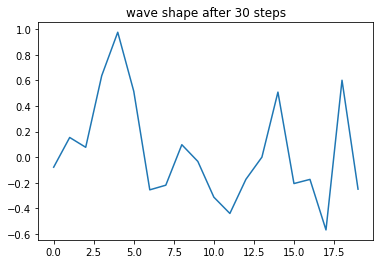

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_30/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_30/model_weights.tf
generator loss:3.3538387859471817
last advantage:[-0.05821749]
last log token-prob:[-1.34269036]
last time gaussian:[0.30313722]
last token entropy:[0.35063306]
last time entropy:[0.19520084]
critic loss:0.051525236237391955
-----------------------
total discriminator loss:0.4205363571514253
average true return:0.5187381199328416
-----------------------


  2%|▏         | 31/1562 [03:24<3:29:33,  8.21s/it]

Training Step: 31
generator loss:3.1913391714665615
last advantage:[-0.04715719]
last log token-prob:[-1.38365588]
last time gaussian:[0.15771457]
last token entropy:[0.34682786]
last time entropy:[0.15158187]
critic loss:0.05327971710612143
-----------------------
total discriminator loss:0.3849715223682538
average true return:0.5205662814816917
-----------------------


  2%|▏         | 32/1562 [03:28<2:56:54,  6.94s/it]

Training Step: 32
generator loss:2.815142707541359
last advantage:[-0.08555779]
last log token-prob:[-1.42499981]
last time gaussian:[0.65580426]
last token entropy:[0.34272458]
last time entropy:[-0.16874556]
critic loss:0.05233870219952445
-----------------------
total discriminator loss:0.4321233852653984
average true return:0.5156893428365337
-----------------------


  2%|▏         | 33/1562 [03:32<2:32:05,  5.97s/it]

Training Step: 33
generator loss:2.899489854047341
last advantage:[-0.12549159]
last log token-prob:[-0.88998321]
last time gaussian:[-2.62745705]
last token entropy:[0.36548286]
last time entropy:[0.04850861]
critic loss:0.053719057968836956
-----------------------
total discriminator loss:0.4198880196450404
average true return:0.5317564269236126
-----------------------


  2%|▏         | 34/1562 [03:36<2:17:54,  5.42s/it]

Training Step: 34
generator loss:2.508571536548915
last advantage:[-0.16947388]
last log token-prob:[-0.90674401]
last time gaussian:[0.40069946]
last token entropy:[0.36617676]
last time entropy:[-0.15237088]
critic loss:0.053148602719190086
-----------------------
total discriminator loss:0.41139270058852456
average true return:0.49323816748538796
-----------------------


  2%|▏         | 35/1562 [03:40<2:07:47,  5.02s/it]

Training Step: 35
event_types: [3, 1, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 1, 3, 0, 2, 0, 0, 3]
mad_score: 0.6214375
fid_score: 5525.264200678069
rule_score: 0.32125


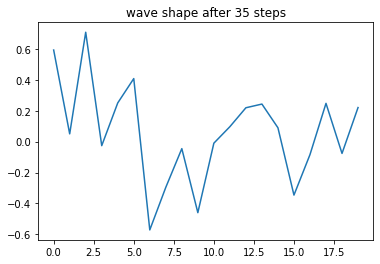

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_35/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_35/model_weights.tf
generator loss:2.5514235960552383
last advantage:[-0.08867814]
last log token-prob:[-1.53875933]
last time gaussian:[0.51026399]
last token entropy:[0.33029045]
last time entropy:[-0.16077148]
critic loss:0.051536263097067415
-----------------------
total discriminator loss:0.37818257296517743
average true return:0.5047447604469711
-----------------------


  2%|▏         | 36/1562 [03:56<3:26:51,  8.13s/it]

Training Step: 36
generator loss:2.432070283690257
last advantage:[-0.0467754]
last log token-prob:[-1.02536271]
last time gaussian:[0.5026596]
last token entropy:[0.3677631]
last time entropy:[-0.21881978]
critic loss:0.05100721047522853
-----------------------
total discriminator loss:0.4205083832931201
average true return:0.5025995325975914
-----------------------


  2%|▏         | 37/1562 [04:00<2:56:15,  6.93s/it]

Training Step: 37
generator loss:2.469420792424434
last advantage:[0.09372797]
last log token-prob:[-1.51967051]
last time gaussian:[0.75618766]
last token entropy:[0.33247954]
last time entropy:[-0.25659343]
critic loss:0.04823316765998856
-----------------------
total discriminator loss:0.4581274323854387
average true return:0.5128249509897369
-----------------------


  2%|▏         | 38/1562 [04:04<2:34:40,  6.09s/it]

Training Step: 38
generator loss:2.5943131998643403
last advantage:[-0.05763402]
last log token-prob:[-1.34790749]
last time gaussian:[0.89518666]
last token entropy:[0.35016384]
last time entropy:[-0.3959443]
critic loss:0.05285187654043472
-----------------------
total discriminator loss:0.38671131299158235
average true return:0.49504971529219655
-----------------------


  2%|▏         | 39/1562 [04:08<2:16:30,  5.38s/it]

Training Step: 39
generator loss:2.507765920293796
last advantage:[-0.05988977]
last log token-prob:[-0.88518261]
last time gaussian:[0.80404585]
last token entropy:[0.3652607]
last time entropy:[-0.3528455]
critic loss:0.052650095763816
-----------------------
total discriminator loss:0.37371583130654273
average true return:0.48333690482917524
-----------------------


  3%|▎         | 40/1562 [04:12<2:06:04,  4.97s/it]

Training Step: 40
event_types: [3, 2, 1, 0, 2, 1, 0, 0, 2, 3, 1, 3, 3, 1, 0, 2, 0, 2, 2, 1]
mad_score: 0.6171
fid_score: 6138.744574719714
rule_score: 0.35125


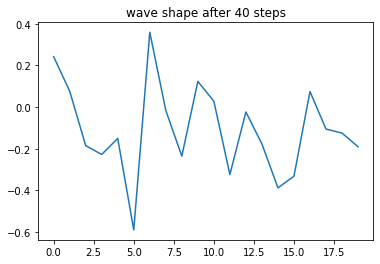

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_40/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_40/model_weights.tf
generator loss:2.475925438441891
last advantage:[-0.05921673]
last log token-prob:[-1.02737474]
last time gaussian:[0.32594853]
last token entropy:[0.36774409]
last time entropy:[-0.24111216]
critic loss:0.050520635086569746
-----------------------
total discriminator loss:0.3840935484224528
average true return:0.47600460020180657
-----------------------


  3%|▎         | 41/1562 [04:28<3:29:04,  8.25s/it]

Training Step: 41
generator loss:2.4992820810998224
last advantage:[0.02712022]
last log token-prob:[-1.57573697]
last time gaussian:[0.18894014]
last token entropy:[0.32594915]
last time entropy:[-0.33440209]
critic loss:0.050704772675673616
-----------------------
total discriminator loss:0.39214773837859906
average true return:0.4768856981816456
-----------------------


  3%|▎         | 42/1562 [04:32<2:56:22,  6.96s/it]

Training Step: 42
generator loss:2.373620170137074
last advantage:[-0.01584067]
last log token-prob:[-1.3161678]
last time gaussian:[-0.60147545]
last token entropy:[0.35294485]
last time entropy:[-0.25287088]
critic loss:0.054497663529324655
-----------------------
total discriminator loss:0.4101729778534801
average true return:0.47452831129457923
-----------------------


  3%|▎         | 43/1562 [04:35<2:31:53,  6.00s/it]

Training Step: 43
generator loss:2.3430797177312708
last advantage:[-0.09680846]
last log token-prob:[-1.12136499]
last time gaussian:[-1.12486312]
last token entropy:[0.36537966]
last time entropy:[-0.16694302]
critic loss:0.051230216570283774
-----------------------
total discriminator loss:0.36574655979928383
average true return:0.4743939587558232
-----------------------


  3%|▎         | 44/1562 [04:39<2:17:34,  5.44s/it]

Training Step: 44
generator loss:2.517343864573848
last advantage:[-0.02703158]
last log token-prob:[-1.49596238]
last time gaussian:[0.86285865]
last token entropy:[0.33514478]
last time entropy:[-0.44210078]
critic loss:0.051081163258067566
-----------------------
total discriminator loss:0.39814063262926186
average true return:0.4822655930565376
-----------------------


  3%|▎         | 45/1562 [04:43<2:07:19,  5.04s/it]

Training Step: 45
event_types: [1, 1, 1, 2, 3, 1, 0, 0, 3, 2, 2, 2, 2, 3, 2, 2, 0, 3, 2, 2]
mad_score: 0.608325
fid_score: 6427.865757058386
rule_score: 0.359


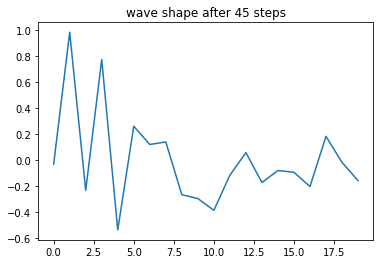

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_45/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_45/model_weights.tf
generator loss:2.4533536873486135
last advantage:[-0.02145711]
last log token-prob:[-2.03876409]
last time gaussian:[0.68552803]
last token entropy:[0.26542571]
last time entropy:[-0.30276464]
critic loss:0.05089145142429789
-----------------------
total discriminator loss:0.35882062693779104
average true return:0.49425431794074853
-----------------------


  3%|▎         | 46/1562 [04:59<3:26:08,  8.16s/it]

Training Step: 46
generator loss:2.358252970707384
last advantage:[0.31346453]
last log token-prob:[-1.96181531]
last time gaussian:[0.49952352]
last token entropy:[0.27583702]
last time entropy:[-0.30651604]
critic loss:0.0524146658260944
-----------------------
total discriminator loss:2.5608808235967304
average true return:0.47396969657834975
-----------------------


  3%|▎         | 47/1562 [05:03<2:55:11,  6.94s/it]

Training Step: 47
generator loss:2.269663703142629
last advantage:[-0.00460719]
last log token-prob:[-1.4325778]
last time gaussian:[0.18707087]
last token entropy:[0.34194604]
last time entropy:[-0.35896105]
critic loss:0.04697682155818255
-----------------------
total discriminator loss:0.361468375901676
average true return:0.46303055649647845
-----------------------


  3%|▎         | 48/1562 [05:07<2:33:31,  6.08s/it]

Training Step: 48
generator loss:2.3548274361598374
last advantage:[-0.04184475]
last log token-prob:[-1.41310329]
last time gaussian:[0.41455684]
last token entropy:[0.3439307]
last time entropy:[-0.28074939]
critic loss:0.04540243046588758
-----------------------


  3%|▎         | 49/1562 [05:11<2:15:22,  5.37s/it]

total discriminator loss:0.40825114840536725
average true return:0.46664223881408995
-----------------------
Training Step: 49
generator loss:2.2587098639279892
last advantage:[0.09210244]
last log token-prob:[-1.89285498]
last time gaussian:[0.59035518]
last token entropy:[0.28514179]
last time entropy:[-0.14075861]
critic loss:0.04378310501538744
-----------------------
total discriminator loss:0.3623477112101108
average true return:0.4770119728764993
-----------------------


  3%|▎         | 50/1562 [05:15<2:05:09,  4.97s/it]

Training Step: 50
event_types: [3, 3, 3, 2, 3, 3, 0, 2, 1, 0, 2, 2, 1, 3, 1, 2, 2, 2, 1, 0]
mad_score: 0.600175
fid_score: 6436.813492884077
rule_score: 0.3655


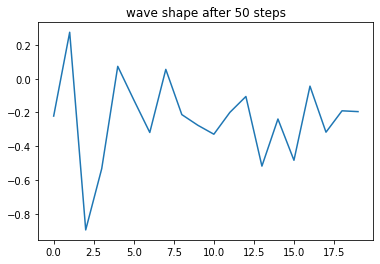

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_50/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_50/model_weights.tf
generator loss:2.1956530623834376
last advantage:[-0.01143154]
last log token-prob:[-1.32910109]
last time gaussian:[0.01810346]
last token entropy:[0.35183314]
last time entropy:[-0.18279158]
critic loss:0.042402561418350096
-----------------------
total discriminator loss:2.383813533629494
average true return:0.472431166423826
-----------------------


  3%|▎         | 51/1562 [05:31<3:28:12,  8.27s/it]

Training Step: 51
generator loss:2.2924230324572186
last advantage:[-0.02681993]
last log token-prob:[-1.38139117]
last time gaussian:[0.12255095]
last token entropy:[0.34704526]
last time entropy:[-0.39832069]
critic loss:0.04073674373686569
-----------------------


  3%|▎         | 52/1562 [05:35<2:55:16,  6.96s/it]

total discriminator loss:0.39081776255475276
average true return:0.45701202254144035
-----------------------
Training Step: 52
generator loss:2.0612381343788977
last advantage:[-0.02721748]
last log token-prob:[-0.9217006]
last time gaussian:[0.74514031]
last token entropy:[0.36669111]
last time entropy:[-0.24603441]
critic loss:0.03985201638758294
-----------------------


  3%|▎         | 53/1562 [05:38<2:29:23,  5.94s/it]

total discriminator loss:0.4039864207473517
average true return:0.47558928264938516
-----------------------
Training Step: 53
generator loss:2.1411509071300294
last advantage:[0.12258375]
last log token-prob:[-1.35196116]
last time gaussian:[0.42300503]
last token entropy:[0.34979608]
last time entropy:[-0.26679814]
critic loss:0.038414858729477565
-----------------------


  3%|▎         | 54/1562 [05:41<2:06:26,  5.03s/it]

total discriminator loss:0.3817657858287811
average true return:0.4619777028732029
-----------------------
Training Step: 54
generator loss:2.0800709553300094
last advantage:[0.35092353]
last log token-prob:[-1.32407529]
last time gaussian:[-1.91231853]
last token entropy:[0.35226873]
last time entropy:[-0.1068021]
critic loss:0.0358893272674497
-----------------------


  4%|▎         | 55/1562 [05:44<1:50:16,  4.39s/it]

total discriminator loss:0.3970108100124729
average true return:0.47755004114541916
-----------------------
Training Step: 55
event_types: [3, 3, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 3, 3, 3, 2, 3, 1, 0, 2]
mad_score: 0.5876875
fid_score: 6321.942108758255
rule_score: 0.37675


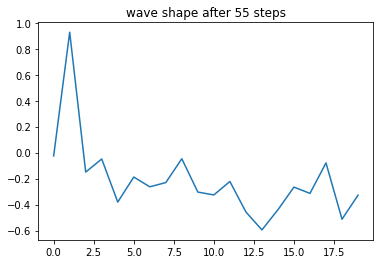

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_55/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_55/model_weights.tf
generator loss:1.959743423951584
last advantage:[-0.01602052]
last log token-prob:[-0.77456131]
last time gaussian:[0.52452223]
last token entropy:[0.3569999]
last time entropy:[-0.17552514]
critic loss:0.0342826516784947
-----------------------


  4%|▎         | 56/1562 [05:56<2:44:00,  6.53s/it]

total discriminator loss:0.3713386353395162
average true return:0.48300872867912925
-----------------------
Training Step: 56
generator loss:1.9098064156850096
last advantage:[0.2358201]
last log token-prob:[-1.96625564]
last time gaussian:[0.45950547]
last token entropy:[0.27523649]
last time entropy:[-0.2621428]
critic loss:0.037902059178736215
-----------------------


  4%|▎         | 57/1562 [05:59<2:16:40,  5.45s/it]

total discriminator loss:1.9667042341168541
average true return:0.49648980077145755
-----------------------
Training Step: 57
generator loss:1.88012814059228
last advantage:[0.19518743]
last log token-prob:[-1.43764813]
last time gaussian:[0.3484903]
last token entropy:[0.34142078]
last time entropy:[-0.05902186]
critic loss:0.03841979137861042
-----------------------


  4%|▎         | 58/1562 [06:01<1:57:32,  4.69s/it]

total discriminator loss:0.40879968522512744
average true return:0.4912611400105312
-----------------------
Training Step: 58
generator loss:1.7803319439297276
last advantage:[0.02012118]
last log token-prob:[-1.46178156]
last time gaussian:[0.70942488]
last token entropy:[0.33887444]
last time entropy:[-0.23954252]
critic loss:0.03676533513147057
-----------------------


  4%|▍         | 59/1562 [06:04<1:44:02,  4.15s/it]

total discriminator loss:0.3624087061555736
average true return:0.4861624694771699
-----------------------
Training Step: 59
generator loss:1.8597770706535468
last advantage:[0.04334827]
last log token-prob:[-1.08881067]
last time gaussian:[0.2630714]
last token entropy:[0.36651175]
last time entropy:[0.14025002]
critic loss:0.042692424671731524
-----------------------


  4%|▍         | 60/1562 [06:07<1:34:37,  3.78s/it]

total discriminator loss:0.4313455621795456
average true return:0.5080766874244492
-----------------------
Training Step: 60
event_types: [1, 0, 1, 2, 3, 2, 1, 1, 3, 2, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2]
mad_score: 0.57955
fid_score: 6159.350312323573
rule_score: 0.39375


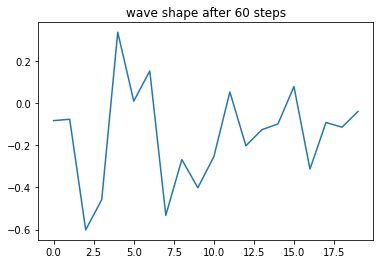

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_60/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_60/model_weights.tf
generator loss:1.7768974884658129
last advantage:[0.53227242]
last log token-prob:[-1.5427733]
last time gaussian:[-0.72049505]
last token entropy:[0.32982546]
last time entropy:[-0.01587726]
critic loss:0.040710275769650126
-----------------------


  4%|▍         | 61/1562 [06:19<2:32:18,  6.09s/it]

total discriminator loss:0.4405102808310465
average true return:0.5161054325759835
-----------------------
Training Step: 61
generator loss:1.6838464326911016
last advantage:[-0.00715557]
last log token-prob:[-1.4306483]
last time gaussian:[-0.66897859]
last token entropy:[0.34214502]
last time entropy:[-0.08104676]
critic loss:0.04223401499431419
-----------------------


  4%|▍         | 62/1562 [06:22<2:08:19,  5.13s/it]

total discriminator loss:0.41428674965549506
average true return:0.5068674102689755
-----------------------
Training Step: 62
generator loss:1.7651613557953216
last advantage:[0.00223221]
last log token-prob:[-1.5143785]
last time gaussian:[0.7281466]
last token entropy:[0.33307973]
last time entropy:[-0.25309342]
critic loss:0.03802500386977892
-----------------------


  4%|▍         | 63/1562 [06:25<1:51:29,  4.46s/it]

total discriminator loss:0.406476995222031
average true return:0.48095469727142925
-----------------------
Training Step: 63
generator loss:1.6965497343668763
last advantage:[-0.00663281]
last log token-prob:[-1.57650288]
last time gaussian:[0.2255565]
last token entropy:[0.32585791]
last time entropy:[-0.08878961]
critic loss:0.043042307599382386
-----------------------


  4%|▍         | 64/1562 [06:27<1:39:42,  3.99s/it]

total discriminator loss:0.41354468343109374
average true return:0.5180024307465785
-----------------------
Training Step: 64
generator loss:1.7756018568531502
last advantage:[0.38963226]
last log token-prob:[-1.97159426]
last time gaussian:[0.40116452]
last token entropy:[0.27451434]
last time entropy:[0.08101902]
critic loss:0.04121023108295699
-----------------------


  4%|▍         | 65/1562 [06:30<1:31:31,  3.67s/it]

total discriminator loss:0.41265642408968184
average true return:0.5151306081453177
-----------------------
Training Step: 65
event_types: [2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2]
mad_score: 0.5729125
fid_score: 6085.813165012178
rule_score: 0.36625


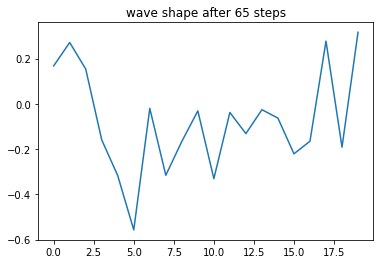

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_65/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_65/model_weights.tf
generator loss:1.7120299007655624
last advantage:[-0.02140515]
last log token-prob:[-0.8054163]
last time gaussian:[0.03472519]
last token entropy:[0.35994203]
last time entropy:[-0.09815326]
critic loss:0.040212945377805974
-----------------------


  4%|▍         | 66/1562 [06:42<2:29:54,  6.01s/it]

total discriminator loss:0.4292867381232388
average true return:0.5140606234536504
-----------------------
Training Step: 66
generator loss:1.6674875078952707
last advantage:[0.36320868]
last log token-prob:[-0.68697482]
last time gaussian:[0.53978474]
last token entropy:[0.3456141]
last time entropy:[-0.11777507]
critic loss:0.04107926742296124
-----------------------


  4%|▍         | 67/1562 [06:45<2:06:33,  5.08s/it]

total discriminator loss:0.41286385877120846
average true return:0.5006605164036555
-----------------------
Training Step: 67
generator loss:1.7082529934612947
last advantage:[0.09820136]
last log token-prob:[-0.79406186]
last time gaussian:[0.33326747]
last token entropy:[0.35891999]
last time entropy:[0.0578931]
critic loss:0.038237079405360815
-----------------------


  4%|▍         | 68/1562 [06:48<1:50:12,  4.43s/it]

total discriminator loss:0.4158751373783805
average true return:0.5092730581077295
-----------------------
Training Step: 68
generator loss:1.665100347232195
last advantage:[0.06242103]
last log token-prob:[-0.92157996]
last time gaussian:[-1.62766374]
last token entropy:[0.36668735]
last time entropy:[0.01902538]
critic loss:0.04180381242486176
-----------------------


  4%|▍         | 69/1562 [06:51<1:38:44,  3.97s/it]

total discriminator loss:0.4084111845278205
average true return:0.4934747339405103
-----------------------
Training Step: 69
generator loss:1.6401678938672517
last advantage:[-0.00775199]
last log token-prob:[-1.38345456]
last time gaussian:[0.41277586]
last token entropy:[0.34684722]
last time entropy:[-0.11616058]
critic loss:0.03879464089014491
-----------------------


  4%|▍         | 70/1562 [06:53<1:30:42,  3.65s/it]

total discriminator loss:0.4016843473864975
average true return:0.49777305397235433
-----------------------
Training Step: 70
event_types: [2, 0, 3, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 2]
mad_score: 0.5619
fid_score: 6008.44089848576
rule_score: 0.41125


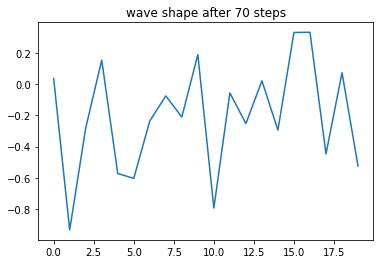

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_70/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_70/model_weights.tf
generator loss:1.5711302191567404
last advantage:[0.48353608]
last log token-prob:[-0.80825294]
last time gaussian:[0.44097626]
last token entropy:[0.36018656]
last time entropy:[-0.12944094]
critic loss:0.03725364357429457
-----------------------


  5%|▍         | 71/1562 [07:05<2:28:59,  6.00s/it]

total discriminator loss:0.3991613658194296
average true return:0.49584393674372246
-----------------------
Training Step: 71
generator loss:1.591102501989159
last advantage:[-0.00300051]
last log token-prob:[-0.72605373]
last time gaussian:[0.47152569]
last token entropy:[0.35127532]
last time entropy:[-0.08987126]
critic loss:0.03687372470093199
-----------------------


  5%|▍         | 72/1562 [07:08<2:05:51,  5.07s/it]

total discriminator loss:0.36988921666813035
average true return:0.4920400694056553
-----------------------
Training Step: 72
generator loss:1.5935491505564534
last advantage:[0.03821851]
last log token-prob:[-1.60350435]
last time gaussian:[0.35889333]
last token entropy:[0.32260942]
last time entropy:[-0.09557809]
critic loss:0.03418474524798219
-----------------------


  5%|▍         | 73/1562 [07:11<1:49:37,  4.42s/it]

total discriminator loss:0.39968009200053384
average true return:0.48399386017793355
-----------------------
Training Step: 73
generator loss:1.5994586583246972
last advantage:[0.01223592]
last log token-prob:[-1.83825637]
last time gaussian:[0.62044482]
last token entropy:[0.29245664]
last time entropy:[-0.12044762]
critic loss:0.03289412245356255
-----------------------


  5%|▍         | 74/1562 [07:14<1:38:17,  3.96s/it]

total discriminator loss:0.37528885222735325
average true return:0.47425950800620864
-----------------------
Training Step: 74
generator loss:1.5123130090704497
last advantage:[-0.02524081]
last log token-prob:[-0.65971482]
last time gaussian:[0.36156838]
last token entropy:[0.34107174]
last time entropy:[0.07611889]
critic loss:0.03219262275097057
-----------------------


  5%|▍         | 75/1562 [07:17<1:30:24,  3.65s/it]

total discriminator loss:0.3928101891308032
average true return:0.47903215495184454
-----------------------
Training Step: 75
event_types: [1, 0, 3, 1, 2, 2, 3, 0, 3, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0]
mad_score: 0.5514375
fid_score: 6046.528922426185
rule_score: 0.4215


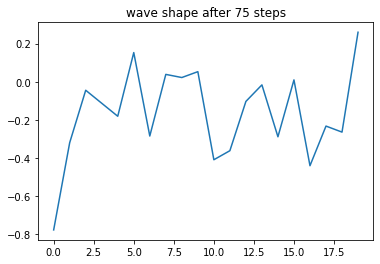

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_75/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_75/model_weights.tf
generator loss:1.6375328683501464
last advantage:[4.79407241e-06]
last log token-prob:[-0.79483407]
last time gaussian:[0.42729042]
last token entropy:[0.35899171]
last time entropy:[0.06998078]
critic loss:0.032317499945159936
-----------------------


  5%|▍         | 76/1562 [07:28<2:28:19,  5.99s/it]

total discriminator loss:0.3842716854746726
average true return:0.4711521235732655
-----------------------
Training Step: 76
generator loss:1.6094790605638518
last advantage:[0.13957558]
last log token-prob:[-0.75033293]
last time gaussian:[0.15226885]
last token entropy:[0.3543142]
last time entropy:[-0.09590182]
critic loss:0.027567941796818724
-----------------------


  5%|▍         | 77/1562 [07:31<2:05:16,  5.06s/it]

total discriminator loss:0.41643286982376704
average true return:0.47379452721129406
-----------------------
Training Step: 77
generator loss:1.495560241388741
last advantage:[0.05965431]
last log token-prob:[-2.03925269]
last time gaussian:[-0.55264373]
last token entropy:[0.26535963]
last time entropy:[0.11427712]
critic loss:0.028139497649284
-----------------------


  5%|▍         | 78/1562 [07:34<1:49:11,  4.41s/it]

total discriminator loss:0.36983448247628214
average true return:0.4688905868191729
-----------------------
Training Step: 78
generator loss:1.5434779765980533
last advantage:[-0.00411548]
last log token-prob:[-1.92803324]
last time gaussian:[-0.40363701]
last token entropy:[0.28040149]
last time entropy:[0.07475919]
critic loss:0.03021585691304171
-----------------------


  5%|▌         | 79/1562 [07:37<1:38:01,  3.97s/it]

total discriminator loss:0.34296981398117254
average true return:0.4705237362054936
-----------------------
Training Step: 79
generator loss:1.4802156999246958
last advantage:[0.05483571]
last log token-prob:[-1.57185004]
last time gaussian:[0.50960603]
last token entropy:[0.32641139]
last time entropy:[-0.04837787]
critic loss:0.029247446106958747
-----------------------


  5%|▌         | 80/1562 [07:40<1:30:07,  3.65s/it]

total discriminator loss:0.37351774043091346
average true return:0.46664278518685504
-----------------------
Training Step: 80
event_types: [3, 3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 2]
mad_score: 0.5387
fid_score: 6163.812825205894
rule_score: 0.4115


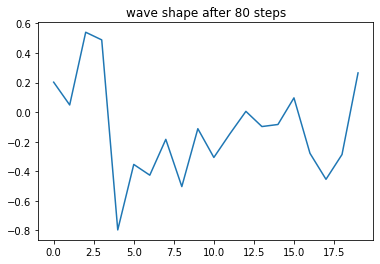

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_80/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_80/model_weights.tf
generator loss:1.4953365137634287
last advantage:[-0.001115]
last log token-prob:[-1.5199091]
last time gaussian:[0.29387056]
last token entropy:[0.33245241]
last time entropy:[0.08954487]
critic loss:0.029728538072358902
-----------------------


  5%|▌         | 81/1562 [07:51<2:28:03,  6.00s/it]

total discriminator loss:0.38196542631448605
average true return:0.4706823667123293
-----------------------
Training Step: 81
generator loss:1.4834760205701336
last advantage:[0.02863252]
last log token-prob:[-0.69320282]
last time gaussian:[-0.54630152]
last token entropy:[0.34658213]
last time entropy:[-0.1134326]
critic loss:0.027787540254995902
-----------------------


  5%|▌         | 82/1562 [07:54<2:04:59,  5.07s/it]

total discriminator loss:0.353654470727106
average true return:0.460434378738492
-----------------------
Training Step: 82
generator loss:1.4968271820509815
last advantage:[0.02566471]
last log token-prob:[-1.53594024]
last time gaussian:[-1.18507194]
last token entropy:[0.33061606]
last time entropy:[0.03118006]
critic loss:0.030541626618739087
-----------------------


  5%|▌         | 83/1562 [07:57<1:49:07,  4.43s/it]

total discriminator loss:0.35215726461868724
average true return:0.48362411419962104
-----------------------
Training Step: 83
generator loss:1.4856514519519757
last advantage:[0.14464943]
last log token-prob:[-2.23762029]
last time gaussian:[-0.49750825]
last token entropy:[0.23878126]
last time entropy:[-0.03504981]
critic loss:0.029144073490634213
-----------------------


  5%|▌         | 84/1562 [08:00<1:37:47,  3.97s/it]

total discriminator loss:0.3525371216341709
average true return:0.47962929868686827
-----------------------
Training Step: 84
generator loss:1.5188975258515327
last advantage:[0.04661572]
last log token-prob:[-1.46136621]
last time gaussian:[-1.30653619]
last token entropy:[0.33891889]
last time entropy:[0.07531564]
critic loss:0.029565030487941825
-----------------------


  5%|▌         | 85/1562 [08:03<1:29:49,  3.65s/it]

total discriminator loss:0.38011557578123056
average true return:0.4817838627222002
-----------------------
Training Step: 85
event_types: [1, 3, 0, 1, 3, 2, 3, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2]
mad_score: 0.5235125
fid_score: 6197.901604749721
rule_score: 0.44075


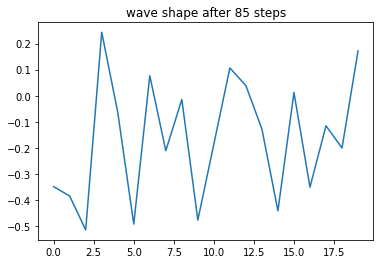

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_85/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_85/model_weights.tf
generator loss:1.4140008111845828
last advantage:[-0.0339944]
last log token-prob:[-0.74531192]
last time gaussian:[0.30672746]
last token entropy:[0.35371478]
last time entropy:[0.17242795]
critic loss:0.02536897819675834
-----------------------


  6%|▌         | 86/1562 [08:14<2:27:33,  6.00s/it]

total discriminator loss:0.34729567739078293
average true return:0.48688751642461225
-----------------------
Training Step: 86
generator loss:1.4237989053454674
last advantage:[0.17843026]
last log token-prob:[-0.73336567]
last time gaussian:[-1.10412871]
last token entropy:[0.35222803]
last time entropy:[0.03841537]
critic loss:0.027181784231822638
-----------------------


  6%|▌         | 87/1562 [08:17<2:04:40,  5.07s/it]

total discriminator loss:0.3401109351102093
average true return:0.4857342735392312
-----------------------
Training Step: 87
generator loss:1.4286962077158576
last advantage:[-0.01822489]
last log token-prob:[-0.64483671]
last time gaussian:[0.50672526]
last token entropy:[0.33837692]
last time entropy:[-0.00834592]
critic loss:0.028894918731748098
-----------------------


  6%|▌         | 88/1562 [08:20<1:48:35,  4.42s/it]

total discriminator loss:0.347735019218557
average true return:0.4883301708818712
-----------------------
Training Step: 88
generator loss:1.360963714858708
last advantage:[0.02731453]
last log token-prob:[-0.59247983]
last time gaussian:[0.07924019]
last token entropy:[0.3276143]
last time entropy:[0.01446657]
critic loss:0.027136238674953718
-----------------------


  6%|▌         | 89/1562 [08:23<1:37:25,  3.97s/it]

total discriminator loss:0.36674651599532904
average true return:0.48989585829392845
-----------------------
Training Step: 89
generator loss:1.4964737136946222
last advantage:[0.34821336]
last log token-prob:[-1.71100592]
last time gaussian:[0.5993604]
last token entropy:[0.3091513]
last time entropy:[-0.20316684]
critic loss:0.03212410660089503
-----------------------


  6%|▌         | 90/1562 [08:26<1:29:34,  3.65s/it]

total discriminator loss:0.3581221006282579
average true return:0.4956765898142951
-----------------------
Training Step: 90
event_types: [1, 3, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 3]
mad_score: 0.5118375
fid_score: 6284.232408200079
rule_score: 0.4455


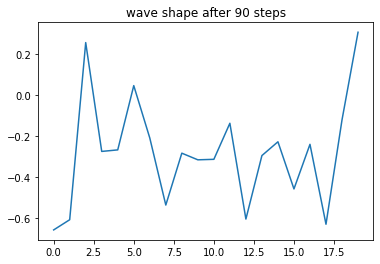

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_90/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_90/model_weights.tf
generator loss:1.4094240870889507
last advantage:[-0.05437614]
last log token-prob:[-1.58779616]
last time gaussian:[0.07682563]
last token entropy:[0.32450668]
last time entropy:[0.06042644]
critic loss:0.028086052648660164
-----------------------


  6%|▌         | 91/1562 [08:37<2:26:54,  5.99s/it]

total discriminator loss:0.3310924562710212
average true return:0.4964622832876452
-----------------------
Training Step: 91
generator loss:1.4709067731679164
last advantage:[0.02435994]
last log token-prob:[-0.67339097]
last time gaussian:[0.340881]
last token entropy:[0.34341345]
last time entropy:[0.10775196]
critic loss:0.02900435340224916
-----------------------


  6%|▌         | 92/1562 [08:40<2:04:15,  5.07s/it]

total discriminator loss:0.3712382182815378
average true return:0.49510577295040437
-----------------------
Training Step: 92
generator loss:1.355166289424255
last advantage:[0.03709497]
last log token-prob:[-1.81421826]
last time gaussian:[0.40668097]
last token entropy:[0.29565454]
last time entropy:[0.03857358]
critic loss:0.030601978076425507
-----------------------


  6%|▌         | 93/1562 [08:43<1:48:31,  4.43s/it]

total discriminator loss:0.350560927526742
average true return:0.4896153799587294
-----------------------
Training Step: 93
generator loss:1.4300887672408096
last advantage:[0.13069743]
last log token-prob:[-0.64253813]
last time gaussian:[-0.36648871]
last token entropy:[0.33794665]
last time entropy:[-0.14508263]
critic loss:0.02983741956973377
-----------------------


  6%|▌         | 94/1562 [08:46<1:37:13,  3.97s/it]

total discriminator loss:0.3385950426529416
average true return:0.4966852859500259
-----------------------
Training Step: 94
generator loss:1.4051843203096568
last advantage:[0.01911699]
last log token-prob:[-0.6583898]
last time gaussian:[-0.64524347]
last token entropy:[0.34083802]
last time entropy:[0.00499605]
critic loss:0.028601905493642547
-----------------------


  6%|▌         | 95/1562 [08:49<1:29:21,  3.65s/it]

total discriminator loss:0.34420849142042076
average true return:0.4982665793109049
-----------------------
Training Step: 95
event_types: [3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 0, 2, 0, 3, 3, 0, 2, 0, 0]
mad_score: 0.4975375
fid_score: 6331.918157202814
rule_score: 0.45875


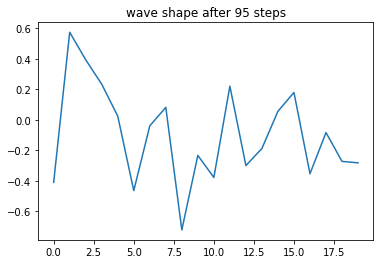

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_95/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_95/model_weights.tf
generator loss:1.3128595314461073
last advantage:[0.18843679]
last log token-prob:[-2.06219455]
last time gaussian:[0.33060159]
last token entropy:[0.26225871]
last time entropy:[0.03642786]
critic loss:0.027181536039471533
-----------------------


  6%|▌         | 96/1562 [09:00<2:26:49,  6.01s/it]

total discriminator loss:0.35310963841125054
average true return:0.5042781725385099
-----------------------
Training Step: 96
generator loss:1.3313797730935082
last advantage:[-0.03161693]
last log token-prob:[-0.68476618]
last time gaussian:[0.44673048]
last token entropy:[0.34526466]
last time entropy:[0.03861514]
critic loss:0.026711046757542
-----------------------


  6%|▌         | 97/1562 [09:03<2:04:01,  5.08s/it]

total discriminator loss:0.32396657688821884
average true return:0.49932559161437384
-----------------------
Training Step: 97
generator loss:1.3452956849159832
last advantage:[0.03489068]
last log token-prob:[-0.56096928]
last time gaussian:[0.35376659]
last token entropy:[0.3201203]
last time entropy:[0.09041351]
critic loss:0.027156116475609247
-----------------------


  6%|▋         | 98/1562 [09:06<1:48:11,  4.43s/it]

total discriminator loss:0.3649002097018209
average true return:0.49286660679838995
-----------------------
Training Step: 98
generator loss:1.3621254201187305
last advantage:[-0.00873506]
last log token-prob:[-0.54511661]
last time gaussian:[0.49368846]
last token entropy:[0.31604453]
last time entropy:[-0.00087727]
critic loss:0.02763609510645288
-----------------------


  6%|▋         | 99/1562 [09:09<1:36:58,  3.98s/it]

total discriminator loss:0.37782047148187997
average true return:0.4898356824299548
-----------------------
Training Step: 99
generator loss:1.3421133136418795
last advantage:[0.0374755]
last log token-prob:[-1.69339258]
last time gaussian:[0.46385001]
last token entropy:[0.31140573]
last time entropy:[-0.09671457]
critic loss:0.027756725394583164
-----------------------


  6%|▋         | 100/1562 [09:12<1:29:02,  3.65s/it]

total discriminator loss:0.37289203627471934
average true return:0.4886800171729059
-----------------------
Training Step: 100
event_types: [1, 0, 1, 0, 2, 0, 2, 1, 2, 3, 2, 1, 2, 1, 2, 0, 2, 3, 1, 1]
mad_score: 0.479975
fid_score: 6312.731311894042
rule_score: 0.4695


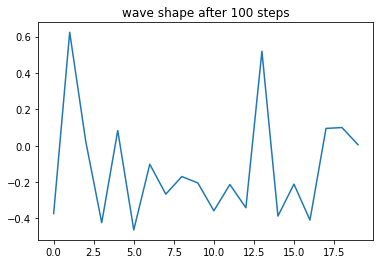

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_100/model_weights.tf
generator loss:1.355971881097618
last advantage:[0.02463506]
last log token-prob:[-1.64261671]
last time gaussian:[0.27872531]
last token entropy:[0.31780217]
last time entropy:[0.03593692]
critic loss:0.026567983377739024
-----------------------


  6%|▋         | 101/1562 [09:24<2:26:08,  6.00s/it]

total discriminator loss:0.34993524210061955
average true return:0.4906331867926697
-----------------------
Training Step: 101
generator loss:1.3354091082974566
last advantage:[-0.03275432]
last log token-prob:[-1.72880511]
last time gaussian:[0.33790047]
last token entropy:[0.30685664]
last time entropy:[0.0570658]
critic loss:0.02561607948889222
-----------------------


  7%|▋         | 102/1562 [09:27<2:03:25,  5.07s/it]

total discriminator loss:0.3405213553386942
average true return:0.4958823687136084
-----------------------
Training Step: 102
generator loss:1.3198694526665342
last advantage:[0.00760964]
last log token-prob:[-1.83282613]
last time gaussian:[-0.05183527]
last token entropy:[0.29318044]
last time entropy:[0.10106551]
critic loss:0.028292089152062987
-----------------------
total discriminator loss:0.3532256615985193
average true return:0.49483896241366
-----------------------


  7%|▋         | 103/1562 [09:30<1:52:40,  4.63s/it]

Training Step: 103
generator loss:1.3226859108422864
last advantage:[0.02766968]
last log token-prob:[-0.74079972]
last time gaussian:[0.08935207]
last token entropy:[0.35316331]
last time entropy:[0.06790798]
critic loss:0.02702258636177618
-----------------------
total discriminator loss:0.34574535670890966
average true return:0.5127145240336919
-----------------------


  7%|▋         | 104/1562 [09:34<1:48:59,  4.48s/it]

Training Step: 104
generator loss:1.2330940436628706
last advantage:[-0.0108944]
last log token-prob:[-0.621128]
last time gaussian:[-0.36994721]
last token entropy:[0.33375566]
last time entropy:[0.15746184]
critic loss:0.027168933970850767
-----------------------


  7%|▋         | 105/1562 [09:38<1:45:04,  4.33s/it]

total discriminator loss:0.3494226550173716
average true return:0.49623320065101023
-----------------------
Training Step: 105
event_types: [2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2]
mad_score: 0.4615875
fid_score: 6343.447342171212
rule_score: 0.4765


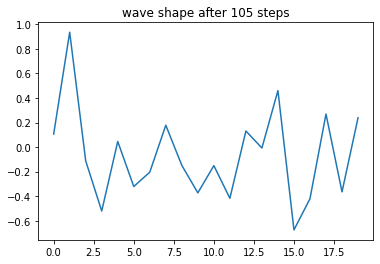

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_105/model_weights.tf
generator loss:1.234522592635751
last advantage:[0.00199216]
last log token-prob:[-1.56406209]
last time gaussian:[-0.11038223]
last token entropy:[0.3273335]
last time entropy:[-0.01896659]
critic loss:0.025406299409226674
-----------------------


  7%|▋         | 106/1562 [09:51<2:46:26,  6.86s/it]

total discriminator loss:0.3264076430363803
average true return:0.49974229787992475
-----------------------
Training Step: 106
generator loss:1.217403187383022
last advantage:[0.06970306]
last log token-prob:[-1.65928064]
last time gaussian:[0.42819674]
last token entropy:[0.31572096]
last time entropy:[-0.02707722]
critic loss:0.02496034951558675
-----------------------


  7%|▋         | 107/1562 [09:54<2:17:28,  5.67s/it]

total discriminator loss:0.3528223931829566
average true return:0.505512256199969
-----------------------
Training Step: 107
generator loss:1.2786026481736512
last advantage:[0.09900443]
last log token-prob:[-1.79684761]
last time gaussian:[0.18812482]
last token entropy:[0.2979547]
last time entropy:[0.12268767]
critic loss:0.025008571286982063
-----------------------


  7%|▋         | 108/1562 [09:57<1:57:18,  4.84s/it]

total discriminator loss:0.34866162290047276
average true return:0.5014378336535641
-----------------------
Training Step: 108
generator loss:1.2291384321282688
last advantage:[0.07515448]
last log token-prob:[-0.58558941]
last time gaussian:[0.24060463]
last token entropy:[0.32604306]
last time entropy:[0.06840699]
critic loss:0.02390693309058718
-----------------------


  7%|▋         | 109/1562 [10:00<1:43:23,  4.27s/it]

total discriminator loss:0.35430421131850887
average true return:0.4939424737332314
-----------------------
Training Step: 109
generator loss:1.2018203358769408
last advantage:[-0.14282996]
last log token-prob:[-0.51961035]
last time gaussian:[0.09975553]
last token entropy:[0.30903942]
last time entropy:[-0.0064685]
critic loss:0.025826794987599943
-----------------------


  7%|▋         | 110/1562 [10:03<1:33:26,  3.86s/it]

total discriminator loss:0.33150325493660676
average true return:0.5120645355018504
-----------------------
Training Step: 110
event_types: [2, 0, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 1]
mad_score: 0.4489
fid_score: 6322.06796799721
rule_score: 0.4875


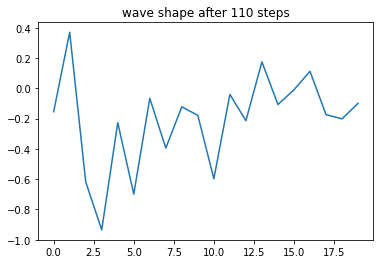

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_110/model_weights.tf
generator loss:1.1637306911802392
last advantage:[0.02093805]
last log token-prob:[-0.49888778]
last time gaussian:[0.05037622]
last token entropy:[0.30292747]
last time entropy:[0.11639481]
critic loss:0.02352450476409419
-----------------------


  7%|▋         | 111/1562 [10:14<2:28:37,  6.15s/it]

total discriminator loss:0.33406200393635266
average true return:0.5022169851472446
-----------------------
Training Step: 111
generator loss:1.1643244435239801
last advantage:[0.16925136]
last log token-prob:[-0.6036277]
last time gaussian:[0.08955586]
last token entropy:[0.33007831]
last time entropy:[0.1169554]
critic loss:0.02490277848784705
-----------------------


  7%|▋         | 112/1562 [10:17<2:04:56,  5.17s/it]

total discriminator loss:0.3328483237033659
average true return:0.49803294897839023
-----------------------
Training Step: 112
generator loss:1.1228857918765236
last advantage:[-0.0038039]
last log token-prob:[-0.49667482]
last time gaussian:[-1.16192373]
last token entropy:[0.30225188]
last time entropy:[-0.05360583]
critic loss:0.0239871159330651
-----------------------
total discriminator loss:2.2039091092438508
average true return:0.5026407247087064
-----------------------


  7%|▋         | 113/1562 [10:20<1:50:38,  4.58s/it]

Training Step: 113
generator loss:1.1245601656067472
last advantage:[-0.00299448]
last log token-prob:[-0.66132765]
last time gaussian:[-0.46353641]
last token entropy:[0.34135458]
last time entropy:[0.17761983]
critic loss:0.02238847365870998
-----------------------
total discriminator loss:0.3340285290722198
average true return:0.493861249175251
-----------------------


  7%|▋         | 114/1562 [10:24<1:47:17,  4.45s/it]

Training Step: 114
generator loss:1.1713156603835115
last advantage:[0.09173897]
last log token-prob:[-1.77791883]
last time gaussian:[0.25533182]
last token entropy:[0.30044957]
last time entropy:[0.14681384]
critic loss:0.022659524722100432
-----------------------
total discriminator loss:0.35498021048344464
average true return:0.501906106482039
-----------------------


  7%|▋         | 115/1562 [10:28<1:44:43,  4.34s/it]

Training Step: 115
event_types: [0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2]
mad_score: 0.429875
fid_score: 6337.037476585197
rule_score: 0.50075


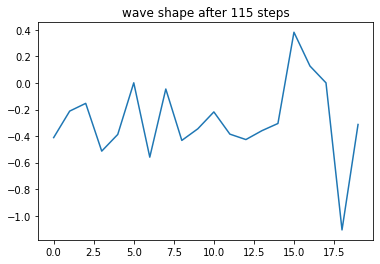

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_115/model_weights.tf
generator loss:1.173268611105532
last advantage:[-0.04299267]
last log token-prob:[-0.55357921]
last time gaussian:[0.21658942]
last token entropy:[0.31824631]
last time entropy:[0.07208598]
critic loss:0.022759870974836404
-----------------------


  7%|▋         | 116/1562 [10:41<2:45:22,  6.86s/it]

total discriminator loss:0.3651172625691472
average true return:0.4927560097210779
-----------------------
Training Step: 116
generator loss:1.1339475041981608
last advantage:[0.04754796]
last log token-prob:[-1.95178254]
last time gaussian:[0.21632952]
last token entropy:[0.2771935]
last time entropy:[0.0832204]
critic loss:0.02244721073150377
-----------------------


  7%|▋         | 117/1562 [10:44<2:16:36,  5.67s/it]

total discriminator loss:0.3617952814755616
average true return:0.49500694290334535
-----------------------
Training Step: 117
generator loss:1.0896058231437593
last advantage:[0.07116866]
last log token-prob:[-0.51332468]
last time gaussian:[-0.16817654]
last token entropy:[0.30722607]
last time entropy:[-0.0025795]
critic loss:0.023091101092293627
-----------------------


  8%|▊         | 118/1562 [10:47<1:56:28,  4.84s/it]

total discriminator loss:0.32347511285034536
average true return:0.49311579044134746
-----------------------
Training Step: 118
generator loss:1.1069741360234167
last advantage:[0.07599819]
last log token-prob:[-0.50905607]
last time gaussian:[0.45396127]
last token entropy:[0.3059746]
last time entropy:[0.03671303]
critic loss:0.022883709878018466
-----------------------


  8%|▊         | 119/1562 [10:50<1:42:27,  4.26s/it]

total discriminator loss:0.3322568577443654
average true return:0.5006119655202692
-----------------------
Training Step: 119
generator loss:1.1000091672080532
last advantage:[0.19746403]
last log token-prob:[-0.44733184]
last time gaussian:[0.35673675]
last token entropy:[0.28599343]
last time entropy:[0.06736836]
critic loss:0.022071846605349416
-----------------------


  8%|▊         | 120/1562 [10:53<1:32:46,  3.86s/it]

total discriminator loss:0.3327066599671955
average true return:0.49750516847515724
-----------------------
Training Step: 120
event_types: [0, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0]
mad_score: 0.4139
fid_score: 6358.044860245045
rule_score: 0.50025


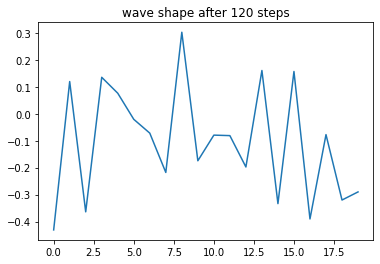

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_120/model_weights.tf
generator loss:1.0959824039827724
last advantage:[0.07515169]
last log token-prob:[-0.50689102]
last time gaussian:[-0.82464293]
last token entropy:[0.30533362]
last time entropy:[0.02880994]
critic loss:0.02070803264340626
-----------------------


  8%|▊         | 121/1562 [11:04<2:27:36,  6.15s/it]

total discriminator loss:0.34865929420002817
average true return:0.49886192252543016
-----------------------
Training Step: 121
generator loss:1.1567338721134242
last advantage:[0.16959412]
last log token-prob:[-0.44379455]
last time gaussian:[0.25582881]
last token entropy:[0.28473735]
last time entropy:[0.15837351]
critic loss:0.02123372559116175
-----------------------


  8%|▊         | 122/1562 [11:07<2:04:09,  5.17s/it]

total discriminator loss:0.331826579944956
average true return:0.4964311243687697
-----------------------
Training Step: 122
generator loss:1.1104635883172418
last advantage:[0.19768804]
last log token-prob:[-2.43463379]
last time gaussian:[0.05979077]
last token entropy:[0.21334655]
last time entropy:[0.03757967]
critic loss:0.021446085108301295
-----------------------


  8%|▊         | 123/1562 [11:10<1:47:37,  4.49s/it]

total discriminator loss:0.3490523773709356
average true return:0.4974429741404296
-----------------------
Training Step: 123
generator loss:1.0486343644859448
last advantage:[0.08028912]
last log token-prob:[-1.90464994]
last time gaussian:[-0.12659461]
last token entropy:[0.28355428]
last time entropy:[0.04320872]
critic loss:0.020908191009133333
-----------------------


  8%|▊         | 124/1562 [11:13<1:36:10,  4.01s/it]

total discriminator loss:0.36218583770456325
average true return:0.4913110332667782
-----------------------
Training Step: 124
generator loss:1.0881977223598125
last advantage:[0.09791872]
last log token-prob:[-0.34959968]
last time gaussian:[-0.25287611]
last token entropy:[0.24645737]
last time entropy:[-0.02191104]
critic loss:0.02415668063972663
-----------------------


  8%|▊         | 125/1562 [11:16<1:28:05,  3.68s/it]

total discriminator loss:0.3631453657077597
average true return:0.5017493606966434
-----------------------
Training Step: 125
event_types: [2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2]
mad_score: 0.3977875
fid_score: 6410.327666773867
rule_score: 0.5035


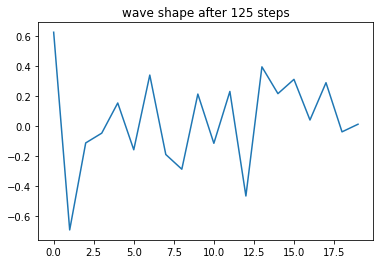

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_125/model_weights.tf
generator loss:1.0462193843651737
last advantage:[0.02703439]
last log token-prob:[-0.42520981]
last time gaussian:[-0.28015494]
last token entropy:[0.27793101]
last time entropy:[0.05606876]
critic loss:0.02112079357082879
-----------------------


  8%|▊         | 126/1562 [11:27<2:24:07,  6.02s/it]

total discriminator loss:0.3328324952973346
average true return:0.4928226605720296
-----------------------
Training Step: 126
generator loss:1.043611971612598
last advantage:[0.13225385]
last log token-prob:[-0.32719071]
last time gaussian:[0.05481642]
last token entropy:[0.23588691]
last time entropy:[-0.12212997]
critic loss:0.02125071590127827
-----------------------


  8%|▊         | 127/1562 [11:30<2:01:37,  5.09s/it]

total discriminator loss:0.3571204200565222
average true return:0.5049465015472703
-----------------------
Training Step: 127
generator loss:1.075343173937411
last advantage:[0.01539301]
last log token-prob:[-0.40527022]
last time gaussian:[0.24120927]
last token entropy:[0.27023281]
last time entropy:[0.13517886]
critic loss:0.023345699476941782
-----------------------


  8%|▊         | 128/1562 [11:33<1:45:53,  4.43s/it]

total discriminator loss:0.36021569507508133
average true return:0.5085916389141947
-----------------------
Training Step: 128
generator loss:1.0702744734610334
last advantage:[0.10716803]
last log token-prob:[-2.20454257]
last time gaussian:[0.13165305]
last token entropy:[0.24316318]
last time entropy:[-0.05003803]
critic loss:0.02031851262466596
-----------------------


  8%|▊         | 129/1562 [11:36<1:34:47,  3.97s/it]

total discriminator loss:0.33059046562659555
average true return:0.5109618545136365
-----------------------
Training Step: 129
generator loss:1.0156797280239018
last advantage:[0.07189223]
last log token-prob:[-0.34229006]
last time gaussian:[-0.14589042]
last token entropy:[0.24307461]
last time entropy:[0.06611455]
critic loss:0.022386902236140753
-----------------------
total discriminator loss:0.37414867677331454
average true return:0.506057916953984
-----------------------


  8%|▊         | 130/1562 [11:39<1:29:50,  3.76s/it]

Training Step: 130
event_types: [2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 0, 2]
mad_score: 0.378725
fid_score: 6423.064998618772
rule_score: 0.52075


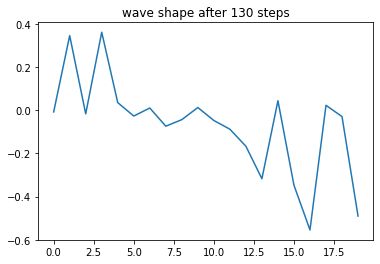

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_130/model_weights.tf
generator loss:1.0411516298914407
last advantage:[0.10132821]
last log token-prob:[-2.04834537]
last time gaussian:[-0.05640082]
last token entropy:[0.26413022]
last time entropy:[-0.00867704]
critic loss:0.022079253944223727
-----------------------
total discriminator loss:0.35763426562019857
average true return:0.5115609105868411
-----------------------


  8%|▊         | 131/1562 [11:55<2:54:39,  7.32s/it]

Training Step: 131
generator loss:1.0663961235336965
last advantage:[0.02602003]
last log token-prob:[-0.34332757]
last time gaussian:[0.28697954]
last token entropy:[0.24355857]
last time entropy:[0.06489536]
critic loss:0.021223127113045623
-----------------------
total discriminator loss:0.3598287773448841
average true return:0.5139437629127641
-----------------------


  8%|▊         | 132/1562 [11:59<2:31:30,  6.36s/it]

Training Step: 132
generator loss:1.027480254997802
last advantage:[0.02394322]
last log token-prob:[-2.57187341]
last time gaussian:[0.40968254]
last token entropy:[0.19647132]
last time entropy:[0.06716488]
critic loss:0.024969504572734186
-----------------------
total discriminator loss:0.32958163806086505
average true return:0.5029265261208322
-----------------------


  9%|▊         | 133/1562 [12:03<2:11:15,  5.51s/it]

Training Step: 133
generator loss:1.0332717200521455
last advantage:[0.035904]
last log token-prob:[-2.10266375]
last time gaussian:[0.31873961]
last token entropy:[0.25679973]
last time entropy:[0.02559836]
critic loss:0.01981959132104904
-----------------------
total discriminator loss:0.34317675853955054
average true return:0.5174516146825396
-----------------------


  9%|▊         | 134/1562 [12:07<2:01:14,  5.09s/it]

Training Step: 134
generator loss:0.9969314026959986
last advantage:[0.00617383]
last log token-prob:[-0.28667976]
last time gaussian:[-0.00439377]
last token entropy:[0.21522543]
last time entropy:[0.00451731]
critic loss:0.01981653381742888
-----------------------
total discriminator loss:0.36187343129800426
average true return:0.49659104694774603
-----------------------


  9%|▊         | 135/1562 [12:11<1:54:06,  4.80s/it]

Training Step: 135
event_types: [3, 3, 2, 2, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]
mad_score: 0.3637875
fid_score: 6441.712465334182
rule_score: 0.506


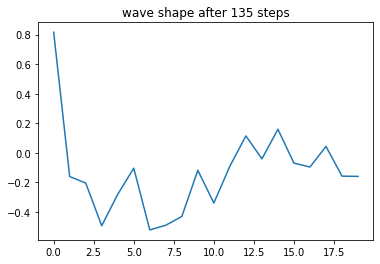

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_135/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_135/model_weights.tf
generator loss:0.9659210761274263
last advantage:[0.07249049]
last log token-prob:[-2.46145385]
last time gaussian:[0.14655043]
last token entropy:[0.20998868]
last time entropy:[0.13161612]
critic loss:0.019234759320499766
-----------------------


  9%|▊         | 136/1562 [12:26<3:10:40,  8.02s/it]

total discriminator loss:0.34115564766371087
average true return:0.4988384698575558
-----------------------
Training Step: 136
generator loss:0.9971653083778389
last advantage:[0.0044728]
last log token-prob:[-0.31274325]
last time gaussian:[0.31618132]
last token entropy:[0.2287522]
last time entropy:[0.03608647]
critic loss:0.019430327745812676
-----------------------
total discriminator loss:0.35394043538442604
average true return:0.5034952173053073
-----------------------


  9%|▉         | 137/1562 [12:30<2:42:24,  6.84s/it]

Training Step: 137
generator loss:1.0463273061078742
last advantage:[0.05979696]
last log token-prob:[-0.29942881]
last time gaussian:[0.3711013]
last token entropy:[0.22194906]
last time entropy:[-0.00918971]
critic loss:0.020328594122836517
-----------------------
total discriminator loss:0.3213490312625653
average true return:0.49791344245087354
-----------------------


  9%|▉         | 138/1562 [12:35<2:22:54,  6.02s/it]

Training Step: 138
generator loss:0.9396537899252824
last advantage:[-0.00243898]
last log token-prob:[-0.36175444]
last time gaussian:[-1.10056155]
last token entropy:[0.2519451]
last time entropy:[0.13017348]
critic loss:0.01876869799415717
-----------------------


  9%|▉         | 139/1562 [12:38<2:07:02,  5.36s/it]

total discriminator loss:0.32126170637444823
average true return:0.4919850524196944
-----------------------
Training Step: 139
generator loss:0.9639667286052713
last advantage:[0.06821048]
last log token-prob:[-2.15058489]
last time gaussian:[0.34473833]
last token entropy:[0.25036259]
last time entropy:[0.13660453]
critic loss:0.02099757214095103
-----------------------
total discriminator loss:0.2981065986188091
average true return:0.49951997747521765
-----------------------


  9%|▉         | 140/1562 [12:42<1:56:25,  4.91s/it]

Training Step: 140
event_types: [3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]
mad_score: 0.348725
fid_score: 6445.111835703725
rule_score: 0.5175


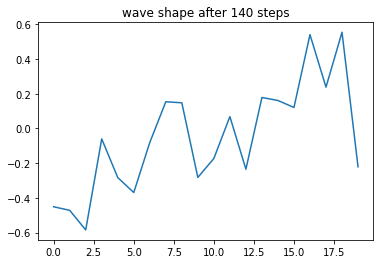

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_140/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_140/model_weights.tf
generator loss:0.9343648551511115
last advantage:[0.02365793]
last log token-prob:[-0.34855986]
last time gaussian:[-0.49988308]
last token entropy:[0.24597997]
last time entropy:[0.02760183]
critic loss:0.021053945422362275
-----------------------
total discriminator loss:0.3182060029177821
average true return:0.4890053397626357
-----------------------


  9%|▉         | 141/1562 [12:58<3:13:05,  8.15s/it]

Training Step: 141
generator loss:0.9526592289954137
last advantage:[0.16280474]
last log token-prob:[-2.79782002]
last time gaussian:[-0.75259841]
last token entropy:[0.17050691]
last time entropy:[0.02542735]
critic loss:0.020890441004245287
-----------------------


  9%|▉         | 142/1562 [13:02<2:43:46,  6.92s/it]

total discriminator loss:0.35373286887618655
average true return:0.49670998204533673
-----------------------
Training Step: 142
generator loss:0.89176610078798
last advantage:[0.25363399]
last log token-prob:[-2.48714801]
last time gaussian:[0.20898182]
last token entropy:[0.2067983]
last time entropy:[-0.00862683]
critic loss:0.019877751377947683
-----------------------
total discriminator loss:0.3320003327385171
average true return:0.4966824756110183
-----------------------


  9%|▉         | 143/1562 [13:06<2:20:38,  5.95s/it]

Training Step: 143
generator loss:0.9171501479472784
last advantage:[-0.05422484]
last log token-prob:[-0.28844942]
last time gaussian:[0.19065017]
last token entropy:[0.21617113]
last time entropy:[-0.00804429]
critic loss:0.019273070615360353
-----------------------
total discriminator loss:0.3259112182049171
average true return:0.485823604466244
-----------------------


  9%|▉         | 144/1562 [13:10<2:07:42,  5.40s/it]

Training Step: 144
generator loss:0.9173836173338448
last advantage:[0.00394578]
last log token-prob:[-2.51913299]
last time gaussian:[0.10542216]
last token entropy:[0.20286426]
last time entropy:[0.11856904]
critic loss:0.020024512613518126
-----------------------
total discriminator loss:0.33109193292213046
average true return:0.4871050498369229
-----------------------


  9%|▉         | 145/1562 [13:14<1:58:30,  5.02s/it]

Training Step: 145
event_types: [3, 2, 2, 0, 1, 2, 0, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2]
mad_score: 0.329
fid_score: 6435.78021583645
rule_score: 0.51575


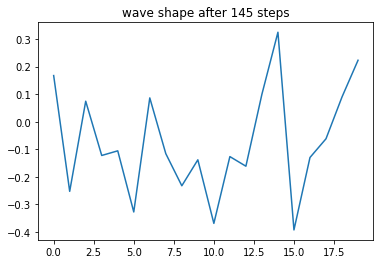

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_145/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_145/model_weights.tf
generator loss:0.9542390868454476
last advantage:[0.02209243]
last log token-prob:[-0.28228913]
last time gaussian:[0.38074292]
last token entropy:[0.21286171]
last time entropy:[0.02274813]
critic loss:0.020480680745245665
-----------------------


  9%|▉         | 146/1562 [13:30<3:13:00,  8.18s/it]

total discriminator loss:0.3351936896560904
average true return:0.481515199693607
-----------------------
Training Step: 146
generator loss:0.9471560773663352
last advantage:[0.04026985]
last log token-prob:[-0.27284082]
last time gaussian:[-0.23706235]
last token entropy:[0.20769024]
last time entropy:[-0.07919399]
critic loss:0.0195598343991051
-----------------------
total discriminator loss:0.3543459300891701
average true return:0.5010770237248465
-----------------------


  9%|▉         | 147/1562 [13:34<2:43:56,  6.95s/it]

Training Step: 147
generator loss:0.8597973651281849
last advantage:[0.03813153]
last log token-prob:[-0.31672903]
last time gaussian:[-0.00334296]
last token entropy:[0.23074601]
last time entropy:[0.05830291]
critic loss:0.019630852857583064
-----------------------
total discriminator loss:0.3568826035755477
average true return:0.4934894801994606
-----------------------


  9%|▉         | 148/1562 [13:38<2:23:32,  6.09s/it]

Training Step: 148
generator loss:0.8893974532517461
last advantage:[0.12355735]
last log token-prob:[-2.70892731]
last time gaussian:[-1.05175651]
last token entropy:[0.18043682]
last time entropy:[0.02716041]
critic loss:0.020041291062924894
-----------------------
total discriminator loss:0.3456014893942737
average true return:0.5037456841875105
-----------------------


 10%|▉         | 149/1562 [13:41<2:07:17,  5.41s/it]

Training Step: 149
generator loss:0.9015654110004038
last advantage:[-0.0097756]
last log token-prob:[-2.74829243]
last time gaussian:[-0.04220612]
last token entropy:[0.17599272]
last time entropy:[0.0276805]
critic loss:0.02040216974850677
-----------------------
total discriminator loss:0.34066124737071146
average true return:0.4983685741434317
-----------------------


 10%|▉         | 150/1562 [13:45<1:57:02,  4.97s/it]

Training Step: 150
event_types: [1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.3168375
fid_score: 6470.018912400593
rule_score: 0.5145


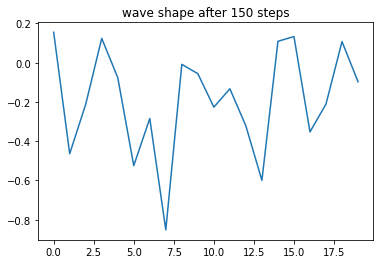

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_150/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_150/model_weights.tf
generator loss:0.8642453735106711
last advantage:[0.10461424]
last log token-prob:[-0.26346933]
last time gaussian:[-0.16957431]
last token entropy:[0.20244488]
last time entropy:[0.04749481]
critic loss:0.02002528227286953
-----------------------
total discriminator loss:0.35169539518017023
average true return:0.5002286372534843
-----------------------


 10%|▉         | 151/1562 [14:01<3:13:36,  8.23s/it]

Training Step: 151
generator loss:0.8324661096424532
last advantage:[0.06340743]
last log token-prob:[-0.35358269]
last time gaussian:[0.26254474]
last token entropy:[0.24827443]
last time entropy:[-0.01815267]
critic loss:0.020226484364149575
-----------------------


 10%|▉         | 152/1562 [14:05<2:43:39,  6.96s/it]

total discriminator loss:0.33497100386178735
average true return:0.49177364179368444
-----------------------
Training Step: 152
generator loss:0.8884148758309542
last advantage:[-0.03143316]
last log token-prob:[-0.2251431]
last time gaussian:[0.45583544]
last token entropy:[0.17975469]
last time entropy:[-0.00233689]
critic loss:0.020149564155608566
-----------------------
total discriminator loss:0.3479391647481222
average true return:0.49781226640628223
-----------------------


 10%|▉         | 153/1562 [14:09<2:21:12,  6.01s/it]

Training Step: 153
generator loss:0.8626363930728427
last advantage:[0.21477804]
last log token-prob:[-0.26985709]
last time gaussian:[0.41232684]
last token entropy:[0.20603281]
last time entropy:[0.02107158]
critic loss:0.018893927003189172
-----------------------
total discriminator loss:0.3028181526529298
average true return:0.49571082481194556
-----------------------


 10%|▉         | 154/1562 [14:13<2:07:26,  5.43s/it]

Training Step: 154
generator loss:0.8519970471001059
last advantage:[-0.05154418]
last log token-prob:[-2.27348655]
last time gaussian:[0.21907988]
last token entropy:[0.23406136]
last time entropy:[0.0895192]
critic loss:0.02153633249407256
-----------------------
total discriminator loss:0.33279146145960226
average true return:0.49747175824343925
-----------------------


 10%|▉         | 155/1562 [14:17<1:58:05,  5.04s/it]

Training Step: 155
event_types: [1, 2, 2, 2, 2, 0, 2, 3, 0, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2]
mad_score: 0.300375
fid_score: 6484.676989226464
rule_score: 0.51075


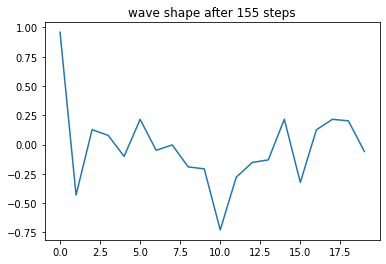

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_155/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_155/model_weights.tf
generator loss:0.8808901980334147
last advantage:[0.0965592]
last log token-prob:[-2.42478087]
last time gaussian:[0.51862387]
last token entropy:[0.21458707]
last time entropy:[-0.02171695]
critic loss:0.020325431357074354
-----------------------


 10%|▉         | 156/1562 [14:33<3:11:35,  8.18s/it]

total discriminator loss:0.31985088927972316
average true return:0.5045831981647559
-----------------------
Training Step: 156
generator loss:0.8507134244382246
last advantage:[0.00332412]
last log token-prob:[-0.25275376]
last time gaussian:[0.52142027]
last token entropy:[0.19630351]
last time entropy:[-0.02835116]
critic loss:0.018967249713734487
-----------------------
total discriminator loss:0.31446559293535997
average true return:0.49798344126785044
-----------------------


 10%|█         | 157/1562 [14:37<2:42:50,  6.95s/it]

Training Step: 157
generator loss:0.8108754633426004
last advantage:[-0.03230115]
last log token-prob:[-0.23889951]
last time gaussian:[-1.35564974]
last token entropy:[0.18813193]
last time entropy:[0.00644778]
critic loss:0.019194787963089016
-----------------------
total discriminator loss:0.32281393108996714
average true return:0.5055365292020688
-----------------------


 10%|█         | 158/1562 [14:41<2:22:45,  6.10s/it]

Training Step: 158
generator loss:0.8001255874815184
last advantage:[0.0226428]
last log token-prob:[-2.4747762]
last time gaussian:[-0.79571688]
last token entropy:[0.20833118]
last time entropy:[-0.05449991]
critic loss:0.019460655812773713
-----------------------
total discriminator loss:0.3333843907344187
average true return:0.507456813712597
-----------------------


 10%|█         | 159/1562 [14:45<2:06:44,  5.42s/it]

Training Step: 159
generator loss:0.8116630437581843
last advantage:[0.08529768]
last log token-prob:[-0.19471371]
last time gaussian:[0.48244296]
last token entropy:[0.16026307]
last time entropy:[-0.0295]
critic loss:0.018368714998359827
-----------------------
total discriminator loss:0.35065848926086424
average true return:0.5055151251032918
-----------------------


 10%|█         | 160/1562 [14:49<1:56:49,  5.00s/it]

Training Step: 160
event_types: [1, 1, 3, 0, 1, 1, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.284925
fid_score: 6495.295579427652
rule_score: 0.54075


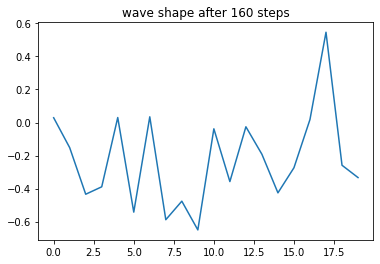

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_160/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_160/model_weights.tf
generator loss:0.8137310307257699
last advantage:[-0.06493548]
last log token-prob:[-0.23289758]
last time gaussian:[-0.25183032]
last token entropy:[0.18450955]
last time entropy:[0.01115632]
critic loss:0.018465523453814046
-----------------------
total discriminator loss:0.3212104719757571
average true return:0.4992506412814176
-----------------------


 10%|█         | 161/1562 [15:05<3:12:31,  8.25s/it]

Training Step: 161
generator loss:0.8405682395150744
last advantage:[0.27722503]
last log token-prob:[-0.18767796]
last time gaussian:[-0.01479636]
last token entropy:[0.15556281]
last time entropy:[-0.05549957]
critic loss:0.018799832208679527
-----------------------


 10%|█         | 162/1562 [15:09<2:42:26,  6.96s/it]

total discriminator loss:0.3700978984259552
average true return:0.5047822607654568
-----------------------
Training Step: 162
generator loss:0.7704696524252322
last advantage:[-0.02116398]
last log token-prob:[-0.20834683]
last time gaussian:[0.41384141]
last token entropy:[0.16916208]
last time entropy:[-0.01523019]
critic loss:0.018639766719607813
-----------------------
total discriminator loss:0.3133579602220324
average true return:0.5064899308615753
-----------------------


 10%|█         | 163/1562 [15:12<2:19:12,  5.97s/it]

Training Step: 163
generator loss:0.7564828692961785
last advantage:[0.04525302]
last log token-prob:[-0.23827426]
last time gaussian:[0.13341227]
last token entropy:[0.18775691]
last time entropy:[0.02717277]
critic loss:0.018319712588314867
-----------------------
total discriminator loss:0.2971004084677994
average true return:0.4921928460994519
-----------------------


 10%|█         | 164/1562 [15:16<2:05:50,  5.40s/it]

Training Step: 164
generator loss:0.7968014207397812
last advantage:[0.04468978]
last log token-prob:[-2.53703391]
last time gaussian:[0.52014938]
last token entropy:[0.20068109]
last time entropy:[-0.05214062]
critic loss:0.019621785973743523
-----------------------
total discriminator loss:2.1910066406973128
average true return:0.4966448122763418
-----------------------


 11%|█         | 165/1562 [15:20<1:56:34,  5.01s/it]

Training Step: 165
event_types: [1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.270025
fid_score: 6547.417032061153
rule_score: 0.52775


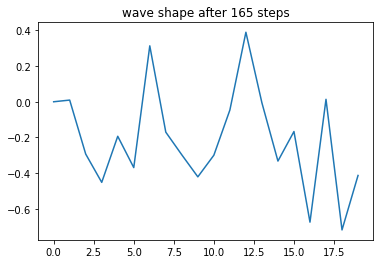

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_165/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_165/model_weights.tf
generator loss:0.7944305011064193
last advantage:[-0.06083663]
last log token-prob:[-0.18736579]
last time gaussian:[0.47099234]
last token entropy:[0.15535254]
last time entropy:[-0.01577932]
critic loss:0.018532848700858508
-----------------------


 11%|█         | 166/1562 [15:36<3:09:51,  8.16s/it]

total discriminator loss:0.360361515015738
average true return:0.497804390067086
-----------------------
Training Step: 166
generator loss:0.8051774251575019
last advantage:[-0.03955136]
last log token-prob:[-0.18720157]
last time gaussian:[0.3173666]
last token entropy:[0.15524187]
last time entropy:[-0.02260084]
critic loss:0.018133359472356756
-----------------------
total discriminator loss:0.3474853331705181
average true return:0.5038702267129094
-----------------------


 11%|█         | 167/1562 [15:40<2:41:10,  6.93s/it]

Training Step: 167
generator loss:0.7801569884522084
last advantage:[0.08597655]
last log token-prob:[-2.63106631]
last time gaussian:[-0.07186736]
last token entropy:[0.1894411]
last time entropy:[0.03320549]
critic loss:0.016348863105928983
-----------------------
total discriminator loss:0.3356330140967664
average true return:0.5091039882867354
-----------------------


 11%|█         | 168/1562 [15:44<2:20:53,  6.06s/it]

Training Step: 168
generator loss:0.7648065313918802
last advantage:[0.00603437]
last log token-prob:[-0.15850638]
last time gaussian:[-0.63771402]
last token entropy:[0.13527212]
last time entropy:[0.00690738]
critic loss:0.017821573484913856
-----------------------
total discriminator loss:0.31430847805406237
average true return:0.500730418473462
-----------------------


 11%|█         | 169/1562 [15:48<2:05:00,  5.38s/it]

Training Step: 169
generator loss:0.7530433459204865
last advantage:[0.0868401]
last log token-prob:[-0.18383748]
last time gaussian:[0.18329031]
last token entropy:[0.15296584]
last time entropy:[0.14073348]
critic loss:0.016654859375864424
-----------------------
total discriminator loss:0.3758198039265825
average true return:0.509942074491535
-----------------------


 11%|█         | 170/1562 [15:52<1:54:34,  4.94s/it]

Training Step: 170
event_types: [1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 1]
mad_score: 0.262075
fid_score: 6543.636291967909
rule_score: 0.5295


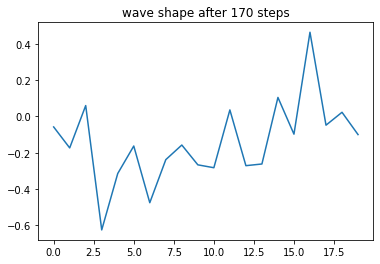

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_170/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_170/model_weights.tf
generator loss:0.7297717144728877
last advantage:[0.00555831]
last log token-prob:[-0.17601147]
last time gaussian:[-1.13886494]
last token entropy:[0.14760469]
last time entropy:[0.00989365]
critic loss:0.017057870850337813
-----------------------
total discriminator loss:0.35036868916759867
average true return:0.5055790686503638
-----------------------


 11%|█         | 171/1562 [16:08<3:10:12,  8.20s/it]

Training Step: 171
generator loss:0.7253041244421417
last advantage:[0.00780817]
last log token-prob:[-0.1931511]
last time gaussian:[0.54765607]
last token entropy:[0.15922554]
last time entropy:[-0.05263519]
critic loss:0.016402193092365937
-----------------------


 11%|█         | 172/1562 [16:12<2:40:38,  6.93s/it]

total discriminator loss:0.33266005337950455
average true return:0.5081057864536319
-----------------------
Training Step: 172
generator loss:0.795969282587736
last advantage:[0.0750801]
last log token-prob:[-0.18365432]
last time gaussian:[-0.27515011]
last token entropy:[0.15284143]
last time entropy:[0.03526307]
critic loss:0.0170916471231179
-----------------------
total discriminator loss:0.3086029799578608
average true return:0.5082391358766896
-----------------------


 11%|█         | 173/1562 [16:15<2:17:56,  5.96s/it]

Training Step: 173
generator loss:0.7223233747018651
last advantage:[0.17372561]
last log token-prob:[-0.16701987]
last time gaussian:[0.30124244]
last token entropy:[0.14132934]
last time entropy:[0.00233124]
critic loss:0.01608228436601228
-----------------------
total discriminator loss:0.328564359490396
average true return:0.5122389495272849
-----------------------


 11%|█         | 174/1562 [16:19<2:05:16,  5.42s/it]

Training Step: 174
generator loss:0.7265695342638235
last advantage:[-0.02330763]
last log token-prob:[-0.14416585]
last time gaussian:[-0.18040627]
last token entropy:[0.12481074]
last time entropy:[0.00286272]
critic loss:0.016318421523839655
-----------------------
total discriminator loss:0.3521708603410939
average true return:0.4976859475657651
-----------------------


 11%|█         | 175/1562 [16:24<1:56:06,  5.02s/it]

Training Step: 175
event_types: [1, 1, 2, 3, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.24795
fid_score: 6550.865178148454
rule_score: 0.5285


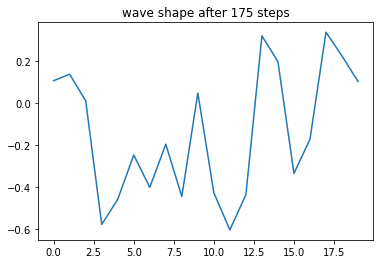

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_175/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_175/model_weights.tf
generator loss:0.6535741648364286
last advantage:[0.07916328]
last log token-prob:[-0.18430599]
last time gaussian:[0.47519452]
last token entropy:[0.15328384]
last time entropy:[0.01697081]
critic loss:0.014613728160096578
-----------------------


 11%|█▏        | 176/1562 [16:39<3:07:48,  8.13s/it]

total discriminator loss:0.3366882030882689
average true return:0.5023823571878603
-----------------------
Training Step: 176
generator loss:0.7169656916731845
last advantage:[0.0818936]
last log token-prob:[-0.14742878]
last time gaussian:[0.46929809]
last token entropy:[0.12721981]
last time entropy:[0.02415272]
critic loss:0.015597003534603252
-----------------------
total discriminator loss:0.31100061935967227
average true return:0.49926231615696726
-----------------------


 11%|█▏        | 177/1562 [16:43<2:39:38,  6.92s/it]

Training Step: 177
generator loss:0.7141049900909948
last advantage:[0.0873895]
last log token-prob:[-0.1602255]
last time gaussian:[0.24155897]
last token entropy:[0.13650438]
last time entropy:[0.04442242]
critic loss:0.015236852532066691
-----------------------
total discriminator loss:0.3261670179416915
average true return:0.49567650013009745
-----------------------


 11%|█▏        | 178/1562 [16:47<2:19:41,  6.06s/it]

Training Step: 178
generator loss:0.7285410442904313
last advantage:[0.10814406]
last log token-prob:[-0.13259579]
last time gaussian:[-0.14052129]
last token entropy:[0.11612992]
last time entropy:[-0.06275049]
critic loss:0.016038050387147493
-----------------------


 11%|█▏        | 179/1562 [16:51<2:03:37,  5.36s/it]

total discriminator loss:0.3255171364898943
average true return:0.4969620154014387
-----------------------
Training Step: 179
generator loss:0.7051842072643739
last advantage:[0.06603561]
last log token-prob:[-0.13529199]
last time gaussian:[0.11494078]
last token entropy:[0.11817226]
last time entropy:[-0.02446944]
critic loss:0.015487797034855935
-----------------------
total discriminator loss:0.3486564554580909
average true return:0.4933158491166411
-----------------------


 12%|█▏        | 180/1562 [16:55<1:53:35,  4.93s/it]

Training Step: 180
event_types: [0, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2]
mad_score: 0.234675
fid_score: 6562.551565691646
rule_score: 0.5205


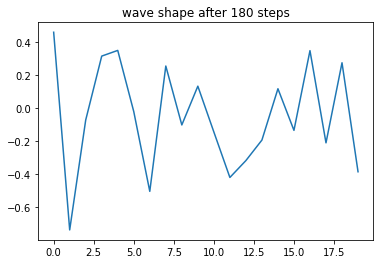

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_180/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_180/model_weights.tf
generator loss:0.730713339294933
last advantage:[0.01829387]
last log token-prob:[-2.83286498]
last time gaussian:[0.50376861]
last token entropy:[0.16669718]
last time entropy:[-0.04290189]
critic loss:0.015091192094200772
-----------------------
total discriminator loss:0.35992302454923164
average true return:0.4892882269243677
-----------------------


 12%|█▏        | 181/1562 [17:10<3:07:46,  8.16s/it]

Training Step: 181
generator loss:0.6680593804064745
last advantage:[0.08443918]
last log token-prob:[-0.12457481]
last time gaussian:[-0.501497]
last token entropy:[0.10998364]
last time entropy:[-0.02379231]
critic loss:0.014500247869653149
-----------------------


 12%|█▏        | 182/1562 [17:14<2:38:31,  6.89s/it]

total discriminator loss:0.3226260204310448
average true return:0.48844523749028884
-----------------------
Training Step: 182
generator loss:0.69063235114269
last advantage:[0.05411962]
last log token-prob:[-0.17745876]
last time gaussian:[0.24101075]
last token entropy:[0.14860317]
last time entropy:[-0.10904254]
critic loss:0.014275943741457773
-----------------------
total discriminator loss:0.3285485920480967
average true return:0.4957140562721246
-----------------------


 12%|█▏        | 183/1562 [17:18<2:16:10,  5.93s/it]

Training Step: 183
generator loss:0.682744205840028
last advantage:[-0.05284747]
last log token-prob:[-0.14752089]
last time gaussian:[0.52149715]
last token entropy:[0.12728758]
last time entropy:[-0.04372343]
critic loss:0.014129201299960342
-----------------------
total discriminator loss:0.347531555822992
average true return:0.49201705291979325
-----------------------


 12%|█▏        | 184/1562 [17:22<2:03:36,  5.38s/it]

Training Step: 184
generator loss:0.6796147067499717
last advantage:[0.13123957]
last log token-prob:[-0.11096787]
last time gaussian:[-0.14184201]
last token entropy:[0.09931264]
last time entropy:[-0.03745077]
critic loss:0.013719947186150794
-----------------------
total discriminator loss:0.3261735324539055
average true return:0.4933714143251573
-----------------------


 12%|█▏        | 185/1562 [17:26<1:54:39,  5.00s/it]

Training Step: 185
event_types: [2, 0, 3, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1]
mad_score: 0.225675
fid_score: 6619.0647546236005
rule_score: 0.50475


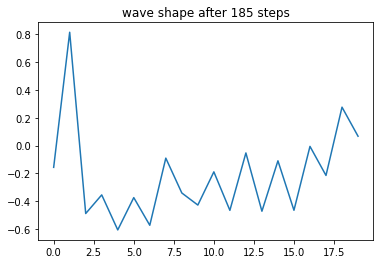

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_185/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_185/model_weights.tf
generator loss:0.6434544590460651
last advantage:[-0.04387905]
last log token-prob:[-2.82737082]
last time gaussian:[0.44313638]
last token entropy:[0.16729048]
last time entropy:[-0.0234825]
critic loss:0.01449132419181065
-----------------------
total discriminator loss:2.045021010039752
average true return:0.4963203964286781
-----------------------


 12%|█▏        | 186/1562 [17:42<3:06:32,  8.13s/it]

Training Step: 186
generator loss:0.6897774929495437
last advantage:[0.0199415]
last log token-prob:[-0.11643448]
last time gaussian:[0.54626316]
last token entropy:[0.10363698]
last time entropy:[-0.11139113]
critic loss:0.014219916826044333
-----------------------
total discriminator loss:0.3612117022326559
average true return:0.507275034268013
-----------------------


 12%|█▏        | 187/1562 [17:46<2:38:40,  6.92s/it]

Training Step: 187
generator loss:0.6649788839241924
last advantage:[0.26328639]
last log token-prob:[-0.12994643]
last time gaussian:[0.44093369]
last token entropy:[0.11411148]
last time entropy:[0.00022902]
critic loss:0.014570062386541311
-----------------------
total discriminator loss:0.34228920026507936
average true return:0.5060049230769096
-----------------------


 12%|█▏        | 188/1562 [17:50<2:19:19,  6.08s/it]

Training Step: 188
generator loss:0.6577858446342204
last advantage:[0.03370719]
last log token-prob:[-0.11563493]
last time gaussian:[0.11302455]
last token entropy:[0.10300764]
last time entropy:[-0.09305021]
critic loss:0.014446308080746942
-----------------------


 12%|█▏        | 189/1562 [17:54<2:03:03,  5.38s/it]

total discriminator loss:0.32694352937306764
average true return:0.4951103074546982
-----------------------
Training Step: 189
generator loss:0.615895396351292
last advantage:[0.13395467]
last log token-prob:[-0.13118607]
last time gaussian:[-0.06652788]
last token entropy:[0.11505734]
last time entropy:[0.06177617]
critic loss:0.014124828774699533
-----------------------
total discriminator loss:0.3407108412304056
average true return:0.5090047473047106
-----------------------


 12%|█▏        | 190/1562 [17:58<1:53:26,  4.96s/it]

Training Step: 190
event_types: [0, 2, 2, 3, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 3, 2, 0, 2, 2, 2]
mad_score: 0.216925
fid_score: 6618.114143808783
rule_score: 0.52125


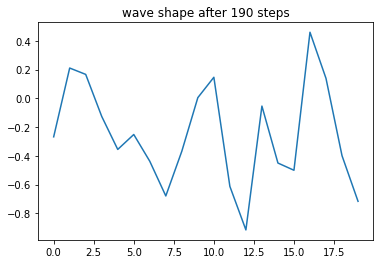

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_190/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_190/model_weights.tf
generator loss:0.593828689327484
last advantage:[-0.06454896]
last log token-prob:[-0.16476582]
last time gaussian:[0.30767216]
last token entropy:[0.13973662]
last time entropy:[-0.01894587]
critic loss:0.015491191617703107
-----------------------
total discriminator loss:0.3175676550059971
average true return:0.5083479145356262
-----------------------


 12%|█▏        | 191/1562 [18:13<3:06:11,  8.15s/it]

Training Step: 191
generator loss:0.6100604382126217
last advantage:[0.10525734]
last log token-prob:[-0.13994885]
last time gaussian:[-0.73987872]
last token entropy:[0.12167191]
last time entropy:[0.11003071]
critic loss:0.014146596243887807
-----------------------


 12%|█▏        | 192/1562 [18:17<2:37:26,  6.90s/it]

total discriminator loss:0.3410012460596523
average true return:0.5037392050187013
-----------------------
Training Step: 192
generator loss:0.6314090210385214
last advantage:[0.10133756]
last log token-prob:[-0.134109]
last time gaussian:[0.49058595]
last token entropy:[0.11727761]
last time entropy:[-0.02503656]
critic loss:0.013149718323411113
-----------------------
total discriminator loss:0.3491747237116608
average true return:0.5123735916450429
-----------------------


 12%|█▏        | 193/1562 [18:21<2:15:33,  5.94s/it]

Training Step: 193
generator loss:0.6670433217114164
last advantage:[-0.03999157]
last log token-prob:[-0.10213077]
last time gaussian:[0.47157393]
last token entropy:[0.09221505]
last time entropy:[-0.00293202]
critic loss:0.014602695222462445
-----------------------
total discriminator loss:0.32780141770866866
average true return:0.5094601049265588
-----------------------


 12%|█▏        | 194/1562 [18:25<2:02:51,  5.39s/it]

Training Step: 194
generator loss:0.6232519649819548
last advantage:[-0.04052935]
last log token-prob:[-0.12526109]
last time gaussian:[0.50668431]
last token entropy:[0.11051366]
last time entropy:[-0.08116841]
critic loss:0.013743610942888682
-----------------------
total discriminator loss:0.3494801039980278
average true return:0.5098418763510693
-----------------------


 12%|█▏        | 195/1562 [18:29<1:54:45,  5.04s/it]

Training Step: 195
event_types: [2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.2086625
fid_score: 6620.076606709331
rule_score: 0.526


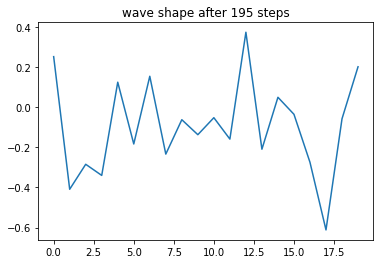

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_195/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_195/model_weights.tf
generator loss:0.6134043957716668
last advantage:[-0.00889265]
last log token-prob:[-0.11803063]
last time gaussian:[0.52525832]
last token entropy:[0.10489014]
last time entropy:[-0.02898271]
critic loss:0.013734188021813332
-----------------------


 13%|█▎        | 196/1562 [18:45<3:05:21,  8.14s/it]

total discriminator loss:0.33553505726637556
average true return:0.5067604028121934
-----------------------
Training Step: 196
generator loss:0.6438859317480137
last advantage:[0.03152103]
last log token-prob:[-0.11086427]
last time gaussian:[0.08080309]
last token entropy:[0.0992302]
last time entropy:[0.00551855]
critic loss:0.013425164548312024
-----------------------
total discriminator loss:0.3413097434949869
average true return:0.5002660359048582
-----------------------


 13%|█▎        | 197/1562 [18:49<2:37:35,  6.93s/it]

Training Step: 197
generator loss:0.6330663707433948
last advantage:[0.28095324]
last log token-prob:[-0.08711452]
last time gaussian:[0.4629037]
last token entropy:[0.07984674]
last time entropy:[-0.05324156]
critic loss:0.013481434894406022
-----------------------
total discriminator loss:0.3327086686525787
average true return:0.5008093458787827
-----------------------


 13%|█▎        | 198/1562 [18:53<2:18:04,  6.07s/it]

Training Step: 198
generator loss:0.6350903925419159
last advantage:[-0.12192212]
last log token-prob:[-0.08104094]
last time gaussian:[0.49237268]
last token entropy:[0.07473238]
last time entropy:[-0.1166322]
critic loss:0.01278475446500349
-----------------------
total discriminator loss:0.3383860451764142
average true return:0.4895563559653018
-----------------------


 13%|█▎        | 199/1562 [18:56<2:02:11,  5.38s/it]

Training Step: 199
generator loss:0.6058402116979396
last advantage:[-0.09019327]
last log token-prob:[-0.11028652]
last time gaussian:[-0.44367653]
last token entropy:[0.09877012]
last time entropy:[-0.01829148]
critic loss:0.013354814899123027
-----------------------
total discriminator loss:0.34339080075607575
average true return:0.4892373176636349
-----------------------


 13%|█▎        | 200/1562 [19:00<1:52:03,  4.94s/it]

Training Step: 200
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
mad_score: 0.2017625
fid_score: 6673.849741621407
rule_score: 0.51375


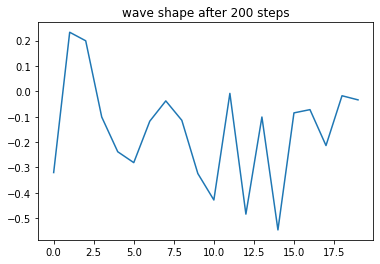

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_200/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_200/model_weights.tf
generator loss:0.6066649803616286
last advantage:[-0.10614821]
last log token-prob:[-0.08770441]
last time gaussian:[0.48509785]
last token entropy:[0.08034001]
last time entropy:[-0.07994381]
critic loss:0.014353927396443361
-----------------------
total discriminator loss:0.3354180906842351
average true return:0.499509204173772
-----------------------


 13%|█▎        | 201/1562 [19:16<3:05:23,  8.17s/it]

Training Step: 201
generator loss:0.5902376674396853
last advantage:[-0.05830672]
last log token-prob:[-0.12735975]
last time gaussian:[-0.89808009]
last token entropy:[0.11212967]
last time entropy:[0.06319564]
critic loss:0.0131582381595633
-----------------------
total discriminator loss:0.33698177590849027
average true return:0.49655497526791564
-----------------------


 13%|█▎        | 202/1562 [19:20<2:36:52,  6.92s/it]

Training Step: 202
generator loss:0.624913622825314
last advantage:[0.02200899]
last log token-prob:[-0.08315059]
last time gaussian:[0.5256538]
last token entropy:[0.07651621]
last time entropy:[-0.05163981]
critic loss:0.012943192860390723
-----------------------
total discriminator loss:0.3273442219558488
average true return:0.48571092933058346
-----------------------


 13%|█▎        | 203/1562 [19:24<2:14:36,  5.94s/it]

Training Step: 203
generator loss:0.629293034907875
last advantage:[-0.09926909]
last log token-prob:[-0.09614135]
last time gaussian:[0.49131769]
last token entropy:[0.08732861]
last time entropy:[-0.04201024]
critic loss:0.013916193490421513
-----------------------
total discriminator loss:0.3186060784687281
average true return:0.49618941981180004
-----------------------


 13%|█▎        | 204/1562 [19:28<2:01:45,  5.38s/it]

Training Step: 204
generator loss:0.5791365881550158
last advantage:[-0.01517329]
last log token-prob:[-0.10907333]
last time gaussian:[0.41649395]
last token entropy:[0.0978022]
last time entropy:[-0.07005856]
critic loss:0.012686313454380382
-----------------------
total discriminator loss:0.3021127865324307
average true return:0.4948183268927695
-----------------------


 13%|█▎        | 205/1562 [19:33<1:57:19,  5.19s/it]

Training Step: 205
event_types: [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2]
mad_score: 0.190425
fid_score: 6740.62658696579
rule_score: 0.52025


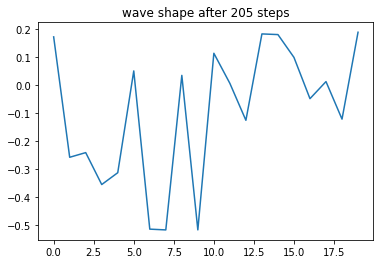

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_205/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_205/model_weights.tf
generator loss:0.5905220262613359
last advantage:[-0.02376639]
last log token-prob:[-0.09531966]
last time gaussian:[0.44323748]
last token entropy:[0.08665342]
last time entropy:[0.02655723]
critic loss:0.013105779934251351
-----------------------
total discriminator loss:0.3427118213939605
average true return:0.49674441214977044
-----------------------


 13%|█▎        | 206/1562 [19:49<3:12:59,  8.54s/it]

Training Step: 206
generator loss:0.5987577461771687
last advantage:[-0.12053655]
last log token-prob:[-0.09051314]
last time gaussian:[0.18206036]
last token entropy:[0.08268034]
last time entropy:[-0.13968802]
critic loss:0.013615516957226717
-----------------------
total discriminator loss:0.34710908266214574
average true return:0.4920187563974922
-----------------------


 13%|█▎        | 207/1562 [19:53<2:43:07,  7.22s/it]

Training Step: 207
generator loss:0.6122907989277225
last advantage:[-0.04949068]
last log token-prob:[-0.09082843]
last time gaussian:[0.60247104]
last token entropy:[0.08294219]
last time entropy:[-0.10262991]
critic loss:0.012987111677786966
-----------------------
total discriminator loss:0.3331968900148476
average true return:0.5002141189485024
-----------------------


 13%|█▎        | 208/1562 [19:57<2:22:08,  6.30s/it]

Training Step: 208
generator loss:0.5952428222978836
last advantage:[0.0805006]
last log token-prob:[-3.62695501]
last time gaussian:[0.48015525]
last token entropy:[0.0964663]
last time entropy:[0.01833412]
critic loss:0.014347852701032305
-----------------------


 13%|█▎        | 209/1562 [20:01<2:04:33,  5.52s/it]

total discriminator loss:0.341279848824663
average true return:0.4857642937297671
-----------------------
Training Step: 209
generator loss:0.6013285770897895
last advantage:[0.00221452]
last log token-prob:[-3.5651576]
last time gaussian:[0.12053269]
last token entropy:[0.10086731]
last time entropy:[-0.04808903]
critic loss:0.013939663246853029
-----------------------
total discriminator loss:0.32743142615793963
average true return:0.49347302361833345
-----------------------


 13%|█▎        | 210/1562 [20:05<1:54:41,  5.09s/it]

Training Step: 210
event_types: [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
mad_score: 0.1847125
fid_score: 6728.617332888659
rule_score: 0.51


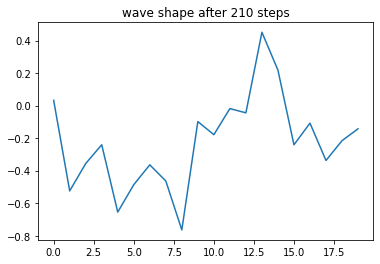

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_210/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_210/model_weights.tf
generator loss:0.6067235013197207
last advantage:[-0.07274077]
last log token-prob:[-0.10354123]
last time gaussian:[0.04578127]
last token entropy:[0.0933568]
last time entropy:[-0.02346132]
critic loss:0.013738234366006939
-----------------------
total discriminator loss:0.3306431959095043
average true return:0.4978218766881929
-----------------------


 14%|█▎        | 211/1562 [20:21<3:07:11,  8.31s/it]

Training Step: 211
generator loss:0.5987800686700667
last advantage:[-0.16333479]
last log token-prob:[-0.08757103]
last time gaussian:[0.25128505]
last token entropy:[0.08022853]
last time entropy:[-0.0994463]
critic loss:0.014190939358911253
-----------------------


 14%|█▎        | 212/1562 [20:25<2:36:58,  6.98s/it]

total discriminator loss:0.3198080203269186
average true return:0.4972277105505231
-----------------------
Training Step: 212
generator loss:0.558373717779898
last advantage:[0.0189149]
last log token-prob:[-0.09320955]
last time gaussian:[0.49658398]
last token entropy:[0.08491414]
last time entropy:[-0.01027884]
critic loss:0.013896597638152111
-----------------------
total discriminator loss:0.35501208126410344
average true return:0.5039988573684719
-----------------------


 14%|█▎        | 213/1562 [20:29<2:15:33,  6.03s/it]

Training Step: 213
generator loss:0.589808834822746
last advantage:[-0.00523609]
last log token-prob:[-0.08964756]
last time gaussian:[-0.12393178]
last token entropy:[0.08196058]
last time entropy:[-0.02532074]
critic loss:0.016448557269139043
-----------------------
total discriminator loss:2.0158316315533376
average true return:0.49887795049415395
-----------------------


 14%|█▎        | 214/1562 [20:33<2:02:26,  5.45s/it]

Training Step: 214
generator loss:0.5796775073683174
last advantage:[0.0040944]
last log token-prob:[-0.07682622]
last time gaussian:[-3.2880916]
last token entropy:[0.07114498]
last time entropy:[0.01644859]
critic loss:0.01415368244190858
-----------------------


 14%|█▍        | 215/1562 [20:37<1:52:43,  5.02s/it]

total discriminator loss:0.3176502192273462
average true return:0.507476589103909
-----------------------
Training Step: 215
event_types: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2]
mad_score: 0.178875
fid_score: 6797.652566599327
rule_score: 0.5005


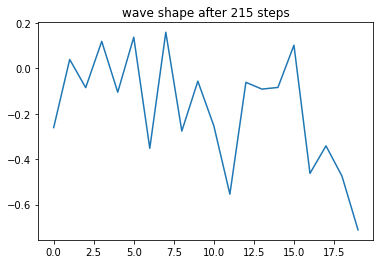

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_215/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_215/model_weights.tf
generator loss:0.567721435058729
last advantage:[-0.03295464]
last log token-prob:[-3.8046212]
last time gaussian:[0.39814288]
last token entropy:[0.0847199]
last time entropy:[-0.08507546]
critic loss:0.013946017647655351
-----------------------
total discriminator loss:0.34169726029613645
average true return:0.5091809449513067
-----------------------


 14%|█▍        | 216/1562 [20:52<3:02:43,  8.14s/it]

Training Step: 216
generator loss:0.5827849863464689
last advantage:[-0.03140895]
last log token-prob:[-0.08428019]
last time gaussian:[0.50724909]
last token entropy:[0.07746814]
last time entropy:[-0.0221586]
critic loss:0.012416919834725763
-----------------------
total discriminator loss:0.2986418469028398
average true return:0.5187399739128791
-----------------------


 14%|█▍        | 217/1562 [20:56<2:35:20,  6.93s/it]

Training Step: 217
generator loss:0.5792674098673567
last advantage:[0.68653997]
last log token-prob:[-3.25430488]
last time gaussian:[0.51883551]
last token entropy:[0.12564106]
last time entropy:[-0.02261615]
critic loss:0.014791365821847563
-----------------------
total discriminator loss:0.3315586650291934
average true return:0.5135850486092465
-----------------------


 14%|█▍        | 218/1562 [21:00<2:16:26,  6.09s/it]

Training Step: 218
generator loss:0.5182980185807067
last advantage:[0.1149489]
last log token-prob:[-0.0704242]
last time gaussian:[-0.29064038]
last token entropy:[0.06563524]
last time entropy:[-0.0468072]
critic loss:0.012913384990838406
-----------------------


 14%|█▍        | 219/1562 [21:04<1:59:32,  5.34s/it]

total discriminator loss:0.3174731906852466
average true return:0.5126095319146289
-----------------------
Training Step: 219
generator loss:0.5662282571053993
last advantage:[0.05338122]
last log token-prob:[-0.05974256]
last time gaussian:[0.59338567]
last token entropy:[0.05627791]
last time entropy:[-0.09427323]
critic loss:0.01245712860020426
-----------------------
total discriminator loss:0.32753789689713764
average true return:0.5110001412138753
-----------------------


 14%|█▍        | 220/1562 [21:08<1:51:00,  4.96s/it]

Training Step: 220
event_types: [1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1743
fid_score: 6812.668914112586
rule_score: 0.487


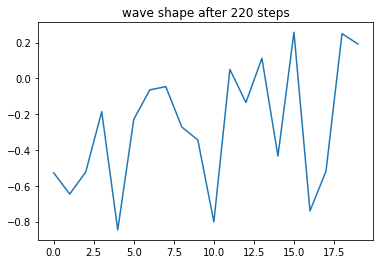

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_220/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_220/model_weights.tf
generator loss:0.5080904852054604
last advantage:[-0.01741242]
last log token-prob:[-0.0836508]
last time gaussian:[-1.54273102]
last token entropy:[0.07693802]
last time entropy:[-0.01600394]
critic loss:0.012542199567427248
-----------------------


 14%|█▍        | 221/1562 [21:22<2:50:43,  7.64s/it]

total discriminator loss:0.3493282143173777
average true return:0.5062097704479971
-----------------------
Training Step: 221
generator loss:0.5189397448564744
last advantage:[-0.01977422]
last log token-prob:[-0.07135932]
last time gaussian:[0.43625708]
last token entropy:[0.06644461]
last time entropy:[-0.07067383]
critic loss:0.01348798388802703
-----------------------


 14%|█▍        | 222/1562 [21:25<2:18:45,  6.21s/it]

total discriminator loss:0.3157775645015917
average true return:0.505776410827603
-----------------------
Training Step: 222
generator loss:0.5491210787166869
last advantage:[-0.03122596]
last log token-prob:[-0.07997701]
last time gaussian:[0.4698101]
last token entropy:[0.07382978]
last time entropy:[0.02345168]
critic loss:0.012587885317825542
-----------------------


 14%|█▍        | 223/1562 [21:28<1:56:20,  5.21s/it]

total discriminator loss:0.31949981071767825
average true return:0.5107410014703773
-----------------------
Training Step: 223
generator loss:0.4990492469477406
last advantage:[0.14517929]
last log token-prob:[-0.06637347]
last time gaussian:[0.11967006]
last token entropy:[0.06211105]
last time entropy:[0.02195793]
critic loss:0.011576579245010458
-----------------------


 14%|█▍        | 224/1562 [21:31<1:40:44,  4.52s/it]

total discriminator loss:0.33291698414717497
average true return:0.5058251881514505
-----------------------
Training Step: 224
generator loss:0.537797665402697
last advantage:[-0.05886478]
last log token-prob:[-0.06937865]
last time gaussian:[0.10072723]
last token entropy:[0.06472844]
last time entropy:[-0.04206398]
critic loss:0.011948567834726694
-----------------------


 14%|█▍        | 225/1562 [21:33<1:29:44,  4.03s/it]

total discriminator loss:0.317900294625881
average true return:0.5058319123386581
-----------------------
Training Step: 225
event_types: [2, 2, 2, 1, 1, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1668
fid_score: 6816.077018187839
rule_score: 0.4825


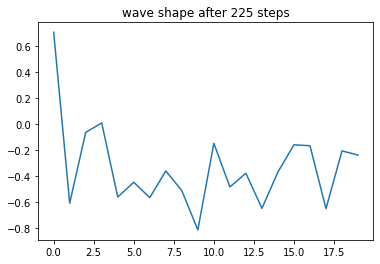

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_225/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_225/model_weights.tf
generator loss:0.5777952330470699
last advantage:[0.06710394]
last log token-prob:[-0.08469673]
last time gaussian:[0.47280462]
last token entropy:[0.07781858]
last time entropy:[-0.1223606]
critic loss:0.011466589516090557
-----------------------


 14%|█▍        | 226/1562 [21:45<2:19:04,  6.25s/it]

total discriminator loss:0.32025671116882903
average true return:0.4972796903790789
-----------------------
Training Step: 226
generator loss:0.5290732602033298
last advantage:[0.0138399]
last log token-prob:[-0.06339063]
last time gaussian:[0.56119507]
last token entropy:[0.05949697]
last time entropy:[-0.06119701]
critic loss:0.01153100364428417
-----------------------


 15%|█▍        | 227/1562 [21:48<1:56:29,  5.24s/it]

total discriminator loss:0.33417313261567544
average true return:0.49207366043072953
-----------------------
Training Step: 227
generator loss:0.5173777988975906
last advantage:[-0.06458378]
last log token-prob:[-0.07056909]
last time gaussian:[-0.36017745]
last token entropy:[0.06576075]
last time entropy:[-0.0534278]
critic loss:0.011334750177393868
-----------------------


 15%|█▍        | 228/1562 [21:51<1:40:49,  4.54s/it]

total discriminator loss:0.33172156956371895
average true return:0.4953704858675071
-----------------------
Training Step: 228
generator loss:0.5408492965403396
last advantage:[0.02518721]
last log token-prob:[-0.06508643]
last time gaussian:[0.47960553]
last token entropy:[0.06098511]
last time entropy:[0.02032762]
critic loss:0.011879965950434206
-----------------------


 15%|█▍        | 229/1562 [21:54<1:29:45,  4.04s/it]

total discriminator loss:0.3257047133331132
average true return:0.48797774318550535
-----------------------
Training Step: 229
generator loss:0.5235346287435205
last advantage:[-0.0494713]
last log token-prob:[-0.06097941]
last time gaussian:[0.63645009]
last token entropy:[0.05737203]
last time entropy:[-0.14191958]
critic loss:0.011319416146755546
-----------------------


 15%|█▍        | 230/1562 [21:56<1:22:15,  3.71s/it]

total discriminator loss:0.3483597650461775
average true return:0.48608027799260034
-----------------------
Training Step: 230
event_types: [1, 3, 0, 0, 2, 2, 3, 3, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2]
mad_score: 0.1601125
fid_score: 6907.793233507668
rule_score: 0.484


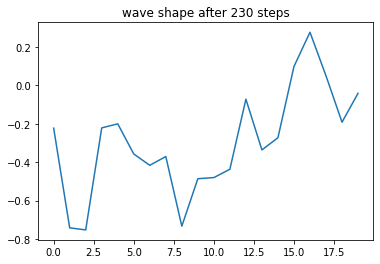

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_230/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_230/model_weights.tf
generator loss:0.5067086030025054
last advantage:[-0.13013676]
last log token-prob:[-0.05749107]
last time gaussian:[0.25268842]
last token entropy:[0.05427906]
last time entropy:[-0.13967594]
critic loss:0.011478674133539448
-----------------------


 15%|█▍        | 231/1562 [22:08<2:13:37,  6.02s/it]

total discriminator loss:0.3273368138313809
average true return:0.4845649211651213
-----------------------
Training Step: 231
generator loss:0.48053473280783476
last advantage:[-0.03952974]
last log token-prob:[-3.78716015]
last time gaussian:[-0.51205847]
last token entropy:[0.08581652]
last time entropy:[0.00493114]
critic loss:0.0117908140379224
-----------------------


 15%|█▍        | 232/1562 [22:11<1:52:45,  5.09s/it]

total discriminator loss:0.3232969213768846
average true return:0.49121590427969886
-----------------------
Training Step: 232
generator loss:0.5219772960601244
last advantage:[-0.03309654]
last log token-prob:[-0.06483365]
last time gaussian:[0.29224802]
last token entropy:[0.06076361]
last time entropy:[-0.0095808]
critic loss:0.011771649790902023
-----------------------


 15%|█▍        | 233/1562 [22:14<1:37:59,  4.42s/it]

total discriminator loss:1.9381934234300255
average true return:0.48779336280766017
-----------------------
Training Step: 233
generator loss:0.4906358108519681
last advantage:[-0.00741678]
last log token-prob:[-0.05015139]
last time gaussian:[-1.62378391]
last token entropy:[0.04769826]
last time entropy:[-0.12837796]
critic loss:0.01164302344311053
-----------------------


 15%|█▍        | 234/1562 [22:17<1:27:41,  3.96s/it]

total discriminator loss:0.3109123703324223
average true return:0.4930652699544594
-----------------------
Training Step: 234
generator loss:0.4982508458303155
last advantage:[0.00043351]
last log token-prob:[-0.07712087]
last time gaussian:[0.40871289]
last token entropy:[0.0713968]
last time entropy:[-0.08922843]
critic loss:0.01161110937227353
-----------------------


 15%|█▌        | 235/1562 [22:19<1:20:32,  3.64s/it]

total discriminator loss:0.29928031614564077
average true return:0.49987345120275006
-----------------------
Training Step: 235
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1558875
fid_score: 6925.43500192322
rule_score: 0.477


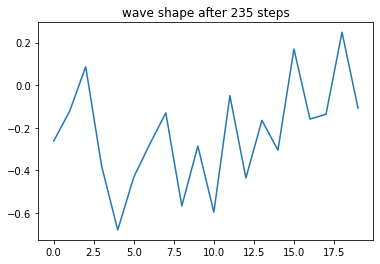

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_235/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_235/model_weights.tf
generator loss:0.5029733294395894
last advantage:[0.05956865]
last log token-prob:[-0.07180426]
last time gaussian:[0.24239682]
last token entropy:[0.06682916]
last time entropy:[0.00367302]
critic loss:0.010813324464614991
-----------------------


 15%|█▌        | 236/1562 [22:31<2:12:40,  6.00s/it]

total discriminator loss:0.322079859299691
average true return:0.5072040646207616
-----------------------
Training Step: 236
generator loss:0.4946262520181561
last advantage:[-0.04295213]
last log token-prob:[-0.06168201]
last time gaussian:[0.36971777]
last token entropy:[0.05799231]
last time entropy:[-0.00175568]
critic loss:0.012318898601678665
-----------------------


 15%|█▌        | 237/1562 [22:34<1:51:55,  5.07s/it]

total discriminator loss:0.32768488461101397
average true return:0.5057728369897779
-----------------------
Training Step: 237
generator loss:0.4699481539107353
last advantage:[-0.09546345]
last log token-prob:[-0.05473011]
last time gaussian:[0.41246579]
last token entropy:[0.05181522]
last time entropy:[-0.11134424]
critic loss:0.010317798404785184
-----------------------


 15%|█▌        | 238/1562 [22:37<1:37:20,  4.41s/it]

total discriminator loss:0.32700108925082755
average true return:0.5079480074446353
-----------------------
Training Step: 238
generator loss:0.5019001787869704
last advantage:[-0.04316601]
last log token-prob:[-0.04575088]
last time gaussian:[0.52678798]
last token entropy:[0.0437049]
last time entropy:[-0.09276934]
critic loss:0.010987854535474554
-----------------------


 15%|█▌        | 239/1562 [22:40<1:27:12,  3.96s/it]

total discriminator loss:0.3496720655356254
average true return:0.505754224835232
-----------------------
Training Step: 239
generator loss:0.5169476028449209
last advantage:[0.05916114]
last log token-prob:[-0.07122615]
last time gaussian:[0.09571692]
last token entropy:[0.06632944]
last time entropy:[-0.00895993]
critic loss:0.010743237635132779
-----------------------


 15%|█▌        | 240/1562 [22:42<1:20:03,  3.63s/it]

total discriminator loss:0.31537411826613704
average true return:0.5023253192634962
-----------------------
Training Step: 240
event_types: [2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.153125
fid_score: 6943.588368236925
rule_score: 0.46525


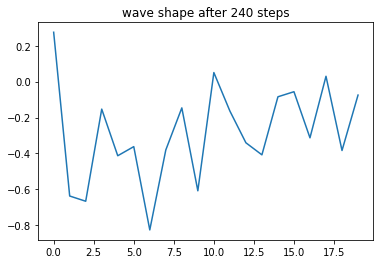

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_240/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_240/model_weights.tf
generator loss:0.49087641642274243
last advantage:[-0.01302103]
last log token-prob:[-0.06330563]
last time gaussian:[-0.07096797]
last token entropy:[0.05942224]
last time entropy:[0.04085463]
critic loss:0.010503920054571615
-----------------------


 15%|█▌        | 241/1562 [22:54<2:11:52,  5.99s/it]

total discriminator loss:0.3338549000860011
average true return:0.504303288183279
-----------------------
Training Step: 241
generator loss:0.42191029690435844
last advantage:[-0.04316966]
last log token-prob:[-0.05579491]
last time gaussian:[-1.82090474]
last token entropy:[0.05276709]
last time entropy:[-0.05630235]
critic loss:0.009853276130483316
-----------------------


 15%|█▌        | 242/1562 [22:57<1:51:16,  5.06s/it]

total discriminator loss:0.3111970825907002
average true return:0.509349960905789
-----------------------
Training Step: 242
generator loss:0.45227638102111073
last advantage:[0.02075407]
last log token-prob:[-0.05370057]
last time gaussian:[0.07776881]
last token entropy:[0.05089288]
last time entropy:[-0.06925462]
critic loss:0.010143981689082766
-----------------------


 16%|█▌        | 243/1562 [23:00<1:36:54,  4.41s/it]

total discriminator loss:0.32058593626286525
average true return:0.506667881673762
-----------------------
Training Step: 243
generator loss:0.4906192025664925
last advantage:[0.16380049]
last log token-prob:[-0.05575958]
last time gaussian:[0.42830387]
last token entropy:[0.05273554]
last time entropy:[-0.03844848]
critic loss:0.010579355393439438
-----------------------


 16%|█▌        | 244/1562 [23:03<1:26:48,  3.95s/it]

total discriminator loss:0.34692109287049666
average true return:0.5104677957915664
-----------------------
Training Step: 244
generator loss:0.5197833182387849
last advantage:[-0.03368999]
last log token-prob:[-0.0539905]
last time gaussian:[0.52024659]
last token entropy:[0.05115282]
last time entropy:[-0.08864984]
critic loss:0.011129102483111945
-----------------------


 16%|█▌        | 245/1562 [23:06<1:19:45,  3.63s/it]

total discriminator loss:0.3356658134112125
average true return:0.5118242084307785
-----------------------
Training Step: 245
event_types: [0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1474875
fid_score: 6943.833947286406
rule_score: 0.46225


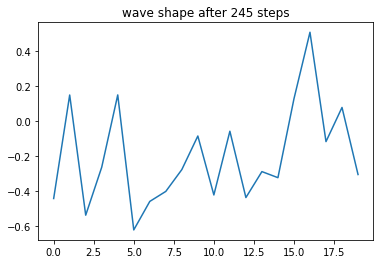

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_245/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_245/model_weights.tf
generator loss:0.48295223250875957
last advantage:[-0.03044703]
last log token-prob:[-0.05371584]
last time gaussian:[0.33671853]
last token entropy:[0.05090657]
last time entropy:[-0.0430542]
critic loss:0.010631272289638258
-----------------------


 16%|█▌        | 246/1562 [23:17<2:10:42,  5.96s/it]

total discriminator loss:0.32864012343049165
average true return:0.5104290878239379
-----------------------
Training Step: 246
generator loss:0.4731764215579733
last advantage:[-0.07562154]
last log token-prob:[-0.04350841]
last time gaussian:[0.53320088]
last token entropy:[0.04165602]
last time entropy:[-0.07009899]
critic loss:0.009709872595008107
-----------------------


 16%|█▌        | 247/1562 [23:20<1:50:26,  5.04s/it]

total discriminator loss:1.8099382315152526
average true return:0.4944526506654469
-----------------------
Training Step: 247
generator loss:0.4634998387183094
last advantage:[-0.0386737]
last log token-prob:[-0.04776812]
last time gaussian:[-0.62065766]
last token entropy:[0.04553997]
last time entropy:[-0.00894405]
critic loss:0.00973677498369466
-----------------------


 16%|█▌        | 248/1562 [23:23<1:36:12,  4.39s/it]

total discriminator loss:0.3166545048616944
average true return:0.4991818631373536
-----------------------
Training Step: 248
generator loss:0.46653095938212197
last advantage:[-0.06037757]
last log token-prob:[-0.04979812]
last time gaussian:[0.56482704]
last token entropy:[0.047379]
last time entropy:[-0.06813978]
critic loss:0.009999990731807594
-----------------------


 16%|█▌        | 249/1562 [23:26<1:26:14,  3.94s/it]

total discriminator loss:0.32841943538696444
average true return:0.49878608575459793
-----------------------
Training Step: 249
generator loss:0.5013296837769363
last advantage:[-0.06277533]
last log token-prob:[-0.04314983]
last time gaussian:[-0.88316311]
last token entropy:[0.04132752]
last time entropy:[-0.11543128]
critic loss:0.009287213415733658
-----------------------


 16%|█▌        | 250/1562 [23:29<1:19:31,  3.64s/it]

total discriminator loss:0.3185603242113301
average true return:0.5045583044743818
-----------------------
Training Step: 250
event_types: [2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.14335
fid_score: 6957.191605276612
rule_score: 0.4305


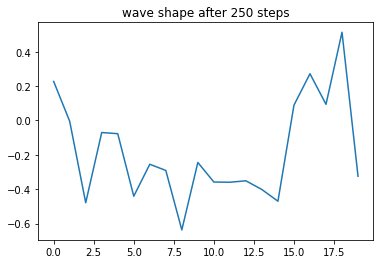

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_250/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_250/model_weights.tf
generator loss:0.4593493946537319
last advantage:[0.02884896]
last log token-prob:[-0.04442991]
last time gaussian:[0.37279156]
last token entropy:[0.04249911]
last time entropy:[-0.09539676]
critic loss:0.009283999895564273
-----------------------


 16%|█▌        | 251/1562 [23:40<2:10:24,  5.97s/it]

total discriminator loss:0.32701456648547433
average true return:0.5067643563348452
-----------------------
Training Step: 251
generator loss:0.5223472510835425
last advantage:[-0.01420058]
last log token-prob:[-0.05319068]
last time gaussian:[0.539715]
last token entropy:[0.05043536]
last time entropy:[-0.06664028]
critic loss:0.010164509895589443
-----------------------


 16%|█▌        | 252/1562 [23:43<1:50:06,  5.04s/it]

total discriminator loss:0.3333308480407275
average true return:0.5060496244821082
-----------------------
Training Step: 252
generator loss:0.43988030405165235
last advantage:[-0.07930873]
last log token-prob:[-0.03999262]
last time gaussian:[0.61594671]
last token entropy:[0.03842477]
last time entropy:[-0.11885659]
critic loss:0.009136205505836886
-----------------------


 16%|█▌        | 253/1562 [23:46<1:35:55,  4.40s/it]

total discriminator loss:0.3211256065435446
average true return:0.5010317610841024
-----------------------
Training Step: 253
generator loss:0.4470133776436394
last advantage:[-0.09354756]
last log token-prob:[-0.04604885]
last time gaussian:[0.36606443]
last token entropy:[0.04397644]
last time entropy:[-0.05380146]
critic loss:0.009574428585794631
-----------------------


 16%|█▋        | 254/1562 [23:49<1:25:56,  3.94s/it]

total discriminator loss:0.3527081464032664
average true return:0.4988273442664619
-----------------------
Training Step: 254
generator loss:0.4673559060489002
last advantage:[-0.03321865]
last log token-prob:[-4.09317192]
last time gaussian:[0.57567546]
last token entropy:[0.06829958]
last time entropy:[-0.09181219]
critic loss:0.009049577465320886
-----------------------
total discriminator loss:0.34076586861679886
average true return:0.49769233567269117
-----------------------


 16%|█▋        | 255/1562 [23:52<1:24:58,  3.90s/it]

Training Step: 255
event_types: [1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]
mad_score: 0.1396
fid_score: 7040.406540345731
rule_score: 0.438


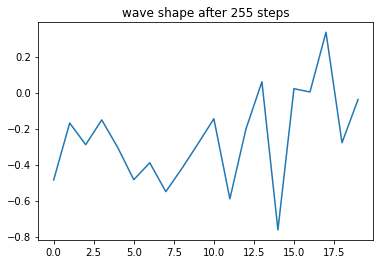

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_255/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_255/model_weights.tf
generator loss:0.4501684480342812
last advantage:[-0.04895665]
last log token-prob:[-0.05184057]
last time gaussian:[-0.10529504]
last token entropy:[0.04922159]
last time entropy:[-0.07704341]
critic loss:0.00942817491241592
-----------------------


 16%|█▋        | 256/1562 [24:07<2:31:48,  6.97s/it]

total discriminator loss:0.3302723310678427
average true return:0.4946169849082533
-----------------------
Training Step: 256
generator loss:0.4323850988105799
last advantage:[-0.09961885]
last log token-prob:[-0.05508272]
last time gaussian:[0.3775423]
last token entropy:[0.05213066]
last time entropy:[0.00930818]
critic loss:0.008977176181071429
-----------------------


 16%|█▋        | 257/1562 [24:09<2:05:03,  5.75s/it]

total discriminator loss:0.333710146682095
average true return:0.4904601566698607
-----------------------
Training Step: 257
generator loss:0.43560780157537077
last advantage:[-0.01927564]
last log token-prob:[-0.05096424]
last time gaussian:[0.47890783]
last token entropy:[0.04843196]
last time entropy:[-0.10271937]
critic loss:0.009057772022505722
-----------------------


 17%|█▋        | 258/1562 [24:12<1:46:16,  4.89s/it]

total discriminator loss:0.31953102636262437
average true return:0.49688201040249796
-----------------------
Training Step: 258
generator loss:0.4399323634672805
last advantage:[-0.10726645]
last log token-prob:[-0.04559992]
last time gaussian:[0.48610799]
last token entropy:[0.04356727]
last time entropy:[-0.06869737]
critic loss:0.009712177378995305
-----------------------


 17%|█▋        | 259/1562 [24:15<1:33:07,  4.29s/it]

total discriminator loss:0.34230793662059156
average true return:0.48591300794852577
-----------------------
Training Step: 259
generator loss:0.4602103850166763
last advantage:[-0.11009297]
last log token-prob:[-0.04332269]
last time gaussian:[0.6248967]
last token entropy:[0.04148591]
last time entropy:[-0.13331624]
critic loss:0.00904885829671152
-----------------------


 17%|█▋        | 260/1562 [24:18<1:23:54,  3.87s/it]

total discriminator loss:0.3365073575990263
average true return:0.4888226799613522
-----------------------
Training Step: 260
event_types: [2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1377125
fid_score: 7119.539460386277
rule_score: 0.41625


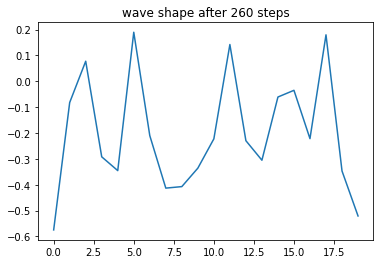

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_260/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_260/model_weights.tf
generator loss:0.42674853858534245
last advantage:[-0.03105815]
last log token-prob:[-0.04359215]
last time gaussian:[-0.90020766]
last token entropy:[0.0417327]
last time entropy:[-0.03637269]
critic loss:0.00956696699397151
-----------------------


 17%|█▋        | 261/1562 [24:29<2:12:34,  6.11s/it]

total discriminator loss:0.33845778706099583
average true return:0.489823044324024
-----------------------
Training Step: 261
generator loss:0.43066142356543036
last advantage:[-0.13281186]
last log token-prob:[-0.04916587]
last time gaussian:[-0.4860016]
last token entropy:[0.04680705]
last time entropy:[-0.07851975]
critic loss:0.009663386365022213
-----------------------


 17%|█▋        | 262/1562 [24:32<1:51:29,  5.15s/it]

total discriminator loss:0.31307575636089635
average true return:0.494779268998617
-----------------------
Training Step: 262
generator loss:0.4451040851428673
last advantage:[-0.10392267]
last log token-prob:[-0.0356045]
last time gaussian:[0.54498102]
last token entropy:[0.03435912]
last time entropy:[-0.08619713]
critic loss:0.009752629544600088
-----------------------


 17%|█▋        | 263/1562 [24:35<1:36:42,  4.47s/it]

total discriminator loss:0.3472586453991756
average true return:0.4908128248921114
-----------------------
Training Step: 263
generator loss:0.406608851407701
last advantage:[0.13273152]
last log token-prob:[-0.05475532]
last time gaussian:[-2.02959445]
last token entropy:[0.05183778]
last time entropy:[0.00965724]
critic loss:0.010289917874533677
-----------------------


 17%|█▋        | 264/1562 [24:38<1:26:21,  3.99s/it]

total discriminator loss:1.836425872716751
average true return:0.48856212868203125
-----------------------
Training Step: 264
generator loss:0.42992557955687916
last advantage:[-6.81317534e-05]
last log token-prob:[-0.03908314]
last time gaussian:[-1.69260403]
last token entropy:[0.03758511]
last time entropy:[-0.03163597]
critic loss:0.009524122397658343
-----------------------


 17%|█▋        | 265/1562 [24:41<1:19:24,  3.67s/it]

total discriminator loss:0.3337175218516599
average true return:0.49591746461803066
-----------------------
Training Step: 265
event_types: [1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1]
mad_score: 0.1333125
fid_score: 7137.4219157484595
rule_score: 0.39575


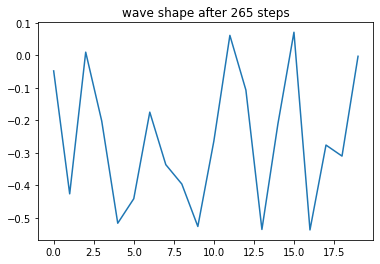

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_265/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_265/model_weights.tf
generator loss:0.42223852794138494
last advantage:[-0.05248646]
last log token-prob:[-0.04911313]
last time gaussian:[-0.77443668]
last token entropy:[0.04675931]
last time entropy:[-0.05222057]
critic loss:0.00888897388620957
-----------------------


 17%|█▋        | 266/1562 [24:52<2:09:55,  6.02s/it]

total discriminator loss:0.34498783864004445
average true return:0.4971499871117102
-----------------------
Training Step: 266
generator loss:0.4577711491507511
last advantage:[0.07819427]
last log token-prob:[-0.03832203]
last time gaussian:[0.61277613]
last token entropy:[0.03688124]
last time entropy:[-0.1156936]
critic loss:0.009521927717167126
-----------------------


 17%|█▋        | 267/1562 [24:55<1:49:41,  5.08s/it]

total discriminator loss:0.3266943962053127
average true return:0.5048508917828708
-----------------------
Training Step: 267
generator loss:0.43994921896070965
last advantage:[-0.07719279]
last log token-prob:[-0.03957736]
last time gaussian:[0.54337112]
last token entropy:[0.03804159]
last time entropy:[-0.09274235]
critic loss:0.008930273100779186
-----------------------


 17%|█▋        | 268/1562 [24:58<1:35:25,  4.42s/it]

total discriminator loss:1.7481982776285685
average true return:0.5094764023593084
-----------------------
Training Step: 268
generator loss:0.4427735676254242
last advantage:[-0.03634361]
last log token-prob:[-0.04431278]
last time gaussian:[0.47830696]
last token entropy:[0.04239203]
last time entropy:[-0.01374967]
critic loss:0.008858389462260318
-----------------------


 17%|█▋        | 269/1562 [25:01<1:25:26,  3.96s/it]

total discriminator loss:0.3585008745818964
average true return:0.518950288151434
-----------------------
Training Step: 269
generator loss:0.44824062851188173
last advantage:[-0.04104367]
last log token-prob:[-0.04186997]
last time gaussian:[-0.02467816]
last token entropy:[0.04015307]
last time entropy:[-0.05390945]
critic loss:0.010400517378775911
-----------------------


 17%|█▋        | 270/1562 [25:04<1:18:45,  3.66s/it]

total discriminator loss:0.3433731111554966
average true return:0.5232761861580314
-----------------------
Training Step: 270
event_types: [1, 1, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.13055
fid_score: 7173.903774724459
rule_score: 0.40375


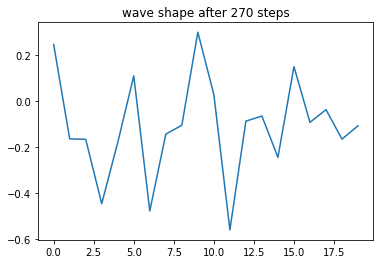

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_270/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_270/model_weights.tf
generator loss:0.4581707739296316
last advantage:[0.04181621]
last log token-prob:[-0.03768245]
last time gaussian:[0.06652456]
last token entropy:[0.0362889]
last time entropy:[-0.05858558]
critic loss:0.010280454231306673
-----------------------


 17%|█▋        | 271/1562 [25:16<2:10:20,  6.06s/it]

total discriminator loss:0.3251786908515917
average true return:0.5221048047597506
-----------------------
Training Step: 271
generator loss:0.44446790620005583
last advantage:[0.09940807]
last log token-prob:[-0.03476278]
last time gaussian:[0.29769532]
last token entropy:[0.03357509]
last time entropy:[-0.06883398]
critic loss:0.01122224785042893
-----------------------


 17%|█▋        | 272/1562 [25:19<1:49:52,  5.11s/it]

total discriminator loss:1.6283642654258526
average true return:0.5253656949477605
-----------------------
Training Step: 272
generator loss:0.4162150319209328
last advantage:[-0.01288763]
last log token-prob:[-0.04088436]
last time gaussian:[-0.00948175]
last token entropy:[0.03924654]
last time entropy:[-0.05513547]
critic loss:0.012915783179241483
-----------------------


 17%|█▋        | 273/1562 [25:22<1:35:28,  4.44s/it]

total discriminator loss:0.34430544598647145
average true return:0.5320967606450033
-----------------------
Training Step: 273
generator loss:0.3932609312888675
last advantage:[0.05985812]
last log token-prob:[-0.03077969]
last time gaussian:[0.4176234]
last token entropy:[0.02984674]
last time entropy:[-0.0240263]
critic loss:0.013667435029657907
-----------------------


 18%|█▊        | 274/1562 [25:24<1:25:21,  3.98s/it]

total discriminator loss:0.3490577935718117
average true return:0.5330116970499809
-----------------------
Training Step: 274
generator loss:0.4207509786051732
last advantage:[0.01299444]
last log token-prob:[-0.03910564]
last time gaussian:[0.09069688]
last token entropy:[0.0376059]
last time entropy:[-0.05093083]
critic loss:0.012387298744839362
-----------------------


 18%|█▊        | 275/1562 [25:27<1:18:18,  3.65s/it]

total discriminator loss:0.3563303632405219
average true return:0.5378382407102874
-----------------------
Training Step: 275
event_types: [3, 0, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1279375
fid_score: 7211.93408738937
rule_score: 0.3895


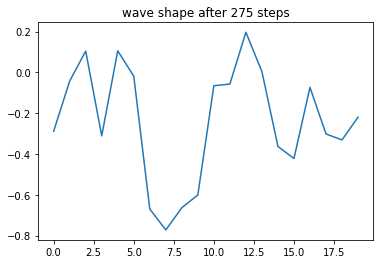

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_275/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_275/model_weights.tf
generator loss:0.4175516135167118
last advantage:[0.04692626]
last log token-prob:[-0.05009638]
last time gaussian:[0.47064462]
last token entropy:[0.04764856]
last time entropy:[-0.0613763]
critic loss:0.013232930463789714
-----------------------


 18%|█▊        | 276/1562 [25:39<2:08:16,  5.99s/it]

total discriminator loss:1.5150881700651708
average true return:0.5314333836883429
-----------------------
Training Step: 276
generator loss:0.41913719308097175
last advantage:[0.15172417]
last log token-prob:[-0.05637233]
last time gaussian:[-0.15421041]
last token entropy:[0.0532824]
last time entropy:[-0.01643733]
critic loss:0.012450314408505603
-----------------------


 18%|█▊        | 277/1562 [25:42<1:48:18,  5.06s/it]

total discriminator loss:0.35949343206437223
average true return:0.5326008019967697
-----------------------
Training Step: 277
generator loss:0.4143112280158035
last advantage:[-0.04685757]
last log token-prob:[-0.04022669]
last time gaussian:[0.51316529]
last token entropy:[0.03864062]
last time entropy:[-0.01335448]
critic loss:0.011942188101521764
-----------------------


 18%|█▊        | 278/1562 [25:45<1:34:16,  4.41s/it]

total discriminator loss:0.36870153176584614
average true return:0.5278499862968975
-----------------------
Training Step: 278
generator loss:0.4058308812838899
last advantage:[0.01036108]
last log token-prob:[-0.04027903]
last time gaussian:[-1.07315419]
last token entropy:[0.03868887]
last time entropy:[-0.05594808]
critic loss:0.010574674183172502
-----------------------


 18%|█▊        | 279/1562 [25:47<1:24:25,  3.95s/it]

total discriminator loss:0.3657448835014804
average true return:0.5274360604543811
-----------------------
Training Step: 279
generator loss:0.4587124492008833
last advantage:[-0.02950935]
last log token-prob:[-0.03344437]
last time gaussian:[0.4949183]
last token entropy:[0.03234434]
last time entropy:[-0.04714931]
critic loss:0.010871628951899368
-----------------------


 18%|█▊        | 280/1562 [25:50<1:17:51,  3.64s/it]

total discriminator loss:0.3803240968662691
average true return:0.5231702153687071
-----------------------
Training Step: 280
event_types: [1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1262375
fid_score: 7248.243247797689
rule_score: 0.37425


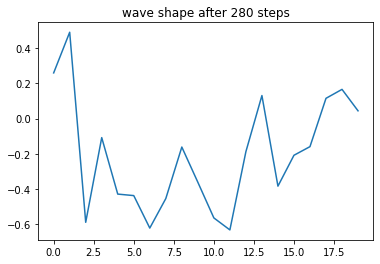

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_280/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_280/model_weights.tf
generator loss:0.42331978218574323
last advantage:[-0.07065221]
last log token-prob:[-0.03302469]
last time gaussian:[0.09362939]
last token entropy:[0.03195187]
last time entropy:[-0.04863495]
critic loss:0.008961798046789437
-----------------------


 18%|█▊        | 281/1562 [26:02<2:07:54,  5.99s/it]

total discriminator loss:0.3697941502670602
average true return:0.5139205005179636
-----------------------
Training Step: 281
generator loss:0.43505352238523337
last advantage:[-0.00123263]
last log token-prob:[-0.04329713]
last time gaussian:[0.49031822]
last token entropy:[0.0414625]
last time entropy:[-0.06632046]
critic loss:0.008390952060519185
-----------------------


 18%|█▊        | 282/1562 [26:05<1:47:58,  5.06s/it]

total discriminator loss:0.3811360145256911
average true return:0.5072015728052336
-----------------------
Training Step: 282
generator loss:0.40862927903154694
last advantage:[-0.15074408]
last log token-prob:[-0.03164795]
last time gaussian:[0.56450886]
last token entropy:[0.03066204]
last time entropy:[-0.06859232]
critic loss:0.007979794361170639
-----------------------


 18%|█▊        | 283/1562 [26:08<1:33:57,  4.41s/it]

total discriminator loss:0.38616445552162454
average true return:0.5056008025845987
-----------------------
Training Step: 283
generator loss:0.42780188000090724
last advantage:[-0.09110101]
last log token-prob:[-0.03313471]
last time gaussian:[0.5678791]
last token entropy:[0.03205479]
last time entropy:[-0.09872165]
critic loss:0.007908854162611192
-----------------------


 18%|█▊        | 284/1562 [26:10<1:24:12,  3.95s/it]

total discriminator loss:0.3739903232563716
average true return:0.4965378976668389
-----------------------
Training Step: 284
generator loss:0.38870909250432245
last advantage:[-0.10561161]
last log token-prob:[-0.03407444]
last time gaussian:[0.15327669]
last token entropy:[0.03293293]
last time entropy:[-0.04473436]
critic loss:0.007491618277606924
-----------------------


 18%|█▊        | 285/1562 [26:13<1:17:22,  3.64s/it]

total discriminator loss:1.4043048644969278
average true return:0.49638525286769586
-----------------------
Training Step: 285
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1205875
fid_score: 7359.422776735782
rule_score: 0.37275


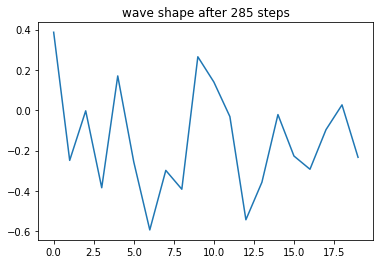

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_285/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_285/model_weights.tf
generator loss:0.3846177952908576
last advantage:[-0.08158677]
last log token-prob:[-0.02929849]
last time gaussian:[0.45177193]
last token entropy:[0.02845254]
last time entropy:[-0.07458441]
critic loss:0.007757910070768629
-----------------------


 18%|█▊        | 286/1562 [26:25<2:06:44,  5.96s/it]

total discriminator loss:0.3859320865374073
average true return:0.48952210599787005
-----------------------
Training Step: 286
generator loss:0.404729201935884
last advantage:[-0.05327344]
last log token-prob:[-0.0371722]
last time gaussian:[0.47457293]
last token entropy:[0.03581579]
last time entropy:[-0.04891121]
critic loss:0.008018256310165572
-----------------------


 18%|█▊        | 287/1562 [26:28<1:47:05,  5.04s/it]

total discriminator loss:0.3677087520375438
average true return:0.4899893524385859
-----------------------
Training Step: 287
generator loss:0.40166634512776334
last advantage:[-0.07746662]
last log token-prob:[-0.02978179]
last time gaussian:[-2.44052857]
last token entropy:[0.02890791]
last time entropy:[-0.0831445]
critic loss:0.007912675579466422
-----------------------


 18%|█▊        | 288/1562 [26:31<1:33:24,  4.40s/it]

total discriminator loss:0.4035070177862413
average true return:0.49028007130252343
-----------------------
Training Step: 288
generator loss:0.3796857596862722
last advantage:[-0.12014945]
last log token-prob:[-0.03265634]
last time gaussian:[0.00648614]
last token entropy:[0.03160713]
last time entropy:[-0.05869123]
critic loss:0.007621140313010724
-----------------------


 19%|█▊        | 289/1562 [26:33<1:23:47,  3.95s/it]

total discriminator loss:0.3888374556337293
average true return:0.490112753286718
-----------------------
Training Step: 289
generator loss:0.43127336494820623
last advantage:[-0.09203478]
last log token-prob:[-0.0359809]
last time gaussian:[-0.38888848]
last token entropy:[0.03470929]
last time entropy:[-0.08633039]
critic loss:0.008614270167846442
-----------------------


 19%|█▊        | 290/1562 [26:36<1:17:02,  3.63s/it]

total discriminator loss:0.37427612421311934
average true return:0.48028403630031746
-----------------------
Training Step: 290
event_types: [1, 3, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]
mad_score: 0.117575
fid_score: 7380.966589160584
rule_score: 0.36075


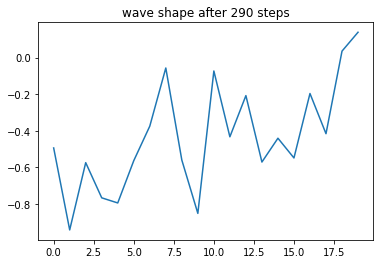

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_290/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_290/model_weights.tf
generator loss:0.4046749979671393
last advantage:[-0.10812434]
last log token-prob:[-0.0304803]
last time gaussian:[-0.68553203]
last token entropy:[0.02956527]
last time entropy:[-0.06194201]
critic loss:0.00782498607175838
-----------------------


 19%|█▊        | 291/1562 [26:50<2:22:54,  6.75s/it]

total discriminator loss:0.3839437950084266
average true return:0.47985054963657564
-----------------------
Training Step: 291
generator loss:0.4194414957932472
last advantage:[-0.14013003]
last log token-prob:[-0.0326626]
last time gaussian:[0.47393428]
last token entropy:[0.03161299]
last time entropy:[-0.01777367]
critic loss:0.008052857952920177
-----------------------


 19%|█▊        | 292/1562 [26:53<1:58:20,  5.59s/it]

total discriminator loss:1.4305703091870343
average true return:0.4889058578066403
-----------------------
Training Step: 292
generator loss:0.4237156403601633
last advantage:[-0.07020129]
last log token-prob:[-0.03120422]
last time gaussian:[0.41506815]
last token entropy:[0.03024555]
last time entropy:[-0.03754258]
critic loss:0.007265315543194052
-----------------------


 19%|█▉        | 293/1562 [26:56<1:41:02,  4.78s/it]

total discriminator loss:0.3700003130182537
average true return:0.49317160089365386
-----------------------
Training Step: 293
generator loss:0.41521932417405855
last advantage:[-0.07294652]
last log token-prob:[-0.03344638]
last time gaussian:[0.53670421]
last token entropy:[0.03234622]
last time entropy:[-0.05241545]
critic loss:0.0071915839825830285
-----------------------


 19%|█▉        | 294/1562 [26:59<1:28:55,  4.21s/it]

total discriminator loss:0.39013073428533984
average true return:0.48772113687637175
-----------------------
Training Step: 294
generator loss:0.38216936550448927
last advantage:[-0.07450781]
last log token-prob:[-0.03275922]
last time gaussian:[0.21165592]
last token entropy:[0.03170344]
last time entropy:[-0.12205609]
critic loss:0.006685108175130479
-----------------------


 19%|█▉        | 295/1562 [27:02<1:20:32,  3.81s/it]

total discriminator loss:0.3583587426179517
average true return:0.49209894143170085
-----------------------
Training Step: 295
event_types: [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2]
mad_score: 0.1168625
fid_score: 7369.658472818583
rule_score: 0.3325


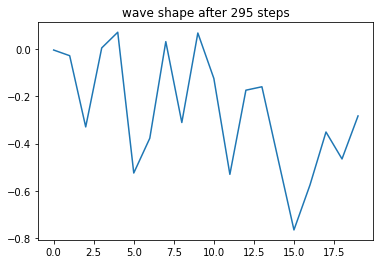

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_295/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_295/model_weights.tf
generator loss:0.41856916949924533
last advantage:[-0.0943506]
last log token-prob:[-0.03736944]
last time gaussian:[-0.07539295]
last token entropy:[0.03599873]
last time entropy:[-0.10128901]
critic loss:0.006628366103348553
-----------------------


 19%|█▉        | 296/1562 [27:13<2:08:58,  6.11s/it]

total discriminator loss:0.36236545872289116
average true return:0.498798978760334
-----------------------
Training Step: 296
generator loss:0.3859746594622028
last advantage:[-0.08600628]
last log token-prob:[-0.03422262]
last time gaussian:[-2.51503269]
last token entropy:[0.03307125]
last time entropy:[-0.03405856]
critic loss:0.0060464094024509345
-----------------------


 19%|█▉        | 297/1562 [27:16<1:48:28,  5.15s/it]

total discriminator loss:0.37169638394743587
average true return:0.49781013154815257
-----------------------
Training Step: 297
generator loss:0.4021414916625938
last advantage:[-0.09383282]
last log token-prob:[-0.03258223]
last time gaussian:[0.21738962]
last token entropy:[0.03153774]
last time entropy:[-0.05773564]
critic loss:0.006250269878329126
-----------------------


 19%|█▉        | 298/1562 [27:19<1:34:09,  4.47s/it]

total discriminator loss:0.3630030517094047
average true return:0.4952679900100171
-----------------------
Training Step: 298
generator loss:0.37310058807291374
last advantage:[-0.05002581]
last log token-prob:[-0.03671005]
last time gaussian:[0.50729437]
last token entropy:[0.03538686]
last time entropy:[-0.09423965]
critic loss:0.00625492209633158
-----------------------


 19%|█▉        | 299/1562 [27:22<1:24:11,  4.00s/it]

total discriminator loss:0.35715571628738485
average true return:0.5063064381655114
-----------------------
Training Step: 299
generator loss:0.42440836727820486
last advantage:[-0.0290882]
last log token-prob:[-4.38495283]
last time gaussian:[0.5305702]
last token entropy:[0.05465175]
last time entropy:[-0.0694067]
critic loss:0.006352781064975504
-----------------------


 19%|█▉        | 300/1562 [27:25<1:17:04,  3.66s/it]

total discriminator loss:0.3565109097202566
average true return:0.49830316052611345
-----------------------
Training Step: 300
event_types: [0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1134875
fid_score: 7463.091708255395
rule_score: 0.32575


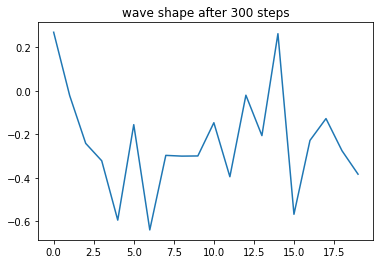

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_300/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_300/model_weights.tf
generator loss:0.37974109097956127
last advantage:[-0.00371875]
last log token-prob:[-0.03676031]
last time gaussian:[0.47801238]
last token entropy:[0.03543353]
last time entropy:[-0.09443185]
critic loss:0.006039594731435264
-----------------------


 19%|█▉        | 301/1562 [27:36<2:05:28,  5.97s/it]

total discriminator loss:0.36351081429149984
average true return:0.49729776692091654
-----------------------
Training Step: 301
generator loss:0.3820800986224429
last advantage:[-0.07630278]
last log token-prob:[-0.03339127]
last time gaussian:[0.27972108]
last token entropy:[0.03229471]
last time entropy:[-0.02981231]
critic loss:0.00643596400772829
-----------------------


 19%|█▉        | 302/1562 [27:39<1:46:23,  5.07s/it]

total discriminator loss:0.3741781402554336
average true return:0.49981610365163964
-----------------------
Training Step: 302
generator loss:0.39226859326266333
last advantage:[-0.07896007]
last log token-prob:[-0.0395223]
last time gaussian:[0.25747906]
last token entropy:[0.03799075]
last time entropy:[-0.05841457]
critic loss:0.006270193909329784
-----------------------


 19%|█▉        | 303/1562 [27:42<1:32:34,  4.41s/it]

total discriminator loss:0.37931578202338123
average true return:0.5023717156124338
-----------------------
Training Step: 303
generator loss:0.38543804916121405
last advantage:[-0.05699497]
last log token-prob:[-0.03542758]
last time gaussian:[0.02457351]
last token entropy:[0.03419444]
last time entropy:[-0.04269574]
critic loss:0.006067832105370171
-----------------------


 19%|█▉        | 304/1562 [27:45<1:23:29,  3.98s/it]

total discriminator loss:0.3545475249949023
average true return:0.49604105724023373
-----------------------
Training Step: 304
generator loss:0.4088366206408356
last advantage:[-0.04356631]
last log token-prob:[-0.02827019]
last time gaussian:[0.19687994]
last token entropy:[0.02748218]
last time entropy:[-0.06606909]
critic loss:0.0069884316658729686
-----------------------


 20%|█▉        | 305/1562 [27:48<1:16:30,  3.65s/it]

total discriminator loss:0.3633159454805014
average true return:0.5024622813122084
-----------------------
Training Step: 305
event_types: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1107625
fid_score: 7511.746816893941
rule_score: 0.31275


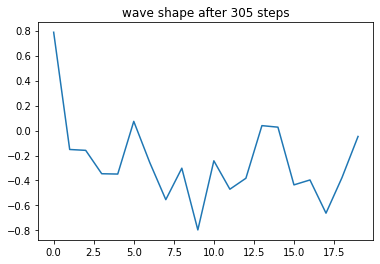

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_305/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_305/model_weights.tf
generator loss:0.41108800460688055
last advantage:[-0.0502442]
last log token-prob:[-0.02664549]
last time gaussian:[-0.37693683]
last token entropy:[0.02594488]
last time entropy:[-0.0086475]
critic loss:0.006206750270358497
-----------------------


 20%|█▉        | 306/1562 [28:00<2:05:51,  6.01s/it]

total discriminator loss:0.34539135208425925
average true return:0.504145766692151
-----------------------
Training Step: 306
generator loss:0.37371831528196153
last advantage:[-0.08961308]
last log token-prob:[-0.0355824]
last time gaussian:[0.13658305]
last token entropy:[0.03433855]
last time entropy:[-0.08087232]
critic loss:0.0067315105525671244
-----------------------


 20%|█▉        | 307/1562 [28:02<1:46:09,  5.08s/it]

total discriminator loss:0.3408894673729435
average true return:0.5026204531133756
-----------------------
Training Step: 307
generator loss:0.3946928176097654
last advantage:[-0.07932318]
last log token-prob:[-0.02953112]
last time gaussian:[-0.10746864]
last token entropy:[0.02867178]
last time entropy:[-0.07290134]
critic loss:0.006684440180120187
-----------------------


 20%|█▉        | 308/1562 [28:05<1:32:33,  4.43s/it]

total discriminator loss:0.354590657885588
average true return:0.4939319073195456
-----------------------
Training Step: 308
generator loss:0.3652737573989137
last advantage:[0.12618802]
last log token-prob:[-0.02604386]
last time gaussian:[0.39399006]
last token entropy:[0.02537434]
last time entropy:[0.00751649]
critic loss:0.006957791493455903
-----------------------


 20%|█▉        | 309/1562 [28:08<1:23:12,  3.98s/it]

total discriminator loss:0.3740521711251995
average true return:0.5019611394167802
-----------------------
Training Step: 309
generator loss:0.40392361957378453
last advantage:[-0.10458281]
last log token-prob:[-0.04550832]
last time gaussian:[0.54609482]
last token entropy:[0.04348373]
last time entropy:[-0.05882933]
critic loss:0.007754921817085379
-----------------------


 20%|█▉        | 310/1562 [28:11<1:16:18,  3.66s/it]

total discriminator loss:0.32704324269860324
average true return:0.49584544462457614
-----------------------
Training Step: 310
event_types: [2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1091125
fid_score: 7603.429864574063
rule_score: 0.298


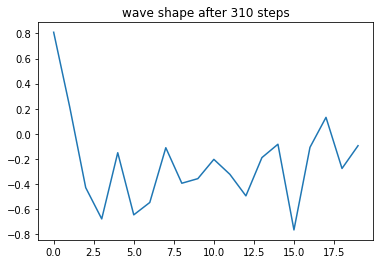

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_310/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_310/model_weights.tf
generator loss:0.36938025784951545
last advantage:[-0.04598395]
last log token-prob:[-0.02329203]
last time gaussian:[-0.42676153]
last token entropy:[0.02275578]
last time entropy:[-0.07731671]
critic loss:0.007360688961053722
-----------------------


 20%|█▉        | 311/1562 [28:23<2:04:35,  5.98s/it]

total discriminator loss:0.37076046216848185
average true return:0.490806786063709
-----------------------
Training Step: 311
generator loss:0.378931676686764
last advantage:[-0.08307348]
last log token-prob:[-0.03183911]
last time gaussian:[0.50855733]
last token entropy:[0.03084135]
last time entropy:[-0.05574831]
critic loss:0.00790916738214477
-----------------------


 20%|█▉        | 312/1562 [28:25<1:45:08,  5.05s/it]

total discriminator loss:0.3478074119522234
average true return:0.4939365996709996
-----------------------
Training Step: 312
generator loss:0.3755033853041124
last advantage:[-0.07453588]
last log token-prob:[-0.02628283]
last time gaussian:[0.35238104]
last token entropy:[0.02560104]
last time entropy:[-0.06708534]
critic loss:0.00816884572571076
-----------------------


 20%|██        | 313/1562 [28:29<1:32:40,  4.45s/it]

total discriminator loss:0.331486482798816
average true return:0.49546395331402776
-----------------------
Training Step: 313
generator loss:0.372373666436688
last advantage:[-0.03377834]
last log token-prob:[-4.77338804]
last time gaussian:[0.49665604]
last token entropy:[0.04034323]
last time entropy:[-0.01180465]
critic loss:0.007935680326277037
-----------------------


 20%|██        | 314/1562 [28:31<1:22:49,  3.98s/it]

total discriminator loss:0.3238648067560245
average true return:0.4894495821477509
-----------------------
Training Step: 314
generator loss:0.38287085542769467
last advantage:[-0.07978914]
last log token-prob:[-0.02729522]
last time gaussian:[-0.34580484]
last token entropy:[0.02656026]
last time entropy:[-0.0307831]
critic loss:0.007948268324502957
-----------------------


 20%|██        | 315/1562 [28:34<1:15:59,  3.66s/it]

total discriminator loss:0.3447438976325762
average true return:0.4877691394185723
-----------------------
Training Step: 315
event_types: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1052125
fid_score: 7560.64739826199
rule_score: 0.289


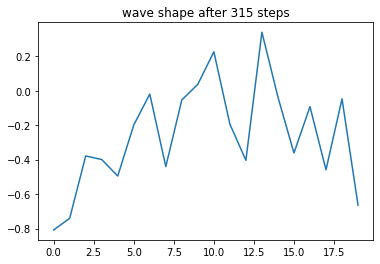

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_315/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_315/model_weights.tf
generator loss:0.3548461565673692
last advantage:[-0.0449362]
last log token-prob:[-0.02610318]
last time gaussian:[0.5114666]
last token entropy:[0.02543062]
last time entropy:[-0.06971033]
critic loss:0.008667172646250321
-----------------------
total discriminator loss:0.3151240671614035
average true return:0.4896651415658259
-----------------------


 20%|██        | 316/1562 [28:47<2:09:53,  6.26s/it]

Training Step: 316
generator loss:0.3376065858844547
last advantage:[-0.0519124]
last log token-prob:[-0.02653868]
last time gaussian:[0.43263146]
last token entropy:[0.02584364]
last time entropy:[-0.05524949]
critic loss:0.008760084136977136
-----------------------
total discriminator loss:0.3342343621279179
average true return:0.4890734870333103
-----------------------


 20%|██        | 317/1562 [28:51<1:57:22,  5.66s/it]

Training Step: 317
generator loss:0.34222409737500564
last advantage:[-0.03900542]
last log token-prob:[-0.02501113]
last time gaussian:[0.28756038]
last token entropy:[0.02439333]
last time entropy:[-0.00500283]
critic loss:0.008759912872327021
-----------------------
total discriminator loss:0.3260742897612503
average true return:0.4935537057230002
-----------------------


 20%|██        | 318/1562 [28:55<1:48:41,  5.24s/it]

Training Step: 318
generator loss:0.3675194647335432
last advantage:[-0.04683042]
last log token-prob:[-0.02923858]
last time gaussian:[-0.42745349]
last token entropy:[0.02839606]
last time entropy:[-0.03881373]
critic loss:0.009464135767552135
-----------------------


 20%|██        | 319/1562 [28:59<1:41:20,  4.89s/it]

total discriminator loss:0.31608506864765656
average true return:0.493035213091463
-----------------------
Training Step: 319
generator loss:0.3509854626892935
last advantage:[-0.04248704]
last log token-prob:[-0.02406241]
last time gaussian:[0.4243677]
last token entropy:[0.02349032]
last time entropy:[-0.03840137]
critic loss:0.00871247087383817
-----------------------


 20%|██        | 320/1562 [29:02<1:29:07,  4.31s/it]

total discriminator loss:0.3239913858402623
average true return:0.4921100269641739
-----------------------
Training Step: 320
event_types: [2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.105
fid_score: 7630.2258227585535
rule_score: 0.27425


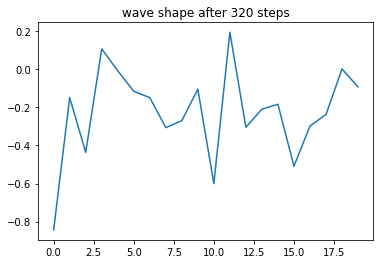

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_320/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_320/model_weights.tf
generator loss:0.34112881125440586
last advantage:[-0.05349153]
last log token-prob:[-0.03282377]
last time gaussian:[0.03094692]
last token entropy:[0.03176386]
last time entropy:[-0.07553908]
critic loss:0.010404076607418775
-----------------------


 21%|██        | 321/1562 [29:14<2:12:50,  6.42s/it]

total discriminator loss:0.3386381096719807
average true return:0.4895925038358432
-----------------------
Training Step: 321
generator loss:0.35937809151271394
last advantage:[-0.05882386]
last log token-prob:[-0.02943488]
last time gaussian:[0.54648132]
last token entropy:[0.02858109]
last time entropy:[-0.08086606]
critic loss:0.008988473736562313
-----------------------


 21%|██        | 322/1562 [29:16<1:50:50,  5.36s/it]

total discriminator loss:0.31670546126777765
average true return:0.48922442829161067
-----------------------
Training Step: 322
generator loss:0.3442648102574714
last advantage:[-0.03794474]
last log token-prob:[-0.02540466]
last time gaussian:[0.46705062]
last token entropy:[0.02476739]
last time entropy:[-0.05889178]
critic loss:0.009244952798800313
-----------------------


 21%|██        | 323/1562 [29:19<1:35:26,  4.62s/it]

total discriminator loss:0.33347215972170674
average true return:0.49055550007326626
-----------------------
Training Step: 323
generator loss:0.3352815144374791
last advantage:[0.00179731]
last log token-prob:[-0.02771767]
last time gaussian:[0.40630937]
last token entropy:[0.02695995]
last time entropy:[-0.04086291]
critic loss:0.009075951452663194
-----------------------


 21%|██        | 324/1562 [29:22<1:24:40,  4.10s/it]

total discriminator loss:0.32949334345109355
average true return:0.49220687684182035
-----------------------
Training Step: 324
generator loss:0.33927191752382246
last advantage:[-0.009838]
last log token-prob:[-0.03241923]
last time gaussian:[0.46397267]
last token entropy:[0.03138508]
last time entropy:[0.00864668]
critic loss:0.009274177704006764
-----------------------


 21%|██        | 325/1562 [29:25<1:17:06,  3.74s/it]

total discriminator loss:0.3426224651007279
average true return:0.4895610443899998
-----------------------
Training Step: 325
event_types: [3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1014375
fid_score: 7730.4854827715335
rule_score: 0.26


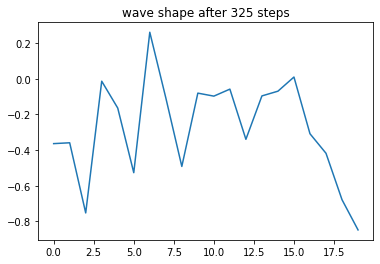

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_325/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_325/model_weights.tf
generator loss:0.3335311085720208
last advantage:[-0.04465166]
last log token-prob:[-0.02615074]
last time gaussian:[0.41434056]
last token entropy:[0.02547574]
last time entropy:[-0.03733263]
critic loss:0.008932896576526145
-----------------------


 21%|██        | 326/1562 [29:36<2:04:00,  6.02s/it]

total discriminator loss:0.3218240671795619
average true return:0.49042135598969866
-----------------------
Training Step: 326
generator loss:0.3434361856757304
last advantage:[-0.03201225]
last log token-prob:[-0.02039613]
last time gaussian:[-1.20536897]
last token entropy:[0.01998434]
last time entropy:[-0.07199011]
critic loss:0.009294828552375182
-----------------------


 21%|██        | 327/1562 [29:39<1:44:33,  5.08s/it]

total discriminator loss:0.3236508960376483
average true return:0.4890129993459884
-----------------------
Training Step: 327
generator loss:0.3407937063061061
last advantage:[-0.04659588]
last log token-prob:[-0.02645932]
last time gaussian:[-0.1089791]
last token entropy:[0.0257684]
last time entropy:[-0.06799458]
critic loss:0.0101249377123995
-----------------------


 21%|██        | 328/1562 [29:42<1:30:57,  4.42s/it]

total discriminator loss:0.3268917419419015
average true return:0.49275777567602924
-----------------------
Training Step: 328
generator loss:0.345110289151894
last advantage:[-0.01212478]
last log token-prob:[-0.02422323]
last time gaussian:[0.38293982]
last token entropy:[0.02364352]
last time entropy:[-0.04649052]
critic loss:0.008160496894565009
-----------------------


 21%|██        | 329/1562 [29:45<1:21:27,  3.96s/it]

total discriminator loss:0.33108961040382234
average true return:0.4958989280199
-----------------------
Training Step: 329
generator loss:0.380480212324472
last advantage:[0.01146343]
last log token-prob:[-0.02373747]
last time gaussian:[0.45008975]
last token entropy:[0.02318063]
last time entropy:[-0.073014]
critic loss:0.009235200438630884
-----------------------


 21%|██        | 330/1562 [29:48<1:14:44,  3.64s/it]

total discriminator loss:0.30641736707175365
average true return:0.49185519057375654
-----------------------
Training Step: 330
event_types: [0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.101525
fid_score: 7733.509629003789
rule_score: 0.25575


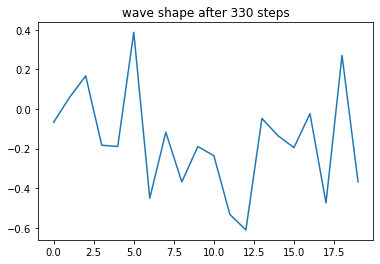

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_330/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_330/model_weights.tf
generator loss:0.32510942978579827
last advantage:[0.08657019]
last log token-prob:[-0.03018354]
last time gaussian:[0.34060966]
last token entropy:[0.0292861]
last time entropy:[0.02350259]
critic loss:0.008598245336121834
-----------------------


 21%|██        | 331/1562 [29:59<2:02:13,  5.96s/it]

total discriminator loss:1.9996529110407355
average true return:0.4915206583820724
-----------------------
Training Step: 331
generator loss:0.33847377232938575
last advantage:[-0.02574567]
last log token-prob:[-0.02632692]
last time gaussian:[0.10722731]
last token entropy:[0.02564286]
last time entropy:[-0.02264081]
critic loss:0.008367164546545281
-----------------------


 21%|██▏       | 332/1562 [30:02<1:43:15,  5.04s/it]

total discriminator loss:0.31647201375114503
average true return:0.4987265676807834
-----------------------
Training Step: 332
generator loss:0.33578559151077425
last advantage:[-0.01644762]
last log token-prob:[-0.0252553]
last time gaussian:[-0.55214604]
last token entropy:[0.02462546]
last time entropy:[-0.03125375]
critic loss:0.00884875708903093
-----------------------


 21%|██▏       | 333/1562 [30:05<1:29:59,  4.39s/it]

total discriminator loss:0.32136526866206905
average true return:0.5046943668192967
-----------------------
Training Step: 333
generator loss:0.3179044974858415
last advantage:[0.00053388]
last log token-prob:[-0.02860155]
last time gaussian:[-0.37482834]
last token entropy:[0.02779509]
last time entropy:[-0.00488174]
critic loss:0.008309094388485793
-----------------------


 21%|██▏       | 334/1562 [30:08<1:20:35,  3.94s/it]

total discriminator loss:0.33389825192270617
average true return:0.5090562954784649
-----------------------
Training Step: 334
generator loss:0.3403374735771675
last advantage:[0.04085355]
last log token-prob:[-0.02653428]
last time gaussian:[-0.74556296]
last token entropy:[0.02583947]
last time entropy:[-0.02037052]
critic loss:0.007670740883771565
-----------------------


 21%|██▏       | 335/1562 [30:11<1:14:09,  3.63s/it]

total discriminator loss:0.3161939793494324
average true return:0.5084150212571921
-----------------------
Training Step: 335
event_types: [1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0990125
fid_score: 7774.517918454472
rule_score: 0.23125


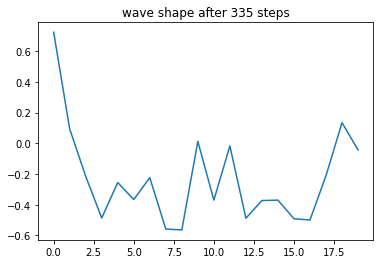

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_335/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_335/model_weights.tf
generator loss:0.3210304773402997
last advantage:[-0.007116]
last log token-prob:[-0.02422431]
last time gaussian:[0.42238912]
last token entropy:[0.02364455]
last time entropy:[-0.01269468]
critic loss:0.008603788049319109
-----------------------


 22%|██▏       | 336/1562 [30:23<2:03:27,  6.04s/it]

total discriminator loss:0.3186917110747468
average true return:0.5061617479429665
-----------------------
Training Step: 336
generator loss:0.3248186934660434
last advantage:[0.03223232]
last log token-prob:[-0.02601502]
last time gaussian:[-0.84767098]
last token entropy:[0.02534697]
last time entropy:[-0.03800755]
critic loss:0.008262037743341371
-----------------------


 22%|██▏       | 337/1562 [30:26<1:44:24,  5.11s/it]

total discriminator loss:0.3382514560898735
average true return:0.519088871986898
-----------------------
Training Step: 337
generator loss:0.3090660179204886
last advantage:[0.01337729]
last log token-prob:[-0.02004993]
last time gaussian:[-0.25942794]
last token entropy:[0.01965194]
last time entropy:[-0.01582057]
critic loss:0.007961615483524292
-----------------------


 22%|██▏       | 338/1562 [30:28<1:30:37,  4.44s/it]

total discriminator loss:0.3148952798533974
average true return:0.5080159152176245
-----------------------
Training Step: 338
generator loss:0.2881457717280919
last advantage:[0.03309486]
last log token-prob:[-0.02634346]
last time gaussian:[-2.54729088]
last token entropy:[0.02565855]
last time entropy:[-0.02705521]
critic loss:0.00791020111213583
-----------------------


 22%|██▏       | 339/1562 [30:31<1:21:00,  3.97s/it]

total discriminator loss:0.3520502999410249
average true return:0.5102075099857769
-----------------------
Training Step: 339
generator loss:0.33507963772653837
last advantage:[0.094715]
last log token-prob:[-0.02102736]
last time gaussian:[0.25368917]
last token entropy:[0.02058982]
last time entropy:[0.00979726]
critic loss:0.009077922238702418
-----------------------


 22%|██▏       | 340/1562 [30:34<1:14:20,  3.65s/it]

total discriminator loss:0.31388824166731827
average true return:0.508158688754734
-----------------------
Training Step: 340
event_types: [0, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0983375
fid_score: 7854.051536436587
rule_score: 0.20725


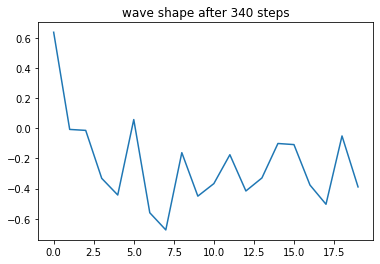

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_340/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_340/model_weights.tf
generator loss:0.3155498225562532
last advantage:[0.121476]
last log token-prob:[-0.02019542]
last time gaussian:[-0.13954367]
last token entropy:[0.01979166]
last time entropy:[-0.04199678]
critic loss:0.009813196999088888
-----------------------


 22%|██▏       | 341/1562 [30:46<2:01:11,  5.96s/it]

total discriminator loss:0.31540288342413914
average true return:0.5146848743321102
-----------------------
Training Step: 341
generator loss:0.3381244065218302
last advantage:[0.08479528]
last log token-prob:[-0.02208084]
last time gaussian:[0.54227668]
last token entropy:[0.02159862]
last time entropy:[-0.04297503]
critic loss:0.007736910887197146
-----------------------


 22%|██▏       | 342/1562 [30:48<1:42:21,  5.03s/it]

total discriminator loss:0.31821040280549356
average true return:0.505255605356969
-----------------------
Training Step: 342
generator loss:0.3261912778603966
last advantage:[0.04899298]
last log token-prob:[-0.02091399]
last time gaussian:[0.29217233]
last token entropy:[0.02048113]
last time entropy:[-0.05507485]
critic loss:0.007552666378028575
-----------------------


 22%|██▏       | 343/1562 [30:51<1:29:12,  4.39s/it]

total discriminator loss:0.3219918785535585
average true return:0.5066160741820134
-----------------------
Training Step: 343
generator loss:0.26752254820131294
last advantage:[0.02592106]
last log token-prob:[-0.02739502]
last time gaussian:[0.02160587]
last token entropy:[0.02665472]
last time entropy:[-0.0345861]
critic loss:0.0071156664722048565
-----------------------


 22%|██▏       | 344/1562 [30:54<1:20:02,  3.94s/it]

total discriminator loss:0.31847732342513324
average true return:0.5091014555983094
-----------------------
Training Step: 344
generator loss:0.2881662721459871
last advantage:[-0.00717503]
last log token-prob:[-0.03271035]
last time gaussian:[0.49861146]
last token entropy:[0.0316577]
last time entropy:[-0.03739123]
critic loss:0.007166512859495022
-----------------------


 22%|██▏       | 345/1562 [30:57<1:13:32,  3.63s/it]

total discriminator loss:0.3000721420973907
average true return:0.5053487286891866
-----------------------
Training Step: 345
event_types: [2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.096925
fid_score: 7931.358599850069
rule_score: 0.2055


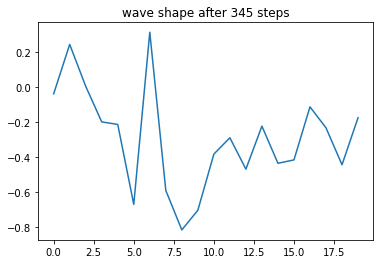

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_345/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_345/model_weights.tf
generator loss:0.3047505860511777
last advantage:[0.01731646]
last log token-prob:[-0.0208377]
last time gaussian:[0.48095526]
last token entropy:[0.02040798]
last time entropy:[-0.02639009]
critic loss:0.00669762290427626
-----------------------


 22%|██▏       | 346/1562 [31:08<2:00:28,  5.94s/it]

total discriminator loss:0.3388950733447454
average true return:0.5059073140283857
-----------------------
Training Step: 346
generator loss:0.2932369097001225
last advantage:[0.08497405]
last log token-prob:[-0.02125296]
last time gaussian:[0.45869297]
last token entropy:[0.02080604]
last time entropy:[-0.02386752]
critic loss:0.007211074255682165
-----------------------


 22%|██▏       | 347/1562 [31:11<1:41:47,  5.03s/it]

total discriminator loss:0.3249144757632065
average true return:0.5057709334949948
-----------------------
Training Step: 347
generator loss:0.2957870892786076
last advantage:[0.01230657]
last log token-prob:[-0.0228326]
last time gaussian:[0.48154939]
last token entropy:[0.02231718]
last time entropy:[-0.05494863]
critic loss:0.007228600111766588
-----------------------


 22%|██▏       | 348/1562 [31:14<1:28:39,  4.38s/it]

total discriminator loss:0.3092167825775415
average true return:0.5050295929680095
-----------------------
Training Step: 348
generator loss:0.26784457308276133
last advantage:[0.01191726]
last log token-prob:[-0.02484535]
last time gaussian:[0.26479851]
last token entropy:[0.02423567]
last time entropy:[-0.02517349]
critic loss:0.006988701745566042
-----------------------


 22%|██▏       | 349/1562 [31:17<1:19:34,  3.94s/it]

total discriminator loss:0.310968128159819
average true return:0.4985780900162122
-----------------------
Training Step: 349
generator loss:0.32532841346377056
last advantage:[-0.01628892]
last log token-prob:[-0.01856609]
last time gaussian:[0.43761986]
last token entropy:[0.01822457]
last time entropy:[-0.04005178]
critic loss:0.006925694401511734
-----------------------


 22%|██▏       | 350/1562 [31:20<1:13:11,  3.62s/it]

total discriminator loss:0.3179726470557308
average true return:0.5025277324823972
-----------------------
Training Step: 350
event_types: [2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0944875
fid_score: 7974.401858203364
rule_score: 0.1995


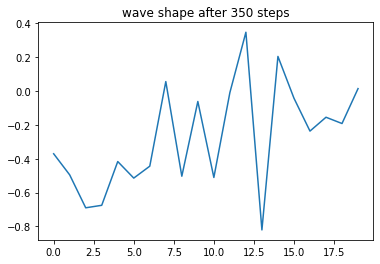

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_350/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_350/model_weights.tf
generator loss:0.31791249960914003
last advantage:[0.01055879]
last log token-prob:[-0.02312968]
last time gaussian:[0.16569708]
last token entropy:[0.02260083]
last time entropy:[-0.03464574]
critic loss:0.00721678243075991
-----------------------


 22%|██▏       | 351/1562 [31:31<2:00:21,  5.96s/it]

total discriminator loss:0.34146507787188174
average true return:0.4905108572698541
-----------------------
Training Step: 351
generator loss:0.3139412261232919
last advantage:[-0.01238663]
last log token-prob:[-0.02199923]
last time gaussian:[0.07944222]
last token entropy:[0.02152055]
last time entropy:[-0.0391281]
critic loss:0.007275452947692855
-----------------------


 23%|██▎       | 352/1562 [31:34<1:41:36,  5.04s/it]

total discriminator loss:0.3176887182029035
average true return:0.4979759249235033
-----------------------
Training Step: 352
generator loss:0.3041346290403017
last advantage:[-0.01833355]
last log token-prob:[-0.01977534]
last time gaussian:[0.35808334]
last token entropy:[0.01938812]
last time entropy:[-0.02078297]
critic loss:0.008680341527615033
-----------------------


 23%|██▎       | 353/1562 [31:37<1:28:28,  4.39s/it]

total discriminator loss:0.30130553979141794
average true return:0.49694541799693304
-----------------------
Training Step: 353
generator loss:0.33018680427502434
last advantage:[-0.01729585]
last log token-prob:[-0.02599618]
last time gaussian:[-0.81968708]
last token entropy:[0.02532909]
last time entropy:[-0.02266649]
critic loss:0.006815732539684004
-----------------------


 23%|██▎       | 354/1562 [31:40<1:19:22,  3.94s/it]

total discriminator loss:0.32322045088556695
average true return:0.4971494876355361
-----------------------
Training Step: 354
generator loss:0.29345254601966764
last advantage:[-0.02594845]
last log token-prob:[-0.02318081]
last time gaussian:[-0.93497428]
last token entropy:[0.02264964]
last time entropy:[-0.02351495]
critic loss:0.007848804334195814
-----------------------


 23%|██▎       | 355/1562 [31:43<1:12:55,  3.63s/it]

total discriminator loss:0.3216271057578796
average true return:0.4958539610076672
-----------------------
Training Step: 355
event_types: [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0926
fid_score: 8010.2518731834225
rule_score: 0.17725


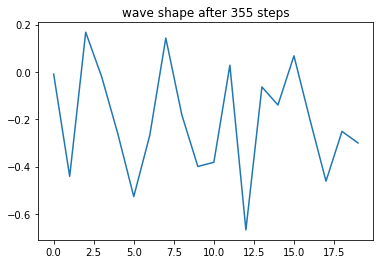

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_355/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_355/model_weights.tf
generator loss:0.2998276125464344
last advantage:[-0.00106047]
last log token-prob:[-0.01564309]
last time gaussian:[0.07044124]
last token entropy:[0.01540029]
last time entropy:[-0.03363425]
critic loss:0.007074468021413158
-----------------------


 23%|██▎       | 356/1562 [31:54<1:59:19,  5.94s/it]

total discriminator loss:0.31965615711085427
average true return:0.48965519577830796
-----------------------
Training Step: 356
generator loss:0.27725713824306336
last advantage:[-0.03510259]
last log token-prob:[-0.02097587]
last time gaussian:[-0.12661255]
last token entropy:[0.02054046]
last time entropy:[-0.02811342]
critic loss:0.006959531835492178
-----------------------


 23%|██▎       | 357/1562 [31:57<1:41:02,  5.03s/it]

total discriminator loss:0.29919424826621566
average true return:0.4940579634453378
-----------------------
Training Step: 357
generator loss:0.2557099453267061
last advantage:[-0.03156514]
last log token-prob:[-0.01597159]
last time gaussian:[0.49596758]
last token entropy:[0.01571852]
last time entropy:[-0.04052841]
critic loss:0.0076475331573542995
-----------------------


 23%|██▎       | 358/1562 [32:00<1:28:03,  4.39s/it]

total discriminator loss:0.3064700272942631
average true return:0.4935894169209943
-----------------------
Training Step: 358
generator loss:0.29715124425264466
last advantage:[-0.0341086]
last log token-prob:[-0.01820378]
last time gaussian:[0.06269058]
last token entropy:[0.0178754]
last time entropy:[-0.00179309]
critic loss:0.007748488357907592
-----------------------


 23%|██▎       | 359/1562 [32:03<1:19:00,  3.94s/it]

total discriminator loss:0.3494895764503998
average true return:0.4925608288480118
-----------------------
Training Step: 359
generator loss:0.2822673976693079
last advantage:[0.00597309]
last log token-prob:[-0.0162032]
last time gaussian:[0.41008873]
last token entropy:[0.01594277]
last time entropy:[-0.04148413]
critic loss:0.0072256008845177615
-----------------------


 23%|██▎       | 360/1562 [32:06<1:12:37,  3.63s/it]

total discriminator loss:0.29351896348737055
average true return:0.49231366996018333
-----------------------
Training Step: 360
event_types: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0914375
fid_score: 8033.399884238595
rule_score: 0.16425


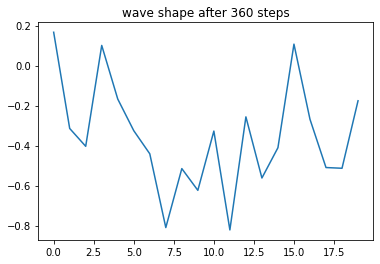

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_360/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_360/model_weights.tf
generator loss:0.2714324142080555
last advantage:[-0.00604925]
last log token-prob:[-0.02107559]
last time gaussian:[0.5130107]
last token entropy:[0.02063605]
last time entropy:[-0.03177245]
critic loss:0.0072531435964899
-----------------------


 23%|██▎       | 361/1562 [32:17<1:58:35,  5.92s/it]

total discriminator loss:0.32306434120749233
average true return:0.4925306165532852
-----------------------
Training Step: 361
generator loss:0.27856910300511145
last advantage:[0.00976603]
last log token-prob:[-0.02648945]
last time gaussian:[-0.61028288]
last token entropy:[0.02579697]
last time entropy:[-0.01927605]
critic loss:0.007196619909510588
-----------------------


 23%|██▎       | 362/1562 [32:20<1:40:17,  5.01s/it]

total discriminator loss:0.3084533670638858
average true return:0.49165083318588204
-----------------------
Training Step: 362
generator loss:0.28208288337695764
last advantage:[-0.01598752]
last log token-prob:[-0.02096266]
last time gaussian:[0.53306263]
last token entropy:[0.0205278]
last time entropy:[-0.03435832]
critic loss:0.007124979691052423
-----------------------


 23%|██▎       | 363/1562 [32:23<1:27:30,  4.38s/it]

total discriminator loss:0.32272101468386793
average true return:0.49360135005372135
-----------------------
Training Step: 363
generator loss:0.2764100075008057
last advantage:[-0.0025119]
last log token-prob:[-0.02973241]
last time gaussian:[-0.122609]
last token entropy:[0.0288614]
last time entropy:[-0.03483805]
critic loss:0.00720088643945282
-----------------------


 23%|██▎       | 364/1562 [32:26<1:18:30,  3.93s/it]

total discriminator loss:0.3010124960837983
average true return:0.49525348205834696
-----------------------
Training Step: 364
generator loss:0.29892725012022364
last advantage:[-0.02693036]
last log token-prob:[-0.01781209]
last time gaussian:[0.4609803]
last token entropy:[0.01749763]
last time entropy:[0.00531918]
critic loss:0.007175264951559289
-----------------------


 23%|██▎       | 365/1562 [32:29<1:12:11,  3.62s/it]

total discriminator loss:0.31267424077721795
average true return:0.4950547528917833
-----------------------
Training Step: 365
event_types: [2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0915375
fid_score: 8125.691452947269
rule_score: 0.1705


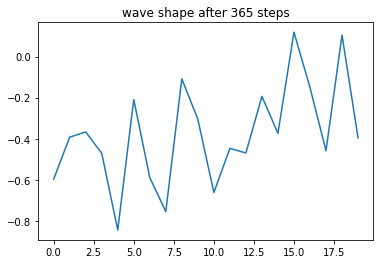

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_365/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_365/model_weights.tf
generator loss:0.27901651159755575
last advantage:[-0.00500846]
last log token-prob:[-0.01800032]
last time gaussian:[0.11768283]
last token entropy:[0.0176792]
last time entropy:[0.00173456]
critic loss:0.007090957989776154
-----------------------


 23%|██▎       | 366/1562 [32:40<1:58:08,  5.93s/it]

total discriminator loss:0.3189802134716625
average true return:0.49097590239147515
-----------------------
Training Step: 366
generator loss:0.320163713363003
last advantage:[-0.0461571]
last log token-prob:[-0.01919931]
last time gaussian:[-0.30421772]
last token entropy:[0.01883421]
last time entropy:[-0.04309198]
critic loss:0.007486685867660261
-----------------------


 23%|██▎       | 367/1562 [32:43<1:39:53,  5.02s/it]

total discriminator loss:0.3176805294577051
average true return:0.49327155104588505
-----------------------
Training Step: 367
generator loss:0.2828320100485544
last advantage:[-2.27927129e-05]
last log token-prob:[-0.01697013]
last time gaussian:[0.14657911]
last token entropy:[0.01668457]
last time entropy:[-0.04134428]
critic loss:0.007111620132602832
-----------------------


 24%|██▎       | 368/1562 [32:46<1:27:10,  4.38s/it]

total discriminator loss:0.3219351231455453
average true return:0.4927310799432744
-----------------------
Training Step: 368
generator loss:0.2745276423829385
last advantage:[-0.00268946]
last log token-prob:[-0.01846177]
last time gaussian:[0.49073288]
last token entropy:[0.01812406]
last time entropy:[-0.02402003]
critic loss:0.007048117479477681
-----------------------


 24%|██▎       | 369/1562 [32:49<1:18:09,  3.93s/it]

total discriminator loss:0.3477912543968362
average true return:0.4928706243424634
-----------------------
Training Step: 369
generator loss:0.28114682210604436
last advantage:[-0.03842352]
last log token-prob:[-0.01870815]
last time gaussian:[0.15287402]
last token entropy:[0.01836141]
last time entropy:[-0.020896]
critic loss:0.007107490405616379
-----------------------


 24%|██▎       | 370/1562 [32:52<1:11:55,  3.62s/it]

total discriminator loss:0.33732521448131436
average true return:0.4915533455392861
-----------------------
Training Step: 370
event_types: [3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0884
fid_score: 8247.965841497029
rule_score: 0.1545


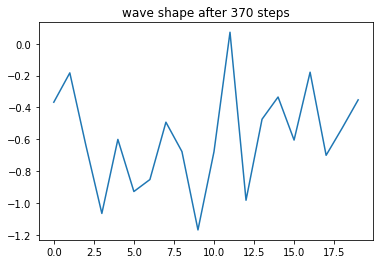

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_370/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_370/model_weights.tf
generator loss:0.2905962224301373
last advantage:[-0.00294383]
last log token-prob:[-0.02033557]
last time gaussian:[0.55292346]
last token entropy:[0.01992621]
last time entropy:[-0.05312047]
critic loss:0.007011600996566772
-----------------------


 24%|██▍       | 371/1562 [33:03<1:57:33,  5.92s/it]

total discriminator loss:0.30172023330026776
average true return:0.49581844421086185
-----------------------
Training Step: 371
generator loss:0.2661357422016209
last advantage:[0.01605644]
last log token-prob:[-0.01528106]
last time gaussian:[0.31603816]
last token entropy:[0.01504933]
last time entropy:[-0.04192007]
critic loss:0.006955195709190097
-----------------------


 24%|██▍       | 372/1562 [33:06<1:39:24,  5.01s/it]

total discriminator loss:0.3017360709086774
average true return:0.49106395260135716
-----------------------
Training Step: 372
generator loss:0.3095206738370539
last advantage:[-0.0313464]
last log token-prob:[-0.01929802]
last time gaussian:[-0.21027308]
last token entropy:[0.01892917]
last time entropy:[-0.0249922]
critic loss:0.007114142878222732
-----------------------


 24%|██▍       | 373/1562 [33:09<1:26:43,  4.38s/it]

total discriminator loss:0.3215863129879919
average true return:0.49214028905159346
-----------------------
Training Step: 373
generator loss:0.25658628421141055
last advantage:[-0.0206279]
last log token-prob:[-0.01763664]
last time gaussian:[0.5071592]
last token entropy:[0.01732831]
last time entropy:[-0.00780768]
critic loss:0.007140116873309278
-----------------------


 24%|██▍       | 374/1562 [33:12<1:17:49,  3.93s/it]

total discriminator loss:0.3258478848825065
average true return:0.4987578670126219
-----------------------
Training Step: 374
generator loss:0.2722077032911379
last advantage:[-0.02601522]
last log token-prob:[-0.01762931]
last time gaussian:[0.27051176]
last token entropy:[0.01732124]
last time entropy:[-0.03221575]
critic loss:0.0070177571844262186
-----------------------


 24%|██▍       | 375/1562 [33:14<1:11:33,  3.62s/it]

total discriminator loss:0.3365732397263833
average true return:0.4969833103588279
-----------------------
Training Step: 375
event_types: [0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.08645
fid_score: 8229.990029837654
rule_score: 0.14675


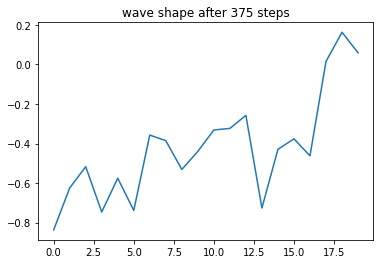

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_375/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_375/model_weights.tf
generator loss:0.2809388023067174
last advantage:[-0.02603705]
last log token-prob:[-0.01906683]
last time gaussian:[0.24972814]
last token entropy:[0.01870673]
last time entropy:[-0.01668997]
critic loss:0.00742464427135799
-----------------------


 24%|██▍       | 376/1562 [33:26<1:57:21,  5.94s/it]

total discriminator loss:0.2914631901268964
average true return:0.5017170362638005
-----------------------
Training Step: 376
generator loss:0.2912083864769032
last advantage:[-0.03556501]
last log token-prob:[-0.02128571]
last time gaussian:[0.44349315]
last token entropy:[0.02083741]
last time entropy:[-0.02422637]
critic loss:0.006730887519058486
-----------------------


 24%|██▍       | 377/1562 [33:29<1:39:27,  5.04s/it]

total discriminator loss:0.3393950287305424
average true return:0.49655888858246083
-----------------------
Training Step: 377
generator loss:0.24321652667938407
last advantage:[-0.02518577]
last log token-prob:[-0.01502737]
last time gaussian:[0.09743598]
last token entropy:[0.01480323]
last time entropy:[-0.00677172]
critic loss:0.007325511939224963
-----------------------


 24%|██▍       | 378/1562 [33:32<1:26:50,  4.40s/it]

total discriminator loss:0.34694897799258395
average true return:0.500770541998003
-----------------------
Training Step: 378
generator loss:0.26517264858542094
last advantage:[-0.03599621]
last log token-prob:[-0.01702625]
last time gaussian:[0.31729825]
last token entropy:[0.01673881]
last time entropy:[0.00066403]
critic loss:0.006756967928187989
-----------------------


 24%|██▍       | 379/1562 [33:35<1:17:48,  3.95s/it]

total discriminator loss:0.3498161681830305
average true return:0.4986723902943946
-----------------------
Training Step: 379
generator loss:0.28625362605912613
last advantage:[0.00101409]
last log token-prob:[-0.02362145]
last time gaussian:[0.31968773]
last token entropy:[0.02307001]
last time entropy:[-0.00275436]
critic loss:0.007205325823936538
-----------------------


 24%|██▍       | 380/1562 [33:37<1:11:28,  3.63s/it]

total discriminator loss:0.2894614167409583
average true return:0.49572585065246755
-----------------------
Training Step: 380
event_types: [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0840125
fid_score: 8270.839857589172
rule_score: 0.1315


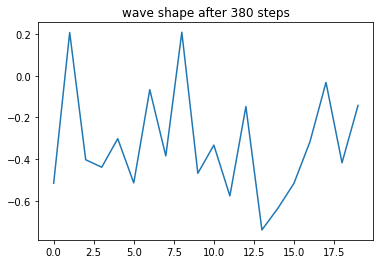

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_380/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_380/model_weights.tf
generator loss:0.27711632664798264
last advantage:[0.00679382]
last log token-prob:[-0.02224624]
last time gaussian:[-0.0840015]
last token entropy:[0.02175681]
last time entropy:[-0.10425809]
critic loss:0.006573643964007276
-----------------------
total discriminator loss:0.3338853497815132
average true return:0.499351694785621
-----------------------


 24%|██▍       | 381/1562 [33:53<2:19:11,  7.07s/it]

Training Step: 381
generator loss:0.2588196250655323
last advantage:[0.00848535]
last log token-prob:[-0.01720487]
last time gaussian:[0.48948304]
last token entropy:[0.0169114]
last time entropy:[0.00935692]
critic loss:0.006575927280734281
-----------------------
total discriminator loss:0.32994180038684084
average true return:0.5053433365203915
-----------------------


 24%|██▍       | 382/1562 [33:57<2:02:33,  6.23s/it]

Training Step: 382
generator loss:0.27419676390055425
last advantage:[-0.01700334]
last log token-prob:[-0.01598962]
last time gaussian:[0.4187928]
last token entropy:[0.01573598]
last time entropy:[-0.01616533]
critic loss:0.006604914584554628
-----------------------
total discriminator loss:0.31372789490826536
average true return:0.4999951785515682
-----------------------


 25%|██▍       | 383/1562 [34:01<1:50:14,  5.61s/it]

Training Step: 383
generator loss:0.28605653597333847
last advantage:[0.02362886]
last log token-prob:[-0.02072419]
last time gaussian:[0.42835336]
last token entropy:[0.02029912]
last time entropy:[0.03799375]
critic loss:0.00658622465121438
-----------------------
total discriminator loss:0.30100061521902255
average true return:0.5039030027044056
-----------------------


 25%|██▍       | 384/1562 [34:05<1:41:42,  5.18s/it]

Training Step: 384
generator loss:0.2735131113700245
last advantage:[0.08491592]
last log token-prob:[-0.01780064]
last time gaussian:[0.47283653]
last token entropy:[0.01748658]
last time entropy:[-0.01252901]
critic loss:0.006748950883195534
-----------------------
total discriminator loss:2.101210765258678
average true return:0.500263738138492
-----------------------


 25%|██▍       | 385/1562 [34:09<1:35:21,  4.86s/it]

Training Step: 385
event_types: [2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0837
fid_score: 8400.359395518999
rule_score: 0.109


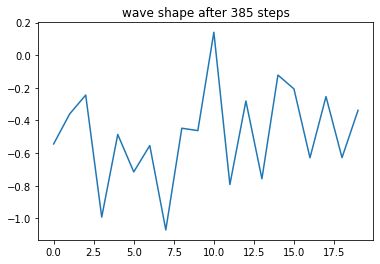

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_385/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_385/model_weights.tf
generator loss:0.29378869808741404
last advantage:[0.04299145]
last log token-prob:[-0.01847159]
last time gaussian:[0.26069876]
last token entropy:[0.01813353]
last time entropy:[-0.00912113]
critic loss:0.006851456009937135
-----------------------
total discriminator loss:0.3314049168530652
average true return:0.5070151657185223
-----------------------


 25%|██▍       | 386/1562 [34:25<2:40:33,  8.19s/it]

Training Step: 386
generator loss:0.26838796125543607
last advantage:[-0.02005463]
last log token-prob:[-0.01704961]
last time gaussian:[0.46610932]
last token entropy:[0.01676138]
last time entropy:[-0.00686595]
critic loss:0.007971459581412182
-----------------------
total discriminator loss:0.34911771457055873
average true return:0.5053994560101912
-----------------------


 25%|██▍       | 387/1562 [34:29<2:16:46,  6.98s/it]

Training Step: 387
generator loss:0.2590283494502089
last advantage:[0.01402663]
last log token-prob:[-0.01879296]
last time gaussian:[-0.5207926]
last token entropy:[0.01844309]
last time entropy:[-0.01559483]
critic loss:0.006470485476738319
-----------------------
total discriminator loss:0.2990658998168507
average true return:0.509289783363545
-----------------------


 25%|██▍       | 388/1562 [34:34<1:59:47,  6.12s/it]

Training Step: 388
generator loss:0.2600079299488697
last advantage:[0.13956442]
last log token-prob:[-0.0167797]
last time gaussian:[0.2233078]
last token entropy:[0.01650049]
last time entropy:[0.00405858]
critic loss:0.006973152673672193
-----------------------


 25%|██▍       | 389/1562 [34:37<1:46:29,  5.45s/it]

total discriminator loss:0.3343612622310581
average true return:0.5085959384186622
-----------------------
Training Step: 389
generator loss:0.2620680880346867
last advantage:[0.02818874]
last log token-prob:[-0.0188973]
last time gaussian:[-0.02726811]
last token entropy:[0.01854355]
last time entropy:[-0.00975667]
critic loss:0.006915465231771155
-----------------------
total discriminator loss:0.31659570395746933
average true return:0.5132524047549912
-----------------------


 25%|██▍       | 390/1562 [34:41<1:36:45,  4.95s/it]

Training Step: 390
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0833125
fid_score: 8469.012864388356
rule_score: 0.09725


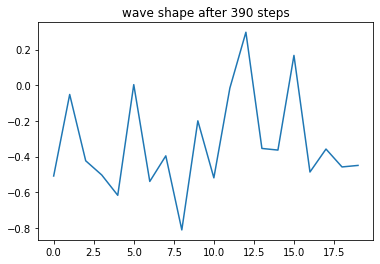

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_390/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_390/model_weights.tf
generator loss:0.24150691231854707
last advantage:[0.04149398]
last log token-prob:[-0.01673982]
last time gaussian:[-0.24713891]
last token entropy:[0.01646193]
last time entropy:[-0.0109107]
critic loss:0.007011192770084214
-----------------------
total discriminator loss:0.3243303635549677
average true return:0.5141878097910471
-----------------------


 25%|██▌       | 391/1562 [34:58<2:44:18,  8.42s/it]

Training Step: 391
generator loss:0.25489800421753234
last advantage:[0.0205838]
last log token-prob:[-0.01524929]
last time gaussian:[-0.77255992]
last token entropy:[0.01501851]
last time entropy:[-0.01220262]
critic loss:0.007208799234119925
-----------------------


 25%|██▌       | 392/1562 [35:02<2:17:39,  7.06s/it]

total discriminator loss:0.3270366093454246
average true return:0.5130443811289763
-----------------------
Training Step: 392
generator loss:0.2771062939763319
last advantage:[0.01556344]
last log token-prob:[-0.0185855]
last time gaussian:[0.14704813]
last token entropy:[0.01824327]
last time entropy:[-0.03505673]
critic loss:0.007294112028785676
-----------------------
total discriminator loss:0.30249285973785317
average true return:0.5103939576350962
-----------------------


 25%|██▌       | 393/1562 [35:05<1:58:39,  6.09s/it]

Training Step: 393
generator loss:0.2562045847693335
last advantage:[0.03352223]
last log token-prob:[-0.02137147]
last time gaussian:[0.49028791]
last token entropy:[0.02091958]
last time entropy:[-0.05189568]
critic loss:0.0067048629768665605
-----------------------
total discriminator loss:0.3017544384350166
average true return:0.5147909529778185
-----------------------


 25%|██▌       | 394/1562 [35:10<1:47:20,  5.51s/it]

Training Step: 394
generator loss:0.2406925786895166
last advantage:[0.03715292]
last log token-prob:[-5.21450545]
last time gaussian:[0.53789084]
last token entropy:[0.0283519]
last time entropy:[-0.05049543]
critic loss:0.006839430354633634
-----------------------
total discriminator loss:0.34379814265717856
average true return:0.5142168892678227
-----------------------


 25%|██▌       | 395/1562 [35:14<1:39:21,  5.11s/it]

Training Step: 395
event_types: [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0835875
fid_score: 8485.736852160779
rule_score: 0.09075


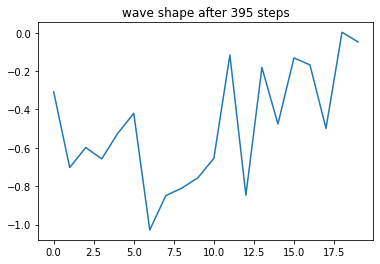

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_395/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_395/model_weights.tf
generator loss:0.272037771031401
last advantage:[0.04448831]
last log token-prob:[-4.9837285]
last time gaussian:[0.48328631]
last token entropy:[0.03413097]
last time entropy:[-0.01457143]
critic loss:0.007020980117359417
-----------------------
total discriminator loss:0.320937789695812
average true return:0.514865898979999
-----------------------


 25%|██▌       | 396/1562 [35:30<2:41:27,  8.31s/it]

Training Step: 396
generator loss:0.24278694498355477
last advantage:[0.01820973]
last log token-prob:[-0.01590204]
last time gaussian:[-0.27032595]
last token entropy:[0.01565116]
last time entropy:[-0.01994639]
critic loss:0.006498392225576752
-----------------------
total discriminator loss:0.32752990681253386
average true return:0.5140649933125376
-----------------------


 25%|██▌       | 397/1562 [35:34<2:17:24,  7.08s/it]

Training Step: 397
generator loss:0.2488411689352846
last advantage:[0.00308866]
last log token-prob:[-0.0147838]
last time gaussian:[0.51746755]
last token entropy:[0.01456685]
last time entropy:[-0.01786893]
critic loss:0.006164561986328238
-----------------------
total discriminator loss:0.32176670055132395
average true return:0.5098588570405529
-----------------------


 25%|██▌       | 398/1562 [35:38<2:00:31,  6.21s/it]

Training Step: 398
generator loss:0.2562323666505349
last advantage:[0.01207025]
last log token-prob:[-0.01279562]
last time gaussian:[-0.53399595]
last token entropy:[0.01263294]
last time entropy:[-0.02094674]
critic loss:0.00705656762227363
-----------------------
total discriminator loss:1.9403843299838748
average true return:0.5107937221459437
-----------------------


 26%|██▌       | 399/1562 [35:42<1:49:07,  5.63s/it]

Training Step: 399
generator loss:0.2372405862612033
last advantage:[0.01400148]
last log token-prob:[-0.01638751]
last time gaussian:[0.37395454]
last token entropy:[0.01612114]
last time entropy:[-0.02379638]
critic loss:0.005724178307108361
-----------------------
total discriminator loss:1.8711049950206995
average true return:0.5148448762154354
-----------------------


 26%|██▌       | 400/1562 [35:46<1:40:29,  5.19s/it]

Training Step: 400
event_types: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0814
fid_score: 8543.331778372303
rule_score: 0.07725


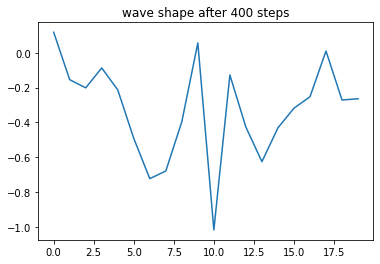

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_400/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_400/model_weights.tf
generator loss:0.23922857386174648
last advantage:[0.06384239]
last log token-prob:[-0.01634642]
last time gaussian:[0.09404237]
last token entropy:[0.01608139]
last time entropy:[-0.01489607]
critic loss:0.006332270623838905
-----------------------
total discriminator loss:0.32422925453105594
average true return:0.521167916835628
-----------------------


 26%|██▌       | 401/1562 [36:02<2:44:00,  8.48s/it]

Training Step: 401
generator loss:0.2657141739918405
last advantage:[0.00890728]
last log token-prob:[-0.017869]
last time gaussian:[0.15874154]
last token entropy:[0.01755254]
last time entropy:[-0.03591671]
critic loss:0.007592666687368047
-----------------------
total discriminator loss:0.3129978633768348
average true return:0.5220331781704282
-----------------------


 26%|██▌       | 402/1562 [36:07<2:19:32,  7.22s/it]

Training Step: 402
generator loss:0.2767276019085213
last advantage:[0.0492606]
last log token-prob:[-0.01579114]
last time gaussian:[-0.03181898]
last token entropy:[0.01554374]
last time entropy:[-0.02970196]
critic loss:0.007387976673546117
-----------------------
total discriminator loss:0.33363796122780814
average true return:0.527009166103166
-----------------------


 26%|██▌       | 403/1562 [36:11<2:01:24,  6.28s/it]

Training Step: 403
generator loss:0.21965466666940756
last advantage:[0.03894633]
last log token-prob:[-0.01487548]
last time gaussian:[-0.5447504]
last token entropy:[0.01465584]
last time entropy:[-0.02663629]
critic loss:0.008403185110176539
-----------------------
total discriminator loss:0.32948073040480175
average true return:0.5257558970270912
-----------------------


 26%|██▌       | 404/1562 [36:15<1:48:32,  5.62s/it]

Training Step: 404
generator loss:0.2537009397738082
last advantage:[0.04704174]
last log token-prob:[-0.01986237]
last time gaussian:[-0.54800378]
last token entropy:[0.01947175]
last time entropy:[-0.02374562]
critic loss:0.008125149085314863
-----------------------
total discriminator loss:0.32700192856487376
average true return:0.5221040329548219
-----------------------


 26%|██▌       | 405/1562 [36:19<1:37:01,  5.03s/it]

Training Step: 405
event_types: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.079325
fid_score: 8672.487669168775
rule_score: 0.07725


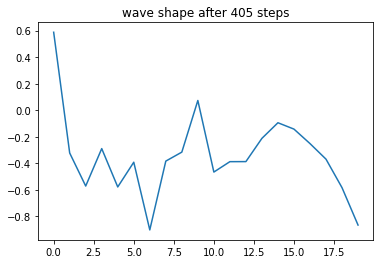

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_405/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_405/model_weights.tf
generator loss:0.25677935086466996
last advantage:[0.06649152]
last log token-prob:[-0.01849217]
last time gaussian:[-0.36429141]
last token entropy:[0.01815335]
last time entropy:[-0.04246798]
critic loss:0.008186925842940833
-----------------------
total discriminator loss:1.6819999228992475
average true return:0.52906250261274
-----------------------


 26%|██▌       | 406/1562 [36:35<2:43:41,  8.50s/it]

Training Step: 406
generator loss:0.24261259443142952
last advantage:[0.08191427]
last log token-prob:[-0.01627827]
last time gaussian:[-0.06223732]
last token entropy:[0.01601543]
last time entropy:[-0.03573245]
critic loss:0.008275313622934035
-----------------------


 26%|██▌       | 407/1562 [36:39<2:17:46,  7.16s/it]

total discriminator loss:0.3488321638706845
average true return:0.52637705600391
-----------------------
Training Step: 407
generator loss:0.23732215769554185
last advantage:[0.05115346]
last log token-prob:[-0.0157654]
last time gaussian:[-1.33692664]
last token entropy:[0.0155188]
last time entropy:[-0.01272189]
critic loss:0.008496349647468046
-----------------------
total discriminator loss:1.6363612584160885
average true return:0.5282110067532323
-----------------------


 26%|██▌       | 408/1562 [36:43<1:57:28,  6.11s/it]

Training Step: 408
generator loss:0.23255100397455516
last advantage:[0.05957278]
last log token-prob:[-0.01307966]
last time gaussian:[0.54719812]
last token entropy:[0.0129097]
last time entropy:[-0.05829645]
critic loss:0.009440067294944763
-----------------------
total discriminator loss:0.3617597373242875
average true return:0.5340596664142608
-----------------------


 26%|██▌       | 409/1562 [36:47<1:46:14,  5.53s/it]

Training Step: 409
generator loss:0.23397641758743926
last advantage:[0.01125777]
last log token-prob:[-0.01388467]
last time gaussian:[0.5075501]
last token entropy:[0.01369322]
last time entropy:[-0.02039534]
critic loss:0.010152704010007863
-----------------------
total discriminator loss:0.3535599272993474
average true return:0.5298759552938836
-----------------------


 26%|██▌       | 410/1562 [36:51<1:38:30,  5.13s/it]

Training Step: 410
event_types: [2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2]
mad_score: 0.0774
fid_score: 8725.24314866752
rule_score: 0.06725


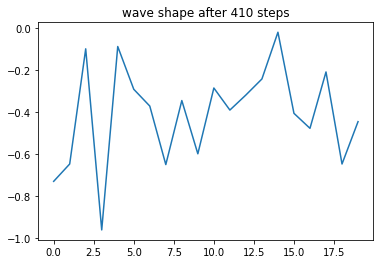

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_410/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_410/model_weights.tf
generator loss:0.22632991947799513
last advantage:[-0.00026873]
last log token-prob:[-0.01643763]
last time gaussian:[0.52280647]
last token entropy:[0.01616964]
last time entropy:[-0.02306801]
critic loss:0.010230652084304705
-----------------------
total discriminator loss:0.35889336783450315
average true return:0.5298659157797673
-----------------------


 26%|██▋       | 411/1562 [37:07<2:39:45,  8.33s/it]

Training Step: 411
generator loss:0.254030890618932
last advantage:[0.04022861]
last log token-prob:[-0.01305772]
last time gaussian:[0.24294566]
last token entropy:[0.01288832]
last time entropy:[-0.01785359]
critic loss:0.009385301566192262
-----------------------
total discriminator loss:0.36086610038994577
average true return:0.5343058556862933
-----------------------


 26%|██▋       | 412/1562 [37:11<2:15:51,  7.09s/it]

Training Step: 412
generator loss:0.24503330508293514
last advantage:[0.03736551]
last log token-prob:[-0.01437467]
last time gaussian:[0.47468421]
last token entropy:[0.01416952]
last time entropy:[0.00507471]
critic loss:0.008283358906671413
-----------------------
total discriminator loss:0.35893764822261415
average true return:0.5287209564647007
-----------------------


 26%|██▋       | 413/1562 [37:15<1:59:15,  6.23s/it]

Training Step: 413
generator loss:0.26930375620500546
last advantage:[0.05066788]
last log token-prob:[-0.01733917]
last time gaussian:[-1.88494667]
last token entropy:[0.01704111]
last time entropy:[-0.01371836]
critic loss:0.008042380216966788
-----------------------
total discriminator loss:0.3619681804712387
average true return:0.524408967858192
-----------------------


 27%|██▋       | 414/1562 [37:20<1:47:26,  5.62s/it]

Training Step: 414
generator loss:0.25417990558268444
last advantage:[-0.10643048]
last log token-prob:[-0.01642861]
last time gaussian:[0.2431074]
last token entropy:[0.01616092]
last time entropy:[0.0260101]
critic loss:0.006865180972706286
-----------------------
total discriminator loss:0.36632857566211907
average true return:0.5214313037173346
-----------------------


 27%|██▋       | 415/1562 [37:24<1:38:30,  5.15s/it]

Training Step: 415
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0778125
fid_score: 8730.071759139193
rule_score: 0.06325


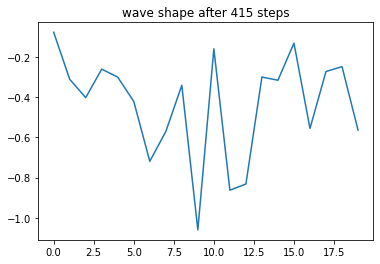

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_415/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_415/model_weights.tf
generator loss:0.26631379196304533
last advantage:[0.00396423]
last log token-prob:[-0.01510791]
last time gaussian:[0.4454318]
last token entropy:[0.01488138]
last time entropy:[-0.00983959]
critic loss:0.0058544889202429545
-----------------------
total discriminator loss:0.3771011443365423
average true return:0.5184248188034836
-----------------------


 27%|██▋       | 416/1562 [37:39<2:39:15,  8.34s/it]

Training Step: 416
generator loss:0.23380105239545293
last advantage:[-0.00927867]
last log token-prob:[-0.01372251]
last time gaussian:[0.32001657]
last token entropy:[0.01353549]
last time entropy:[0.00397138]
critic loss:0.005353053561140575
-----------------------
total discriminator loss:0.3544395482936864
average true return:0.5116642636729859
-----------------------


 27%|██▋       | 417/1562 [37:44<2:15:23,  7.09s/it]

Training Step: 417
generator loss:0.226280015423918
last advantage:[0.00347209]
last log token-prob:[-0.01527367]
last time gaussian:[-1.47235359]
last token entropy:[0.01504216]
last time entropy:[0.01084409]
critic loss:0.004609809189817835
-----------------------
total discriminator loss:0.3595002595402008
average true return:0.5070482796802858
-----------------------


 27%|██▋       | 418/1562 [37:48<1:58:08,  6.20s/it]

Training Step: 418
generator loss:0.2512289570091567
last advantage:[-0.04707897]
last log token-prob:[-0.01538563]
last time gaussian:[0.40031902]
last token entropy:[0.01515072]
last time entropy:[-0.0015202]
critic loss:0.004987758159762601
-----------------------
total discriminator loss:0.3465993085431369
average true return:0.4999708545009837
-----------------------


 27%|██▋       | 419/1562 [37:52<1:46:01,  5.57s/it]

Training Step: 419
generator loss:0.24938016646541633
last advantage:[-0.0453467]
last log token-prob:[-0.01468568]
last time gaussian:[0.43723993]
last token entropy:[0.01447159]
last time entropy:[-0.01300411]
critic loss:0.004910669690494808
-----------------------


 27%|██▋       | 420/1562 [37:56<1:35:11,  5.00s/it]

total discriminator loss:0.3460730342237421
average true return:0.4935986059919696
-----------------------
Training Step: 420
event_types: [0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0760125
fid_score: 8927.961649009661
rule_score: 0.0615


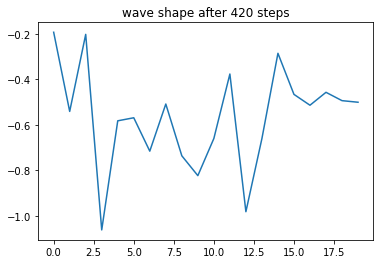

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_420/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_420/model_weights.tf
generator loss:0.2151270459391436
last advantage:[-0.07793298]
last log token-prob:[-0.01403188]
last time gaussian:[0.52498752]
last token entropy:[0.01383637]
last time entropy:[-0.03671965]
critic loss:0.005354185625997233
-----------------------
total discriminator loss:0.36110363882396146
average true return:0.48828090918738454
-----------------------


 27%|██▋       | 421/1562 [38:12<2:41:12,  8.48s/it]

Training Step: 421
generator loss:0.23947845899223258
last advantage:[-0.08698048]
last log token-prob:[-0.01671932]
last time gaussian:[0.48783536]
last token entropy:[0.01644211]
last time entropy:[-0.04374669]
critic loss:0.005856202302330822
-----------------------
total discriminator loss:0.35892513542010385
average true return:0.4878792947608231
-----------------------


 27%|██▋       | 422/1562 [38:16<2:16:05,  7.16s/it]

Training Step: 422
generator loss:0.23342369369348223
last advantage:[-0.0913947]
last log token-prob:[-0.0153748]
last time gaussian:[-0.09649587]
last token entropy:[0.01514023]
last time entropy:[0.0003046]
critic loss:0.006497690261480134
-----------------------


 27%|██▋       | 423/1562 [38:20<1:55:38,  6.09s/it]

total discriminator loss:0.3430913990493892
average true return:0.4861247036970259
-----------------------
Training Step: 423
generator loss:0.23278321634960478
last advantage:[-0.07741913]
last log token-prob:[-0.02030205]
last time gaussian:[0.14320626]
last token entropy:[0.01989403]
last time entropy:[-0.05881119]
critic loss:0.006983978584954409
-----------------------
total discriminator loss:0.3467051962278586
average true return:0.47844692925343024
-----------------------


 27%|██▋       | 424/1562 [38:24<1:44:33,  5.51s/it]

Training Step: 424
generator loss:0.2415233714373776
last advantage:[-0.10425073]
last log token-prob:[-0.01491839]
last time gaussian:[-0.59305695]
last token entropy:[0.01469749]
last time entropy:[-0.03724208]
critic loss:0.007327028132916575
-----------------------
total discriminator loss:0.3350594790368625
average true return:0.47643141366754826
-----------------------


 27%|██▋       | 425/1562 [38:28<1:37:04,  5.12s/it]

Training Step: 425
event_types: [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.074
fid_score: 9032.267375347856
rule_score: 0.05275


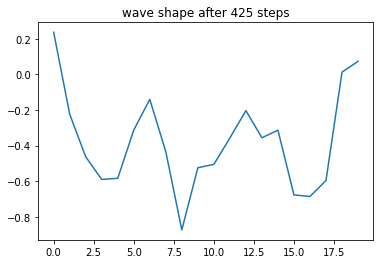

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_425/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_425/model_weights.tf
generator loss:0.24816114965427785
last advantage:[-0.10992344]
last log token-prob:[-0.01538659]
last time gaussian:[0.32525421]
last token entropy:[0.01515166]
last time entropy:[-0.03404482]
critic loss:0.0077440705697203694
-----------------------


 27%|██▋       | 426/1562 [38:42<2:24:15,  7.62s/it]

total discriminator loss:0.36034976078778885
average true return:0.4786391717700065
-----------------------
Training Step: 426
generator loss:0.23094163475335855
last advantage:[0.00583479]
last log token-prob:[-0.01393814]
last time gaussian:[-2.45313054]
last token entropy:[0.01374521]
last time entropy:[-0.00993494]
critic loss:0.007719624835864328
-----------------------


 27%|██▋       | 427/1562 [38:45<1:57:15,  6.20s/it]

total discriminator loss:1.5292825825241319
average true return:0.4773184065054069
-----------------------
Training Step: 427
generator loss:0.2324409764325585
last advantage:[-0.10519586]
last log token-prob:[-0.01596799]
last time gaussian:[0.17582198]
last token entropy:[0.01571504]
last time entropy:[-0.00388198]
critic loss:0.0069448359355290005
-----------------------


 27%|██▋       | 428/1562 [38:47<1:38:21,  5.20s/it]

total discriminator loss:0.3363803167035714
average true return:0.4788426158301011
-----------------------
Training Step: 428
generator loss:0.21744386690006764
last advantage:[-0.05380083]
last log token-prob:[-0.01311685]
last time gaussian:[0.35410133]
last token entropy:[0.01294592]
last time entropy:[-0.00966357]
critic loss:0.006403831255355041
-----------------------


 27%|██▋       | 429/1562 [38:50<1:25:08,  4.51s/it]

total discriminator loss:0.33108303834422326
average true return:0.4804626187591107
-----------------------
Training Step: 429
generator loss:0.2308520562937705
last advantage:[-0.07408761]
last log token-prob:[-0.01258917]
last time gaussian:[-0.39779063]
last token entropy:[0.01243168]
last time entropy:[-0.00234128]
critic loss:0.005804176314964063
-----------------------


 28%|██▊       | 430/1562 [38:53<1:15:52,  4.02s/it]

total discriminator loss:0.34927980121974533
average true return:0.48055598045793607
-----------------------
Training Step: 430
event_types: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0729125
fid_score: 8998.46784522244
rule_score: 0.04725


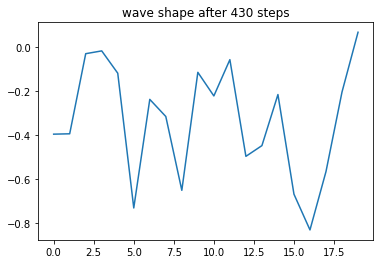

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_430/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_430/model_weights.tf
generator loss:0.2399388834194996
last advantage:[-0.08832495]
last log token-prob:[-0.0110554]
last time gaussian:[0.0261311]
last token entropy:[0.01093385]
last time entropy:[-0.02255421]
critic loss:0.00519270109367848
-----------------------


 28%|██▊       | 431/1562 [39:04<1:56:45,  6.19s/it]

total discriminator loss:0.35972630622831936
average true return:0.47837763384754006
-----------------------
Training Step: 431
generator loss:0.24329256433294702
last advantage:[-0.05511945]
last log token-prob:[-0.0135145]
last time gaussian:[0.24023529]
last token entropy:[0.01333309]
last time entropy:[0.00555769]
critic loss:0.004786920060393178
-----------------------


 28%|██▊       | 432/1562 [39:07<1:37:59,  5.20s/it]

total discriminator loss:0.35219586582889834
average true return:0.480193461309977
-----------------------
Training Step: 432
generator loss:0.22743730987255156
last advantage:[-0.05129396]
last log token-prob:[-0.01415807]
last time gaussian:[0.05165066]
last token entropy:[0.01395903]
last time entropy:[0.02256545]
critic loss:0.004401749763442134
-----------------------


 28%|██▊       | 433/1562 [39:10<1:24:56,  4.51s/it]

total discriminator loss:0.34758884309096016
average true return:0.4824042760717241
-----------------------
Training Step: 433
generator loss:0.20965553224284528
last advantage:[-0.0492055]
last log token-prob:[-0.01307368]
last time gaussian:[0.43239863]
last token entropy:[0.01290387]
last time entropy:[-0.00791549]
critic loss:0.004258497962404836
-----------------------


 28%|██▊       | 434/1562 [39:13<1:15:58,  4.04s/it]

total discriminator loss:0.352652324349498
average true return:0.48308926963260357
-----------------------
Training Step: 434
generator loss:0.21025698445873134
last advantage:[-0.03507571]
last log token-prob:[-0.01213752]
last time gaussian:[0.10207715]
last token entropy:[0.01199109]
last time entropy:[-0.01919218]
critic loss:0.003862577992820215
-----------------------


 28%|██▊       | 435/1562 [39:16<1:09:29,  3.70s/it]

total discriminator loss:0.3240226504628015
average true return:0.48805776965746606
-----------------------
Training Step: 435
event_types: [0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0713125
fid_score: 9149.998071253694
rule_score: 0.041


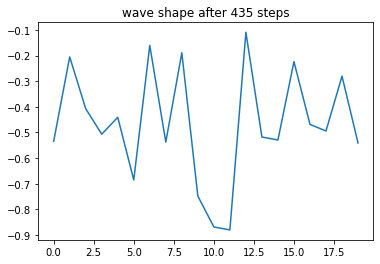

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_435/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_435/model_weights.tf
generator loss:0.2395433388970159
last advantage:[-0.02645666]
last log token-prob:[-0.01453188]
last time gaussian:[0.51863591]
last token entropy:[0.01432223]
last time entropy:[-0.02396682]
critic loss:0.003755387033696686
-----------------------
total discriminator loss:0.3525753085250162
average true return:0.49106268590419877
-----------------------


 28%|██▊       | 436/1562 [39:29<1:58:39,  6.32s/it]

Training Step: 436
generator loss:0.22270293657729337
last advantage:[-0.01172444]
last log token-prob:[-0.01221845]
last time gaussian:[0.29866572]
last token entropy:[0.01207007]
last time entropy:[-0.03316316]
critic loss:0.0037336416907674057
-----------------------
total discriminator loss:0.34495446987884015
average true return:0.4924140146515127
-----------------------


 28%|██▊       | 437/1562 [39:33<1:46:00,  5.65s/it]

Training Step: 437
generator loss:0.23367755036046053
last advantage:[-0.03002519]
last log token-prob:[-0.0133433]
last time gaussian:[0.51589222]
last token entropy:[0.01316644]
last time entropy:[-0.02091952]
critic loss:0.0036355905228217696
-----------------------


 28%|██▊       | 438/1562 [39:36<1:34:40,  5.05s/it]

total discriminator loss:0.3237423079345563
average true return:0.49441725672707193
-----------------------
Training Step: 438
generator loss:0.2383243363391223
last advantage:[0.00042023]
last log token-prob:[-0.01242388]
last time gaussian:[0.33909864]
last token entropy:[0.01227048]
last time entropy:[-0.01379435]
critic loss:0.003647767884040208
-----------------------
total discriminator loss:0.344431771617402
average true return:0.4945240317110323
-----------------------


 28%|██▊       | 439/1562 [39:40<1:26:05,  4.60s/it]

Training Step: 439
generator loss:0.2360696189530393
last advantage:[0.00155932]
last log token-prob:[-0.01429518]
last time gaussian:[0.07769628]
last token entropy:[0.01409228]
last time entropy:[-0.0192362]
critic loss:0.003561629336178161
-----------------------


 28%|██▊       | 440/1562 [39:43<1:17:49,  4.16s/it]

total discriminator loss:0.3532626042939251
average true return:0.49622705788719024
-----------------------
Training Step: 440
event_types: [2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]
mad_score: 0.0725
fid_score: 9144.897882816364
rule_score: 0.034


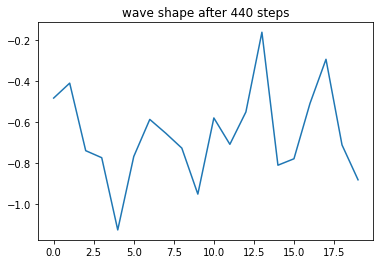

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_440/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_440/model_weights.tf
generator loss:0.23104618054663978
last advantage:[-0.00973199]
last log token-prob:[-0.01176383]
last time gaussian:[0.48520495]
last token entropy:[0.01162625]
last time entropy:[-0.02675418]
critic loss:0.00386977042682295
-----------------------
total discriminator loss:0.3305451823081218
average true return:0.4942446726459657
-----------------------


 28%|██▊       | 441/1562 [39:57<2:14:23,  7.19s/it]

Training Step: 441
generator loss:0.23069823501192582
last advantage:[0.0236727]
last log token-prob:[-0.01274843]
last time gaussian:[-0.78185537]
last token entropy:[0.01258694]
last time entropy:[-0.03615456]
critic loss:0.003804223505674463
-----------------------
total discriminator loss:0.32638392973991587
average true return:0.497734405019309
-----------------------


 28%|██▊       | 442/1562 [40:01<1:57:49,  6.31s/it]

Training Step: 442
generator loss:0.22660242069945555
last advantage:[-0.02565309]
last log token-prob:[-0.01142511]
last time gaussian:[-0.02948894]
last token entropy:[0.01129532]
last time entropy:[-0.00404125]
critic loss:0.0037167741040654624
-----------------------
total discriminator loss:0.34466725416797217
average true return:0.4960980841321493
-----------------------


 28%|██▊       | 443/1562 [40:06<1:46:13,  5.70s/it]

Training Step: 443
generator loss:0.2174654812674742
last advantage:[-0.0260452]
last log token-prob:[-0.01127565]
last time gaussian:[0.36797226]
last token entropy:[0.01114923]
last time entropy:[-0.00320593]
critic loss:0.003816451939752825
-----------------------
total discriminator loss:0.335514877366161
average true return:0.49580476035243937
-----------------------


 28%|██▊       | 444/1562 [40:10<1:39:29,  5.34s/it]

Training Step: 444
generator loss:0.2349474036419288
last advantage:[-0.0212652]
last log token-prob:[-0.01357939]
last time gaussian:[0.16037023]
last token entropy:[0.01339624]
last time entropy:[0.00540192]
critic loss:0.00395096056876376
-----------------------


 28%|██▊       | 445/1562 [40:14<1:28:11,  4.74s/it]

total discriminator loss:0.338572190240896
average true return:0.5007028832958118
-----------------------
Training Step: 445
event_types: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0702875
fid_score: 9241.329783558787
rule_score: 0.028


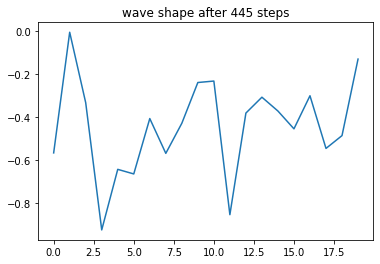

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_445/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_445/model_weights.tf
generator loss:0.19699516668699035
last advantage:[-0.00854318]
last log token-prob:[-0.0143665]
last time gaussian:[0.49965658]
last token entropy:[0.01416158]
last time entropy:[-0.0017518]
critic loss:0.0037508172743232456
-----------------------


 29%|██▊       | 446/1562 [40:25<2:04:25,  6.69s/it]

total discriminator loss:0.3432849367366707
average true return:0.49826361863804725
-----------------------
Training Step: 446
generator loss:0.23067268056180695
last advantage:[-0.01207509]
last log token-prob:[-0.01500405]
last time gaussian:[0.39855185]
last token entropy:[0.01478061]
last time entropy:[-0.00825637]
critic loss:0.004007917688728243
-----------------------


 29%|██▊       | 447/1562 [40:28<1:43:08,  5.55s/it]

total discriminator loss:0.329027947459583
average true return:0.49547806570916253
-----------------------
Training Step: 447
generator loss:0.23498783894224085
last advantage:[-0.00173788]
last log token-prob:[-0.01122686]
last time gaussian:[0.26255875]
last token entropy:[0.01110152]
last time entropy:[-0.028711]
critic loss:0.004368831141459816
-----------------------


 29%|██▊       | 448/1562 [40:31<1:28:12,  4.75s/it]

total discriminator loss:0.3522126353200941
average true return:0.4974935549467555
-----------------------
Training Step: 448
generator loss:0.22733732808144108
last advantage:[-0.03324293]
last log token-prob:[-0.01395273]
last time gaussian:[0.04813909]
last token entropy:[0.01375941]
last time entropy:[-0.03308502]
critic loss:0.004182863943260888
-----------------------


 29%|██▊       | 449/1562 [40:34<1:17:52,  4.20s/it]

total discriminator loss:0.3477220597755888
average true return:0.49902229441713675
-----------------------
Training Step: 449
generator loss:0.24769320418638693
last advantage:[-0.0236835]
last log token-prob:[-0.01556604]
last time gaussian:[-0.1241133]
last token entropy:[0.01532561]
last time entropy:[-0.00245323]
critic loss:0.004071910848827756
-----------------------


 29%|██▉       | 450/1562 [40:36<1:10:57,  3.83s/it]

total discriminator loss:0.3179542675521795
average true return:0.49691730241789833
-----------------------
Training Step: 450
event_types: [3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0695625
fid_score: 9377.99263446827
rule_score: 0.03225


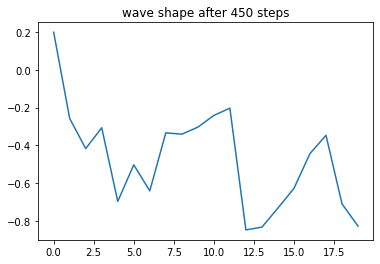

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_450/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_450/model_weights.tf
generator loss:0.23595836264108766
last advantage:[-0.00609073]
last log token-prob:[-0.0145951]
last time gaussian:[0.36162513]
last token entropy:[0.01438363]
last time entropy:[-0.01774395]
critic loss:0.004031322926417077
-----------------------


 29%|██▉       | 451/1562 [40:48<1:53:30,  6.13s/it]

total discriminator loss:0.31237056923184103
average true return:0.4985690329386744
-----------------------
Training Step: 451
generator loss:0.20227765866418917
last advantage:[0.00547909]
last log token-prob:[-0.01326686]
last time gaussian:[0.23319715]
last token entropy:[0.01309201]
last time entropy:[-0.00546795]
critic loss:0.004422658823948172
-----------------------


 29%|██▉       | 452/1562 [40:51<1:35:28,  5.16s/it]

total discriminator loss:0.30822435207546006
average true return:0.4986709811645458
-----------------------
Training Step: 452
generator loss:0.21346173402423743
last advantage:[-0.03549053]
last log token-prob:[-0.01461937]
last time gaussian:[0.50375054]
last token entropy:[0.0144072]
last time entropy:[-0.00473179]
critic loss:0.004206660243862645
-----------------------


 29%|██▉       | 453/1562 [40:54<1:22:53,  4.48s/it]

total discriminator loss:0.35022896997818026
average true return:0.4932600234661581
-----------------------
Training Step: 453
generator loss:0.21843436901470897
last advantage:[-0.00525179]
last log token-prob:[-0.0129037]
last time gaussian:[-2.00339816]
last token entropy:[0.01273826]
last time entropy:[-0.03739642]
critic loss:0.0044941922812353225
-----------------------


 29%|██▉       | 454/1562 [40:57<1:14:01,  4.01s/it]

total discriminator loss:0.32050838191379827
average true return:0.4912025658225797
-----------------------
Training Step: 454
generator loss:0.2193907531831638
last advantage:[0.0461508]
last log token-prob:[-0.01205546]
last time gaussian:[-0.06544549]
last token entropy:[0.011911]
last time entropy:[0.0001669]
critic loss:0.004320404117978006
-----------------------


 29%|██▉       | 455/1562 [41:00<1:07:43,  3.67s/it]

total discriminator loss:0.30722515215652413
average true return:0.4964679430107902
-----------------------
Training Step: 455
event_types: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0680625
fid_score: 9381.13482502307
rule_score: 0.02


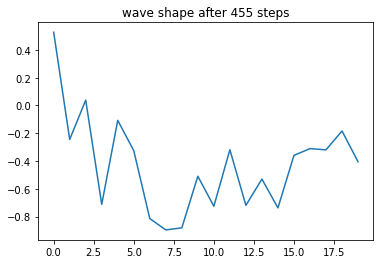

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_455/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/D_455/model_weights.tf
generator loss:0.21180248450896566
last advantage:[-0.01901859]
last log token-prob:[-0.01257717]
last time gaussian:[0.41145393]
last token entropy:[0.01241998]
last time entropy:[0.01141899]
critic loss:0.004300608523390639
-----------------------
total discriminator loss:1.8484012878551628
average true return:0.4941379947333778
-----------------------


 29%|██▉       | 456/1562 [41:15<2:13:50,  7.26s/it]

Training Step: 456
generator loss:0.18997729607802413
last advantage:[-0.00946082]
last log token-prob:[-0.01448473]
last time gaussian:[0.50177378]
last token entropy:[0.01427643]
last time entropy:[-0.0093047]
critic loss:0.004241205574627697
-----------------------
total discriminator loss:0.33517623663259155
average true return:0.4957878175296385
-----------------------


 29%|██▉       | 457/1562 [41:19<1:57:09,  6.36s/it]

Training Step: 457
generator loss:0.1910824002909378
last advantage:[0.00623199]
last log token-prob:[-0.01374416]
last time gaussian:[0.50135517]
last token entropy:[0.01355655]
last time entropy:[-0.00538879]
critic loss:0.003949345375313523
-----------------------
total discriminator loss:0.30709889593764195
average true return:0.5002244309124131
-----------------------


 29%|██▉       | 458/1562 [41:24<1:45:33,  5.74s/it]

Training Step: 458
generator loss:0.1815584916304952
last advantage:[-0.00474515]
last log token-prob:[-0.00990036]
last time gaussian:[0.47691699]
last token entropy:[0.00980283]
last time entropy:[0.00602184]
critic loss:0.0038769034997316295
-----------------------


 29%|██▉       | 459/1562 [41:27<1:31:33,  4.98s/it]

total discriminator loss:0.3315540386240792
average true return:0.49896241009027964
-----------------------
Training Step: 459
generator loss:0.1868873759832051
last advantage:[0.0257369]
last log token-prob:[-0.01358061]
last time gaussian:[0.47712618]
last token entropy:[0.01339742]
last time entropy:[-0.00882029]
critic loss:0.003960336156640619
-----------------------


 29%|██▉       | 460/1562 [41:30<1:19:54,  4.35s/it]

total discriminator loss:0.32934124016478034
average true return:0.5029190804640842
-----------------------
Training Step: 460


 29%|██▉       | 460/1562 [41:37<1:39:41,  5.43s/it]


KeyboardInterrupt: 

In [45]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, train_model_save_path, verbose=True, plot=True)
        train_history['mad'].append(_mad_score)
        train_history['fid'].append(_fid_score)
        train_history['oracle'].append(_rule_score)
        
    # train the generator and critic
    for _ in range(_G_STEPS):
        gen_loss, critic_loss = train_generator_mcc(G, D, critic, BATCH_SIZE, T,
                                                    beta_token, beta_time, verbose=True, optimizer=G_optimizer, 
                                                    use_advantage=False, temperature=1, use_tlstm=True)
        train_history['gen_loss'].append(gen_loss.numpy())
        train_history['critic_loss'].append(critic_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_mcc(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        train_history['disc_loss'].append(disc_loss.numpy())
        train_history['avg_true_return'].append(ave_true_return.numpy())
                
    step += 1

Text(0.5, 0, 'Training steps')

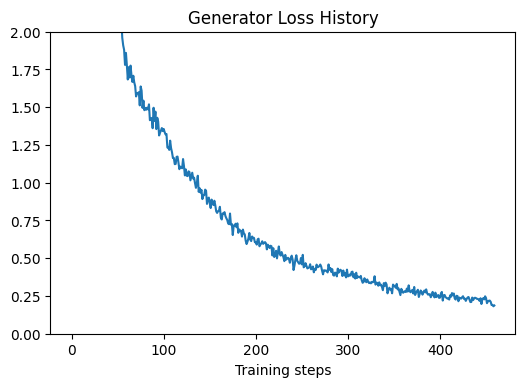

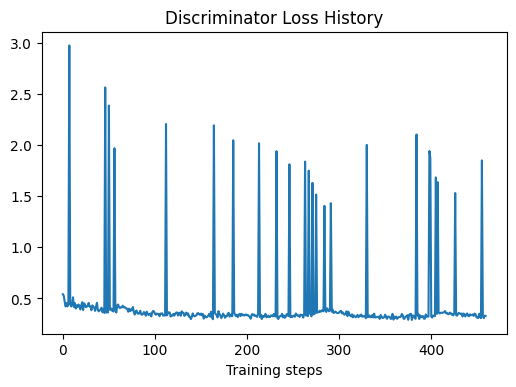

In [57]:
gen_loss_history = train_history['gen_loss']
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')
plt.ylim([0, 2])

disc_loss_history = train_history['disc_loss']
x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

Text(0.5, 0, 'Training steps')

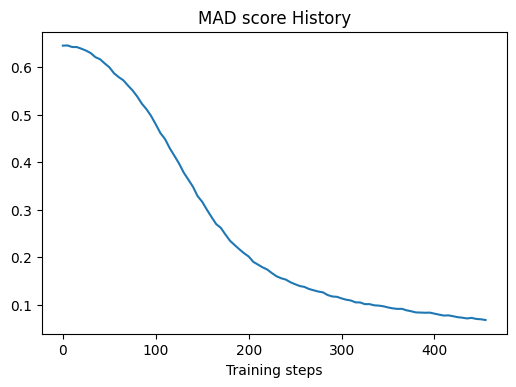

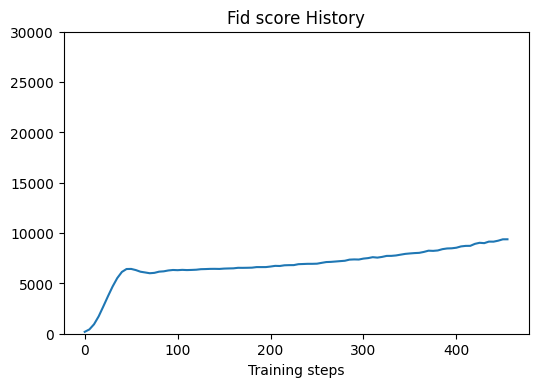

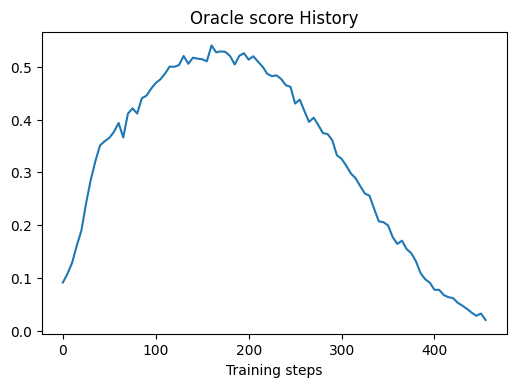

In [50]:
mad_history = train_history['mad']
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

fid_history = train_history['fid']
x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 30000])

rule_history = train_history['oracle']
x =  [i * 5 for i in range(len(rule_history))]
plt.figure(dpi=100)
plt.plot(x, rule_history)
plt.title('Oracle score History')
plt.xlabel('Training steps')

## save train stats

In [51]:
train_metrics_history = {k : train_history[k] for k in ['mad', 'fid', 'oracle']}
train_losses_history = {k : train_history[k] for k in ['gen_loss', 'disc_loss', 'critic_loss', 'avg_true_return']}

In [66]:
df_train_metrics = pd.DataFrame(train_metrics_history)
df_train_metrics.index = pd.Index(range(0,step,5))

In [68]:
df_train_metrics

mad          fid   oracle
0    0.645687   188.587346  0.09100
5    0.646075   425.224295  0.10775
10   0.642763   937.777147  0.12875
15   0.642713  1724.744242  0.16125
20   0.639150  2709.305914  0.19000
..        ...          ...      ...
435  0.071313  9149.998071  0.04100
440  0.072500  9144.897883  0.03400
445  0.070288  9241.329784  0.02800
450  0.069562  9377.992634  0.03225
455  0.068062  9381.134825  0.02000

[92 rows x 3 columns]

In [67]:
np.argmax(df_train_metrics['oracle'])

32

In [60]:
df_train_metrics.iloc[32]

mad          0.284925
fid       6495.295579
oracle       0.540750
Name: 32, dtype: float64

In [69]:
df_train_losses = pd.DataFrame(train_losses_history)
df_train_losses.index = pd.Index(range(step))

In [70]:
df_train_metrics.to_csv(os.path.join(train_model_save_path, 'train_metrics.csv'), header=True, index=True)
df_train_losses.to_csv(os.path.join(train_model_save_path, 'train_losses.csv'), header=True, index=True)

In [89]:
train_model_save_path

'/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47'

## Compare between G0, G1 and G2

In [ ]:
def get_metrics(_gen_seqs_et, _gen_seqs_ts):
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

## Generate Synthesized data for MCC

In [76]:
def generate_sequence_for_saving(generator, N, save_path):
    _gen_seqs_et, _gen_seqs_ts, _, _, _ = generate_sequences_mcc(N, generator, BATCH_SIZE, T, temperature=1, use_tlstm=False)
    # convert one-hot event types to indices; convert normalized timestamps to original
    _save_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N, T, 1)
    _save_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD).numpy().reshape(N, T, 1)
    
    seqs_filename_et = 'syn_type_sequences.pickle'
    seqs_filename_ts = 'syn_time_sequences.pickle'
    
    with open(os.path.join(save_path, seqs_filename_et), 'wb') as f:
        pickle.dump(_save_seqs_et_ind, f)

    with open(os.path.join(save_path, seqs_filename_ts), 'wb') as f:
        pickle.dump(_save_seqs_ts_ori, f)
        

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

## G0

In [80]:
G0 = build_G_mcc(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM
)

G0_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_0/model_weights.tf'
G0.build(input_shape=((BATCH_SIZE, T, 1)))
G0.load_weights(G0_save_path)

get_generation_metrics(G0)

{'mad': 0.7311375,
 'fid': 2869.2442669419106,
 'oracle': 0.10025,
 'smad': 0.7311375}

In [84]:
data_save_path_G0 = os.path.join(repo_path, 'syn_data', 'monte_carlo_critic_2021-04-02-09-25-47', 'G0')
generate_sequence_for_saving(G0, 400000, data_save_path_G0)

In [81]:
G1 = build_G_mcc(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G1_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-09-04-44/G_92/model_weights.tf'
G1.build(input_shape=((BATCH_SIZE, T, 1)))
G1.load_weights(G1_save_path)

get_generation_metrics(G1)

{'mad': 0.6447125,
 'fid': 183.7160934405784,
 'oracle': 0.094,
 'smad': 0.6447125}

In [85]:
data_save_path_G1 = os.path.join(repo_path, 'syn_data', 'monte_carlo_critic_2021-04-02-09-25-47', 'G1')
generate_sequence_for_saving(G1, 400000, data_save_path_G1)

In [82]:
G2 = build_G_mcc(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G2_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/G_160/model_weights.tf'
G2.build(input_shape=((BATCH_SIZE, T, 1)))
G2.load_weights(G2_save_path)

get_generation_metrics(G2)

{'mad': 0.286275,
 'fid': 6503.701043005744,
 'oracle': 0.52275,
 'smad': 0.286275}

In [86]:
data_save_path_G2 = os.path.join(repo_path, 'syn_data', 'monte_carlo_critic_2021-04-02-09-25-47', 'G2')
generate_sequence_for_saving(G2, 400000, data_save_path_G2)

In [87]:
data_save_path_G2

'/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/syn_data/monte_carlo_critic_2021-04-02-09-25-47/G2'